##Data Source
https://www.kaggle.com/mlg-ulb/creditcardfraud 

##Problem Statement
##Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

##Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Files available on these location
!ls "/content/drive/My Drive/Credit_Card_Fraud"  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
creditcard.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import svm
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import make_pipeline, Pipeline
from scipy import stats
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.gridspec as gridspec
import time

sns.set_style(style = 'whitegrid' )
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Reading the data from the Drive
credit_card = pd.read_csv('/content/drive/My Drive/Credit_Card_Fraud/creditcard.csv')
credit_card.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]

In [ ]:
# Lets check the dimension of the table
print(f'Number of Rows: {credit_card.shape[0]} and Number of Columns: {credit_card.shape[1]}')
print(f'Column Names: {credit_card.columns.tolist()}')

Number of Rows: 284807 and Number of Columns: 31
Column Names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [ ]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Conclusion** :
1.   Most of the data is integer
2.   And only three features are present which is not not transformed data, *Time, Amount, Class*  

In [ ]:
# Lets check the Statistic of three features ( which is not PCA transformed)
credit_card[['Time','Amount','Class']].describe(percentiles = [.05,.10,.25,.50,.75,.99])

Time         Amount          Class
count  284807.000000  284807.000000  284807.000000
mean    94813.859575      88.349619       0.001727
std     47488.145955     250.120109       0.041527
min         0.000000       0.000000       0.000000
5%      25297.600000       0.920000       0.000000
10%     35027.000000       1.000000       0.000000
25%     54201.500000       5.600000       0.000000
50%     84692.000000      22.000000       0.000000
75%    139320.500000      77.165000       0.000000
99%    170560.940000    1017.970000       0.000000
max    172792.000000   25691.160000       1.000000

**Conclusion**
1. For *Time* we have data spread from 0 to 172792, **Number of seconds elapsed between this transaction and the first transaction in the dataset**, so this looks more like a sequential data, when we would do EDA we would have a better understanding
2. For *Amount* we can see some spikes, we can see between **75th and 99th Percentile there is a huge jump**, as well as we can see the max value is way bigger than 99%
3. For *Class* there are only two distinct data, **one is class 1 which is Fraud and 0 which is authentic data** 

In [ ]:
# Class Distribution
print(credit_card['Class'].value_counts())
# And it can be seen there is a lot of imbalance in the dataset
print('<=====================================================================================>')
# Lets check the % Distribution
auth_det_per = round((credit_card[credit_card['Class']==0].shape[0]/credit_card.shape[0])*100,2)
fraud_det_per = round((credit_card[credit_card['Class']==1].shape[0]/credit_card.shape[0])*100,2)
print(f'Authentic Transaction {auth_det_per}%')
print(f'Fraud Transaction {fraud_det_per}%')

0    284315
1       492
Name: Class, dtype: int64
<=====================================================================================>
Authentic Transaction 99.83%
Fraud Transaction 0.17%


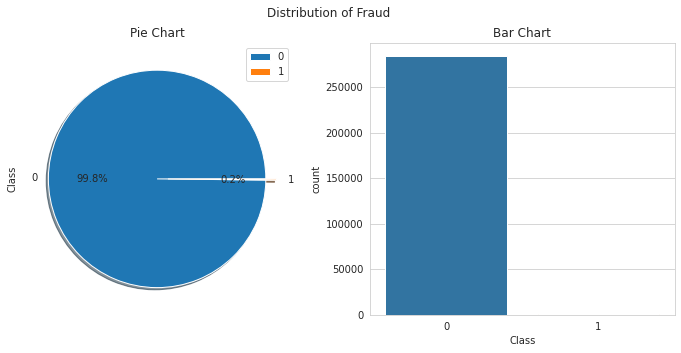

In [ ]:
# Lets check the distribution of the Target Variable
f,ax=plt.subplots(1,2,figsize= (12,5))
plt.suptitle('Distribution of Fraud')
credit_card['Class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True, ax = ax[0])
ax[0].set_title('Pie Chart')
ax[0].legend()
sns.countplot(credit_card['Class'],ax=ax[1])
ax[1].set_title('Bar Chart')
plt.show()

**Conclusion**
1. As it can be seen above there is a lot of data imbalance in the data set.
2. We have around *99.8%* for Authenticated Transaction Dataset and we have just *~0.2%* of Fraud Data, which is highly unbalanced.

In [ ]:
# Lets check for Null in the dataset 
print(credit_card.isna().sum())
# As we can see below no column has any null values
print('<==========================================================================>')
#Lets check whether there exists some more 
print(f'Number of Duplicate Rows {credit_card[credit_card.duplicated()].shape[0]}')

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
<==========================================================================>
Number of Duplicate Rows 1081


**Conclusion** :
1. As we can see, there is no rows with Null Values
2. There are *1081* records which are duplicate

In [ ]:
# Lets check some duplicated data point and try to understand 
credit_card[credit_card.duplicated()].head(10)

Time        V1        V2        V3  ...       V27       V28  Amount  Class
33      26.0 -0.529912  0.873892  1.347247  ... -0.073288  0.023307    6.14      0
35      26.0 -0.535388  0.865268  1.351076  ... -0.078306  0.025427    1.77      0
113     74.0  1.038370  0.127486  0.184456  ...  0.081247  0.001192    1.18      0
114     74.0  1.038370  0.127486  0.184456  ...  0.081247  0.001192    1.18      0
115     74.0  1.038370  0.127486  0.184456  ...  0.081247  0.001192    1.18      0
221    145.0 -2.420413  1.947885  0.553646  ... -0.188281  0.119831    6.00      0
223    145.0 -2.419486  1.949346  0.552998  ... -0.187431  0.119472    6.74      0
1178   919.0  0.904289 -0.538055  0.396058  ... -0.081357  0.027252  158.00      0
1180   919.0  1.207596 -0.036860  0.572104  ... -0.051693 -0.000085    1.00      0
1382  1074.0 -2.248488 -0.195670  0.026949  ... -0.286998 -0.243768  158.00      0

[10 rows x 31 columns]

In [ ]:
#Dropping Duplicate rows
credit_card.drop(index=credit_card[credit_card.duplicated()].index.tolist(), inplace=True)

In [ ]:
#Checking Duplicate rows again
print(f'Number of Duplicate Rows {credit_card[credit_card.duplicated()].shape[0]}')

Number of Duplicate Rows 0


In [ ]:
credit_card.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]

### Exploratory Data Analysis

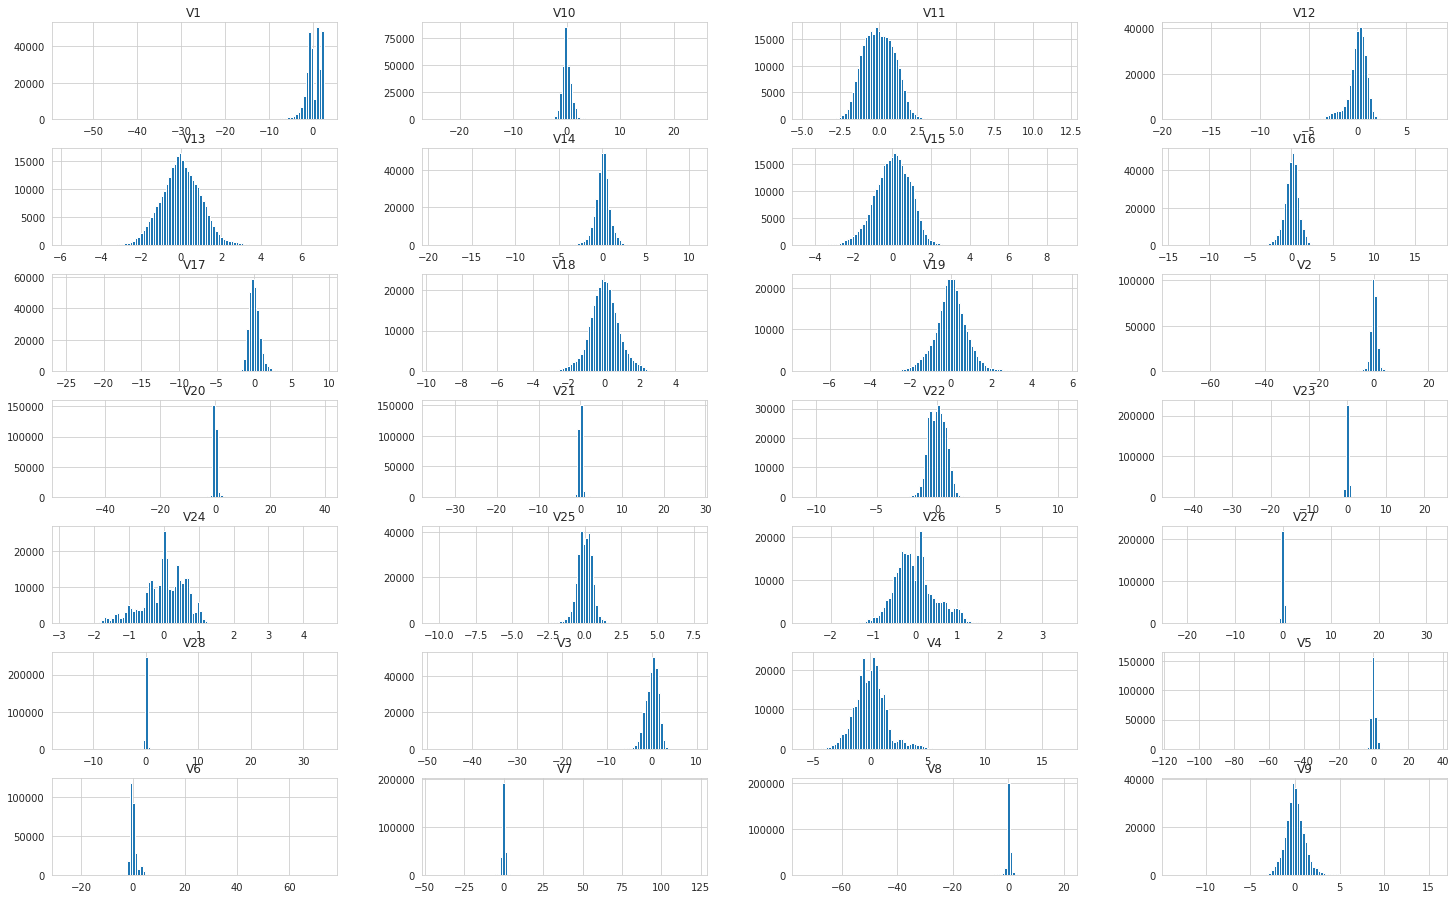

In [ ]:
credit_card.drop(columns=['Time','Amount','Class']).hist(bins=100, figsize=(25,18),layout=(8,4))
plt.show()



*   All the variables follow Guassian curve and are centered towards mean.
*   Some of the variables are skewed that has to be handled on the Data cleaning.



### Analysing variables: Time and Amount

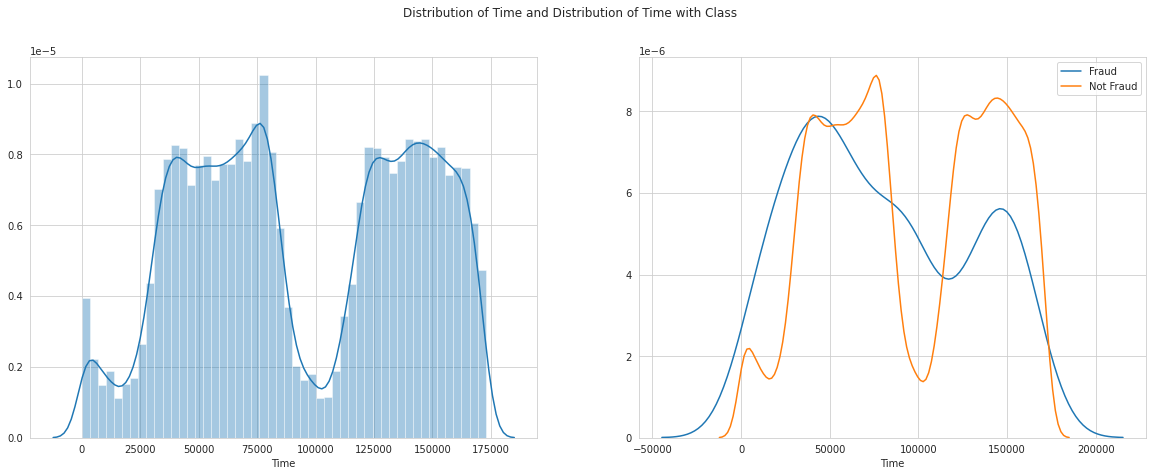

In [ ]:
plt.figure(figsize=(20,7))
plt.suptitle('Distribution of Time and Distribution of Time with Class', fontsize=12)

plt.subplot(1,2,1)
sns.distplot(credit_card['Time'])

plt.subplot(1,2,2)
sns.distplot(credit_card[credit_card['Class']==1]['Time'], hist=False, label='Fraud')
sns.distplot(credit_card[credit_card['Class']==0]['Time'], hist=False, label='Not Fraud')

plt.show()


* From the above plot, it can be seen occurence of transactions have two peak 
periods.
* Fraud transactions also have occurence in the same periods.
* The variable 'Time' can't differentiate between Fraud and Non Fraud Transactions.



In [ ]:
# As Time is Second, lets try to convert to hours, and also lets see the behaviour
credit_card['Hour'] = credit_card['Time'].apply(lambda x: np.ceil(int(x)/3600) % 24)
# Lets check some of the Data in Hours
print(credit_card['Hour'].value_counts())

print('<===================================================================================>')

# As we know the data span is on Two Days and it can be seen below most the transaction happen 
# Between the second half of the day and there is least transaction between 1:00AM - 8:00AM

(credit_card.pivot_table(values = 'Amount', index = 'Hour', columns = 'Class',  aggfunc= 'count')).sort_values(by = 1, ascending = False)

22.0    17634
19.0    16956
12.0    16782
21.0    16706
11.0    16551
15.0    16518
17.0    16400
16.0    16373
18.0    16128
10.0    15769
20.0    15568
13.0    15375
23.0    15370
14.0    15325
0.0     10885
9.0     10231
1.0      7645
8.0      7232
2.0      4210
7.0      4083
4.0      3488
3.0      3306
6.0      2988
5.0      2203
Name: Hour, dtype: int64
<===================================================================================>


Class      0   1
Hour            
12.0   16729  53
3.0     3258  48
19.0   16928  28
18.0   16100  28
16.0   16347  26
5.0     2180  23
8.0     7209  23
15.0   16495  23
17.0   16378  22
20.0   15549  19
21.0   16688  18
13.0   15358  17
14.0   15308  17
0.0    10868  17
4.0     3471  17
10.0   15753  16
22.0   17618  16
6.0     2977  11
2.0     4200  10
9.0    10222   9
7.0     4074   9
23.0   15361   9
11.0   16543   8
1.0     7639   6

<Figure size 432x288 with 0 Axes>

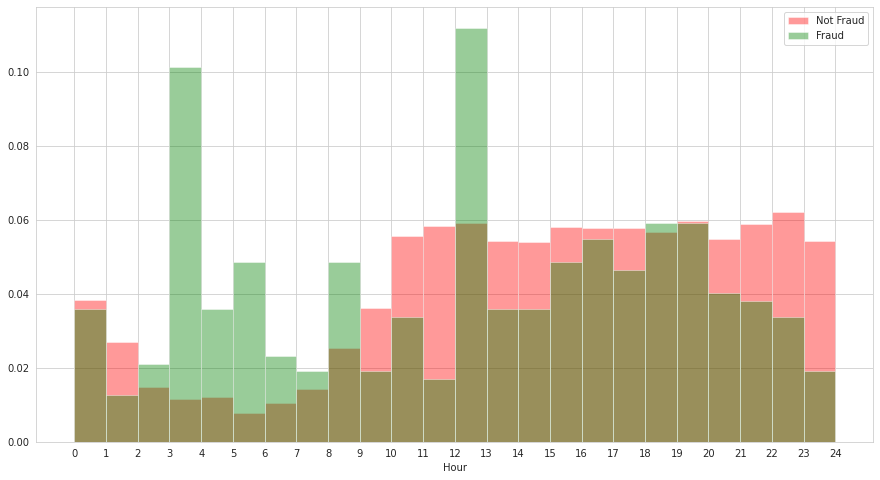

In [ ]:
# Lets check out the distribution of Fraud wrt to Time of the day
bins = np.arange(0,25)
plt.suptitle('Nomalized Distributrion of Fraud/Not Fraud, over the day')
plt.figure(figsize=(15,8))
sns.distplot(     credit_card[credit_card['Class']==0]['Hour'],  
                  norm_hist=True, 
                  bins=bins,
                  kde=False,
                  color='r',
                  label='Not Fraud')

sns.distplot(     credit_card[credit_card['Class']==1]['Hour'], 
                  norm_hist=True, 
                  bins=bins,
                  kde=False,
                  color='g',
                  label='Fraud')
plt.xticks(range(0,25))
plt.legend()
plt.show()

**Conclusion**

As we can see above there are some hours where there are lots of frauds happened like in the early hours of the day. But its not conclusive but it is not possible not conclude that time has some some impact as we have less amount of data now for the fraud  

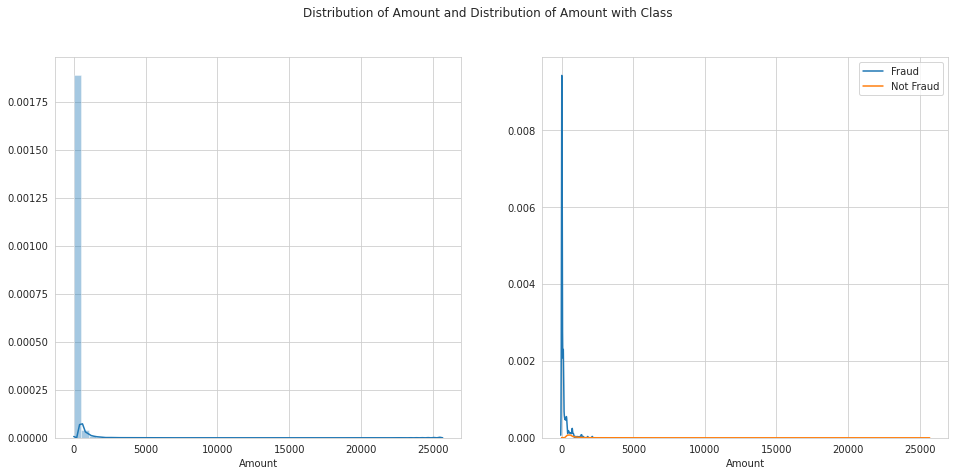

In [ ]:
plt.figure(figsize=(16,7))
plt.suptitle('Distribution of Amount and Distribution of Amount with Class', fontsize=12)

plt.subplot(1,2,1)
sns.distplot(credit_card['Amount'])

plt.subplot(1,2,2)
sns.distplot(credit_card[credit_card['Class']==1]['Amount'], hist=False, label='Fraud')
sns.distplot(credit_card[credit_card['Class']==0]['Amount'], hist=False, label='Not Fraud')

plt.show()

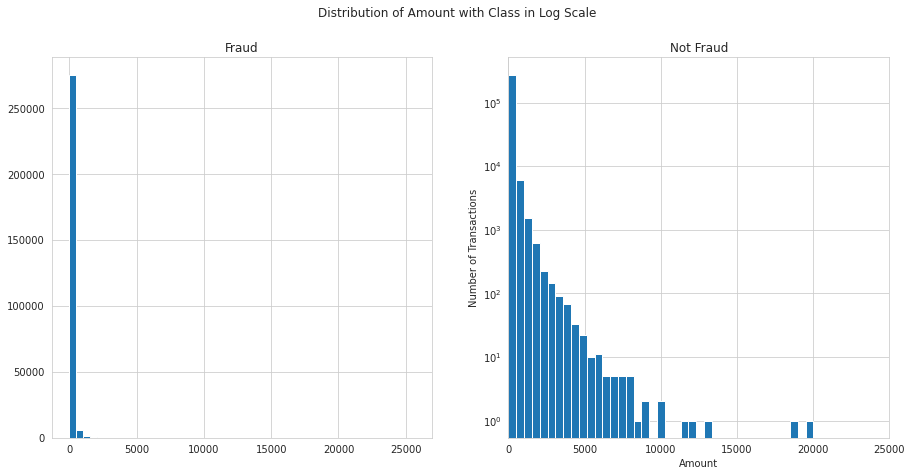

In [ ]:
bins = 50
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
f.suptitle('Distribution of Amount with Class in Log Scale', fontsize=12)
ax1.hist(credit_card.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(credit_card.Amount, bins = bins)
ax2.set_title('Not Fraud')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 25000))
plt.yscale('log')
plt.show()

* Number of outliers seem to be a lot in the variable hence making the distribution of data highly skewed towards left.

In [ ]:
pd.DataFrame([credit_card[credit_card['Class']==1]['Amount'].describe(),credit_card[credit_card['Class']==0]['Amount'].describe()], index=['Class:1','Class:0']).T

Class:1        Class:0
count   473.000000  283253.000000
mean    123.871860      88.413575
std     260.211041     250.379023
min       0.000000       0.000000
25%       1.000000       5.670000
50%       9.820000      22.000000
75%     105.890000      77.460000
max    2125.870000   25691.160000

* There isn't any differentiable factor on the statistics of both the classes.
* There is huge difference between 75% and max that shows the variable must have massive outliers.

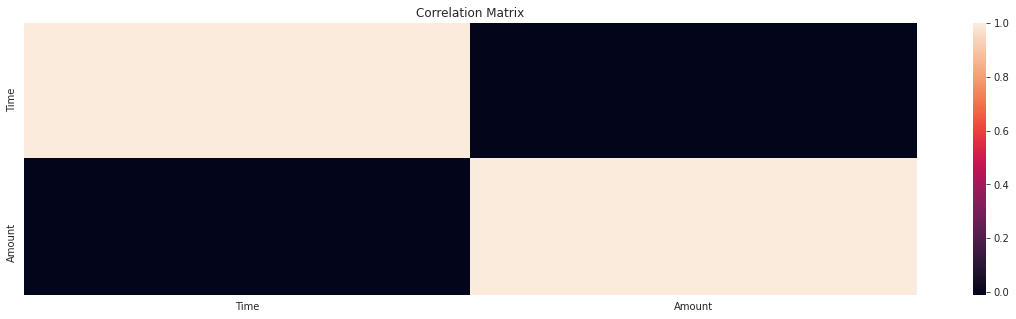

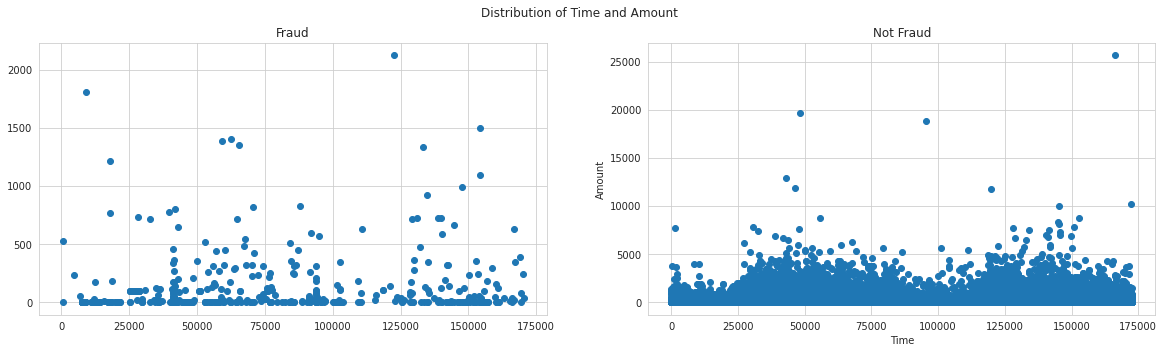

In [ ]:
# Lets try to see if there is some correlation exists between amount and time
plt.figure(figsize=(20, 5))
plt.title('Correlation Matrix')
sns.heatmap(credit_card[['Time','Amount']].corr())
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
f.suptitle('Distribution of Time and Amount', fontsize=12)

ax1.scatter(credit_card[credit_card['Class']==1]['Time'], credit_card[credit_card['Class']==1]['Amount'])
ax1.set_title('Fraud')

ax2.scatter(credit_card[credit_card['Class']==0]['Time'], credit_card[credit_card['Class']==0]['Amount'])
ax2.set_title('Not Fraud')

plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

**Conclusion**
1. As we can see there is no Correleation between Time and Amount
2. And we can also see wrt to Fraud and Not Fraud there is not much significamnt effect wrt to Time to Amount
3. So we can drop this feature as this not an effective feature

### Some Analysis On Feature Importance

In [ ]:
# So we would build a Random Forest Models with some Random Values and would like to see what is the Feature Importance of each features
# So we are also using the class weight here as the Data is imbalanced
rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           warm_start = True,
                           verbose = 1,
                           class_weight = {0:1,1:5},
                           random_state = 42)
rf.fit(credit_card.drop(['Class'], axis = 1), credit_card['Class'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 5},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=1,
                       warm_start=True)

In [ ]:
variables = credit_card.drop(['Class'], axis = 1).columns

# feature_importance
importance = rf.feature_importances_

feature_importance = pd.DataFrame({'Features': variables, 'imp_percentage': importance*100})
feature_importance = feature_importance[['Features', 'imp_percentage']]
# sort features
feature_importance = feature_importance.sort_values('imp_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.imp_percentage.sum())
feature_importance

Sum of importance= 100.00000000000001


Features  imp_percentage
0       V14       18.165456
1       V17       13.537315
2       V10       13.518689
3       V12       11.538078
4       V11        7.515031
5       V16        5.522188
6        V9        4.038536
7        V4        3.348700
8       V18        2.517508
9        V3        2.171705
10       V7        1.804011
11       V1        1.332834
12      V21        1.107409
13       V5        1.046553
14      V19        0.930627
15   Amount        0.894206
16       V2        0.884367
17      V20        0.875229
18      V13        0.865057
19      V15        0.856157
20      V26        0.852907
21       V8        0.835978
22      V27        0.804973
23       V6        0.781506
24     Time        0.672303
25      V28        0.627304
26      V23        0.605867
27      V25        0.592074
28      V24        0.591967
29     Hour        0.589228
30      V22        0.576237

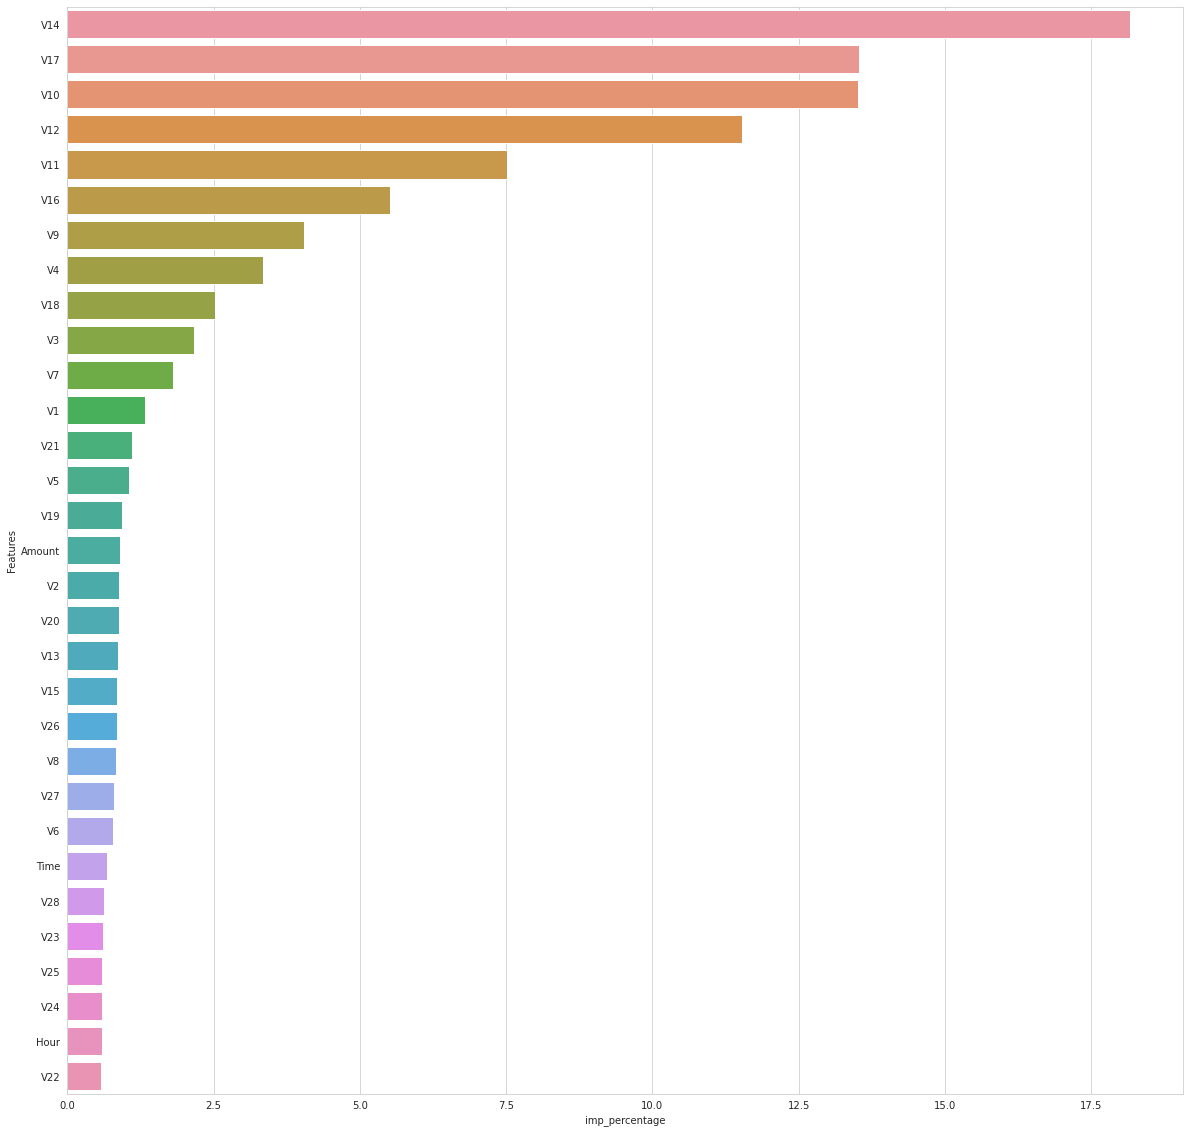

In [ ]:
plt.figure(figsize=(20,20))
sns.barplot(x = feature_importance.imp_percentage, y=feature_importance.Features)
plt.show()

**Conclusion**
As we can see most of the features are having very less number of features but we can drop then we would be left with very less features, lets do the same features after the intial model building

### Checking the properties of different features wrt to Class

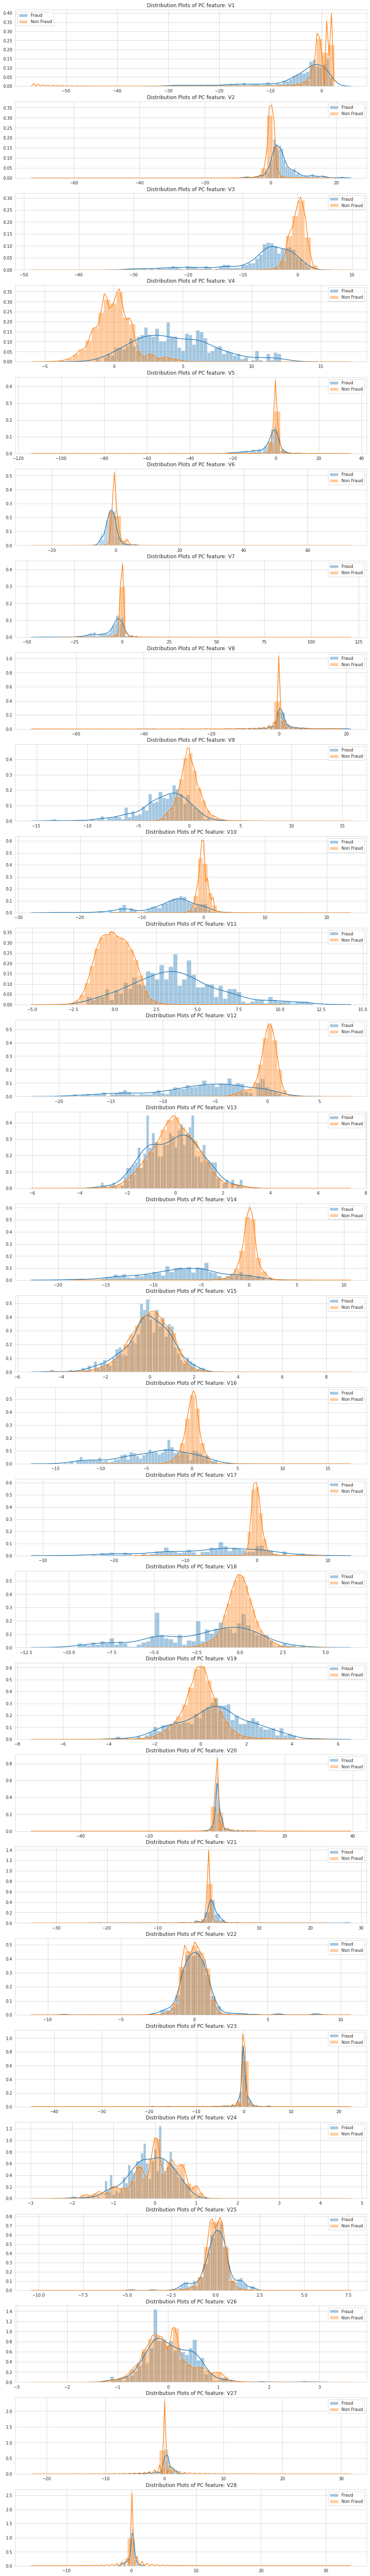

In [ ]:
# Checking the PC wrt to class distribution
col_names = credit_card.drop(columns=['Time','Amount','Class','Hour']).columns.tolist()

plt.figure(figsize=(15,30*4))
gs = gridspec.GridSpec(30, 1)
for i, cn in enumerate(credit_card[col_names]):
    ax = plt.subplot(gs[i])
    sns.distplot(credit_card[cn][credit_card.Class == 1], bins=50, label = 'Fraud')
    sns.distplot(credit_card[cn][credit_card.Class == 0], bins=50, label = 'Non Fraud')
    ax.set_xlabel('')
    ax.legend()
    ax.set_title('Distribution Plots of PC feature: ' + str(cn))
plt.show()

**Conclusion**
- As we can see here some of the Features have high dependencies wrt to Class like v11, v12, v14, v16, v17, v18

### Checking correlation among variables

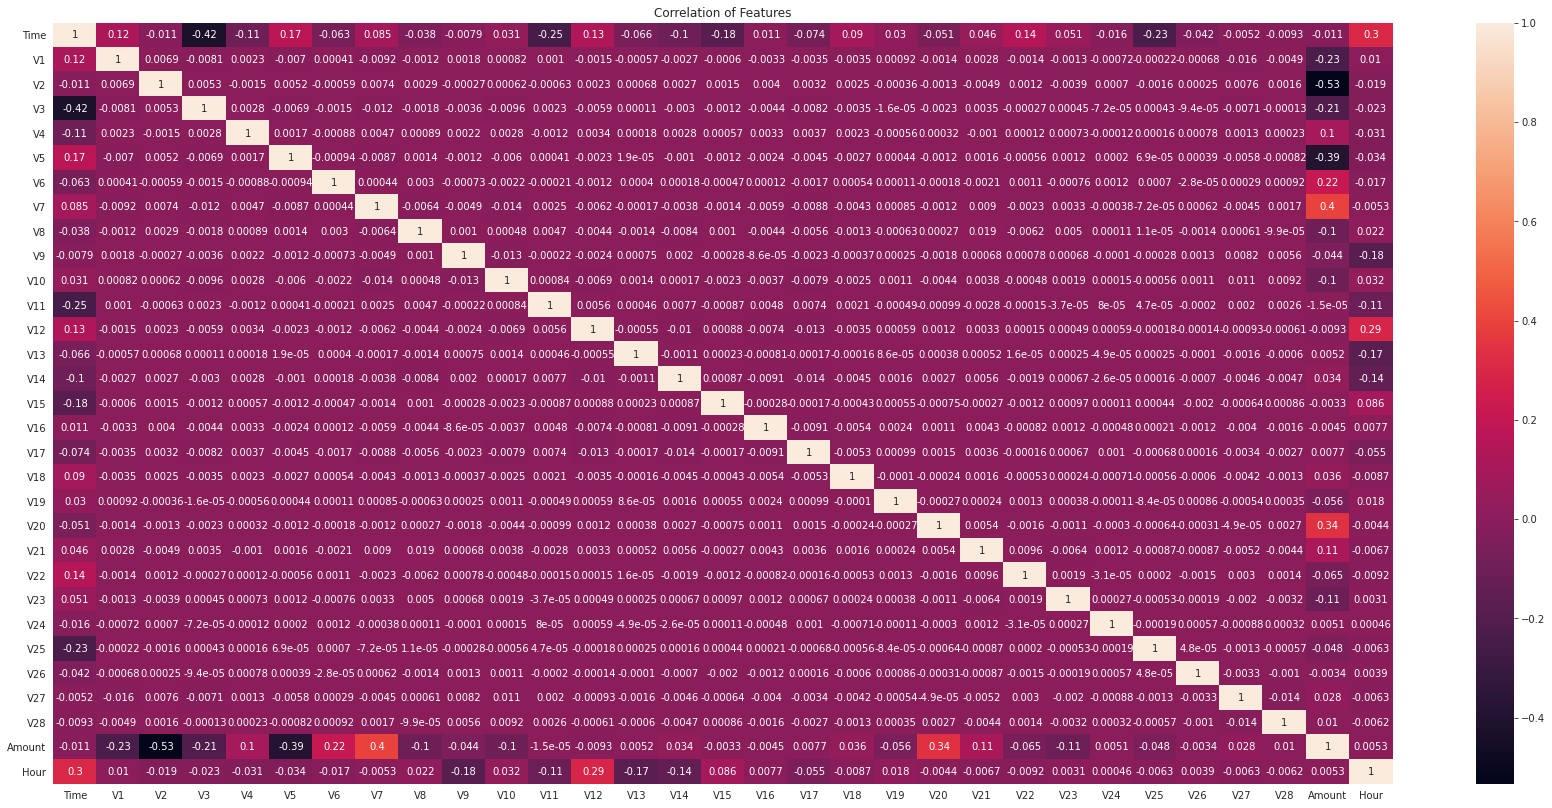

In [ ]:
plt.figure(figsize=(30,14))
sns.heatmap(credit_card.drop(columns = 'Class').corr(),annot=True)
plt.title('Correlation of Features')
plt.show()

PCA transformed variables must have zero correlation among them which can be verified from the above plot.

### Checking and dealing with Skewness

In [ ]:
skewness = {}
for variable in credit_card.drop(columns='Class').columns.tolist():
  skewness[variable] = abs(credit_card[variable].skew())
skewness_df = pd.DataFrame([skewness.keys(), skewness.values()], index = ['Variables','skewness']).T
skewness_df.sort_values(by='skewness', ascending=False)

Variables   skewness
29    Amount    16.9788
28       V28    11.5551
8         V8    8.31097
23       V23    5.86722
2         V2    4.69516
17       V17     3.6905
1         V1    3.27327
7         V7    2.89027
21       V21    2.82003
5         V5    2.41408
12       V12    2.19901
3         V3    2.15198
20       V20    2.04312
14       V14     1.9188
6         V6    1.82988
10       V10    1.25297
16       V16    1.05116
27       V27   0.753804
4         V4   0.671504
30      Hour   0.610475
26       V26   0.580292
24       V24   0.552129
9         V9   0.537663
25       V25   0.415744
11       V11   0.344074
15       V15   0.309659
18       V18   0.248661
22       V22    0.18233
19       V19   0.108312
13       V13  0.0642934
0       Time  0.0355806

By observing skewness from above dataframe and distplot, we can take skewness of 2 as threshold. We'll transform variables that have skewness more than 2.

In [ ]:
#Taking out variables that have skewness more than 2
skewness_df[skewness_df['skewness']>=2]

Variables skewness
1         V1  3.27327
2         V2  4.69516
3         V3  2.15198
5         V5  2.41408
7         V7  2.89027
8         V8  8.31097
12       V12  2.19901
17       V17   3.6905
20       V20  2.04312
21       V21  2.82003
23       V23  5.86722
28       V28  11.5551
29    Amount  16.9788

In [ ]:
skewed_vars = skewness_df[skewness_df['skewness']>=2]['Variables'].tolist()
print(f"List of all the Skewed Variable{skewed_vars}")

List of all the Skewed Variable['V1', 'V2', 'V3', 'V5', 'V7', 'V8', 'V12', 'V17', 'V20', 'V21', 'V23', 'V28', 'Amount']


As we have negative data on our variables because of the PCA Transformation, we can't use transformation methods like boxcox and square root. We can use **log transformation and see the changes**

* As log(0) == -inf, the variable *'amount'* won't be transformed using log transformation correctly as it has the data 0 in a good amount.
* To deal with it, we'll need to normalize the data first

In [ ]:
credit_card_copy = credit_card.copy()
# Standardising the Amount Column
scaler = StandardScaler()
credit_card_copy['Amount'] = scaler.fit_transform(credit_card_copy[['Amount']])

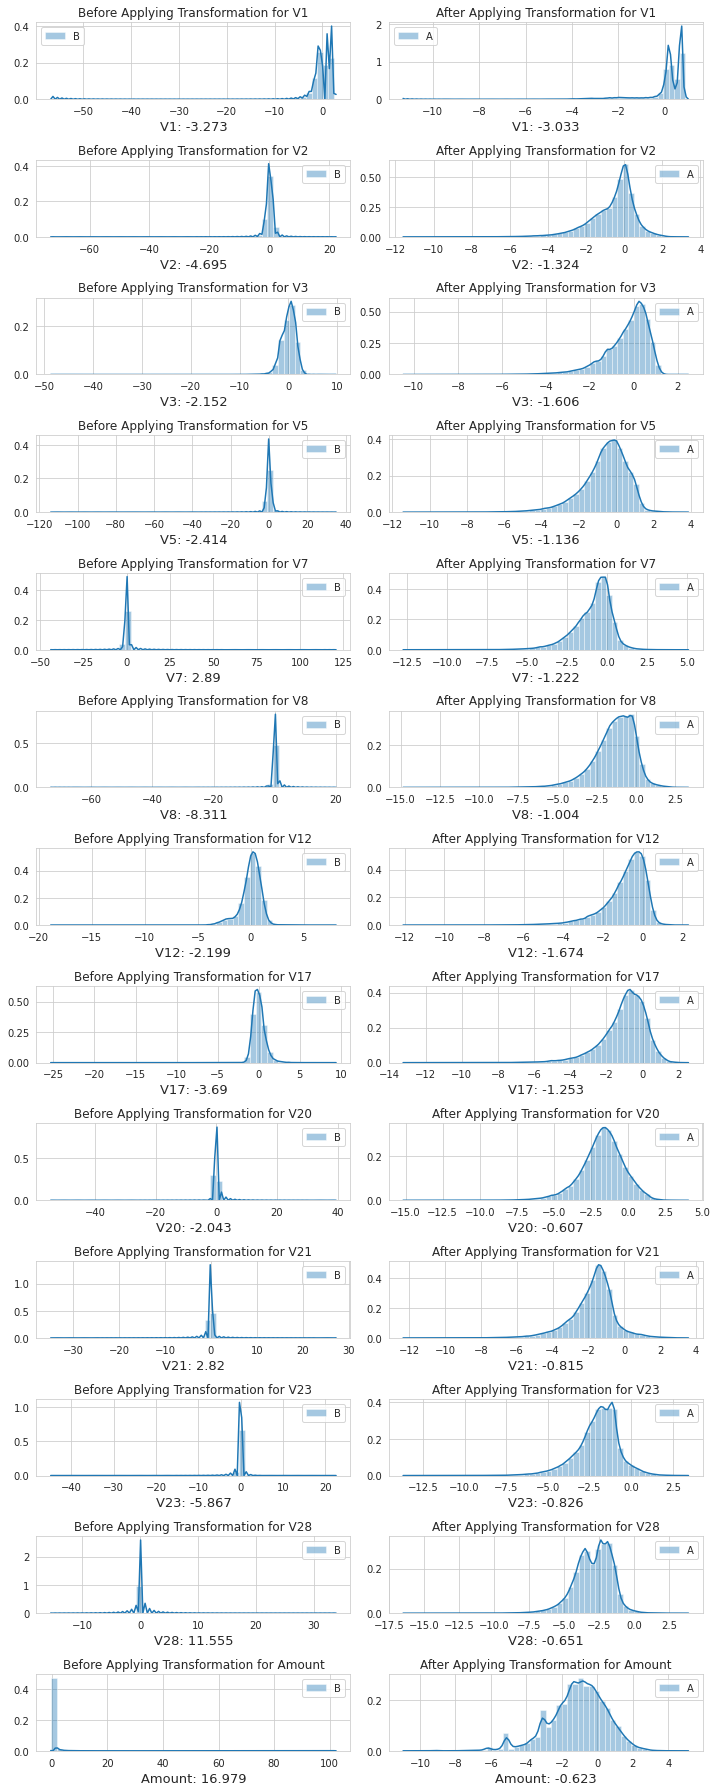

In [ ]:
#Checking distribution Before and After transformation
plt.figure(figsize = (10,25))
counter = 1

for variable in skewed_vars:
  plt.subplot(13,2,counter)
  sns.distplot(credit_card_copy[variable])
  xlab = variable + ': ' + str(round(credit_card_copy[variable].skew(),3))
  plt.xlabel(xlab, fontsize=13)
  plt.legend('Before')
  plt.title('Before Applying Transformation for ' + variable)
  counter +=1

  plt.subplot(13,2,counter)
  sns.distplot(np.log(credit_card_copy[variable]))
  xlab = variable + ': ' + str(round(np.log(credit_card_copy[variable]).skew(),3))
  plt.xlabel(xlab, fontsize=13)
  plt.legend('After')
  plt.title('After Applying Transformation for ' + variable)
  counter +=1

plt.tight_layout()
plt.show()

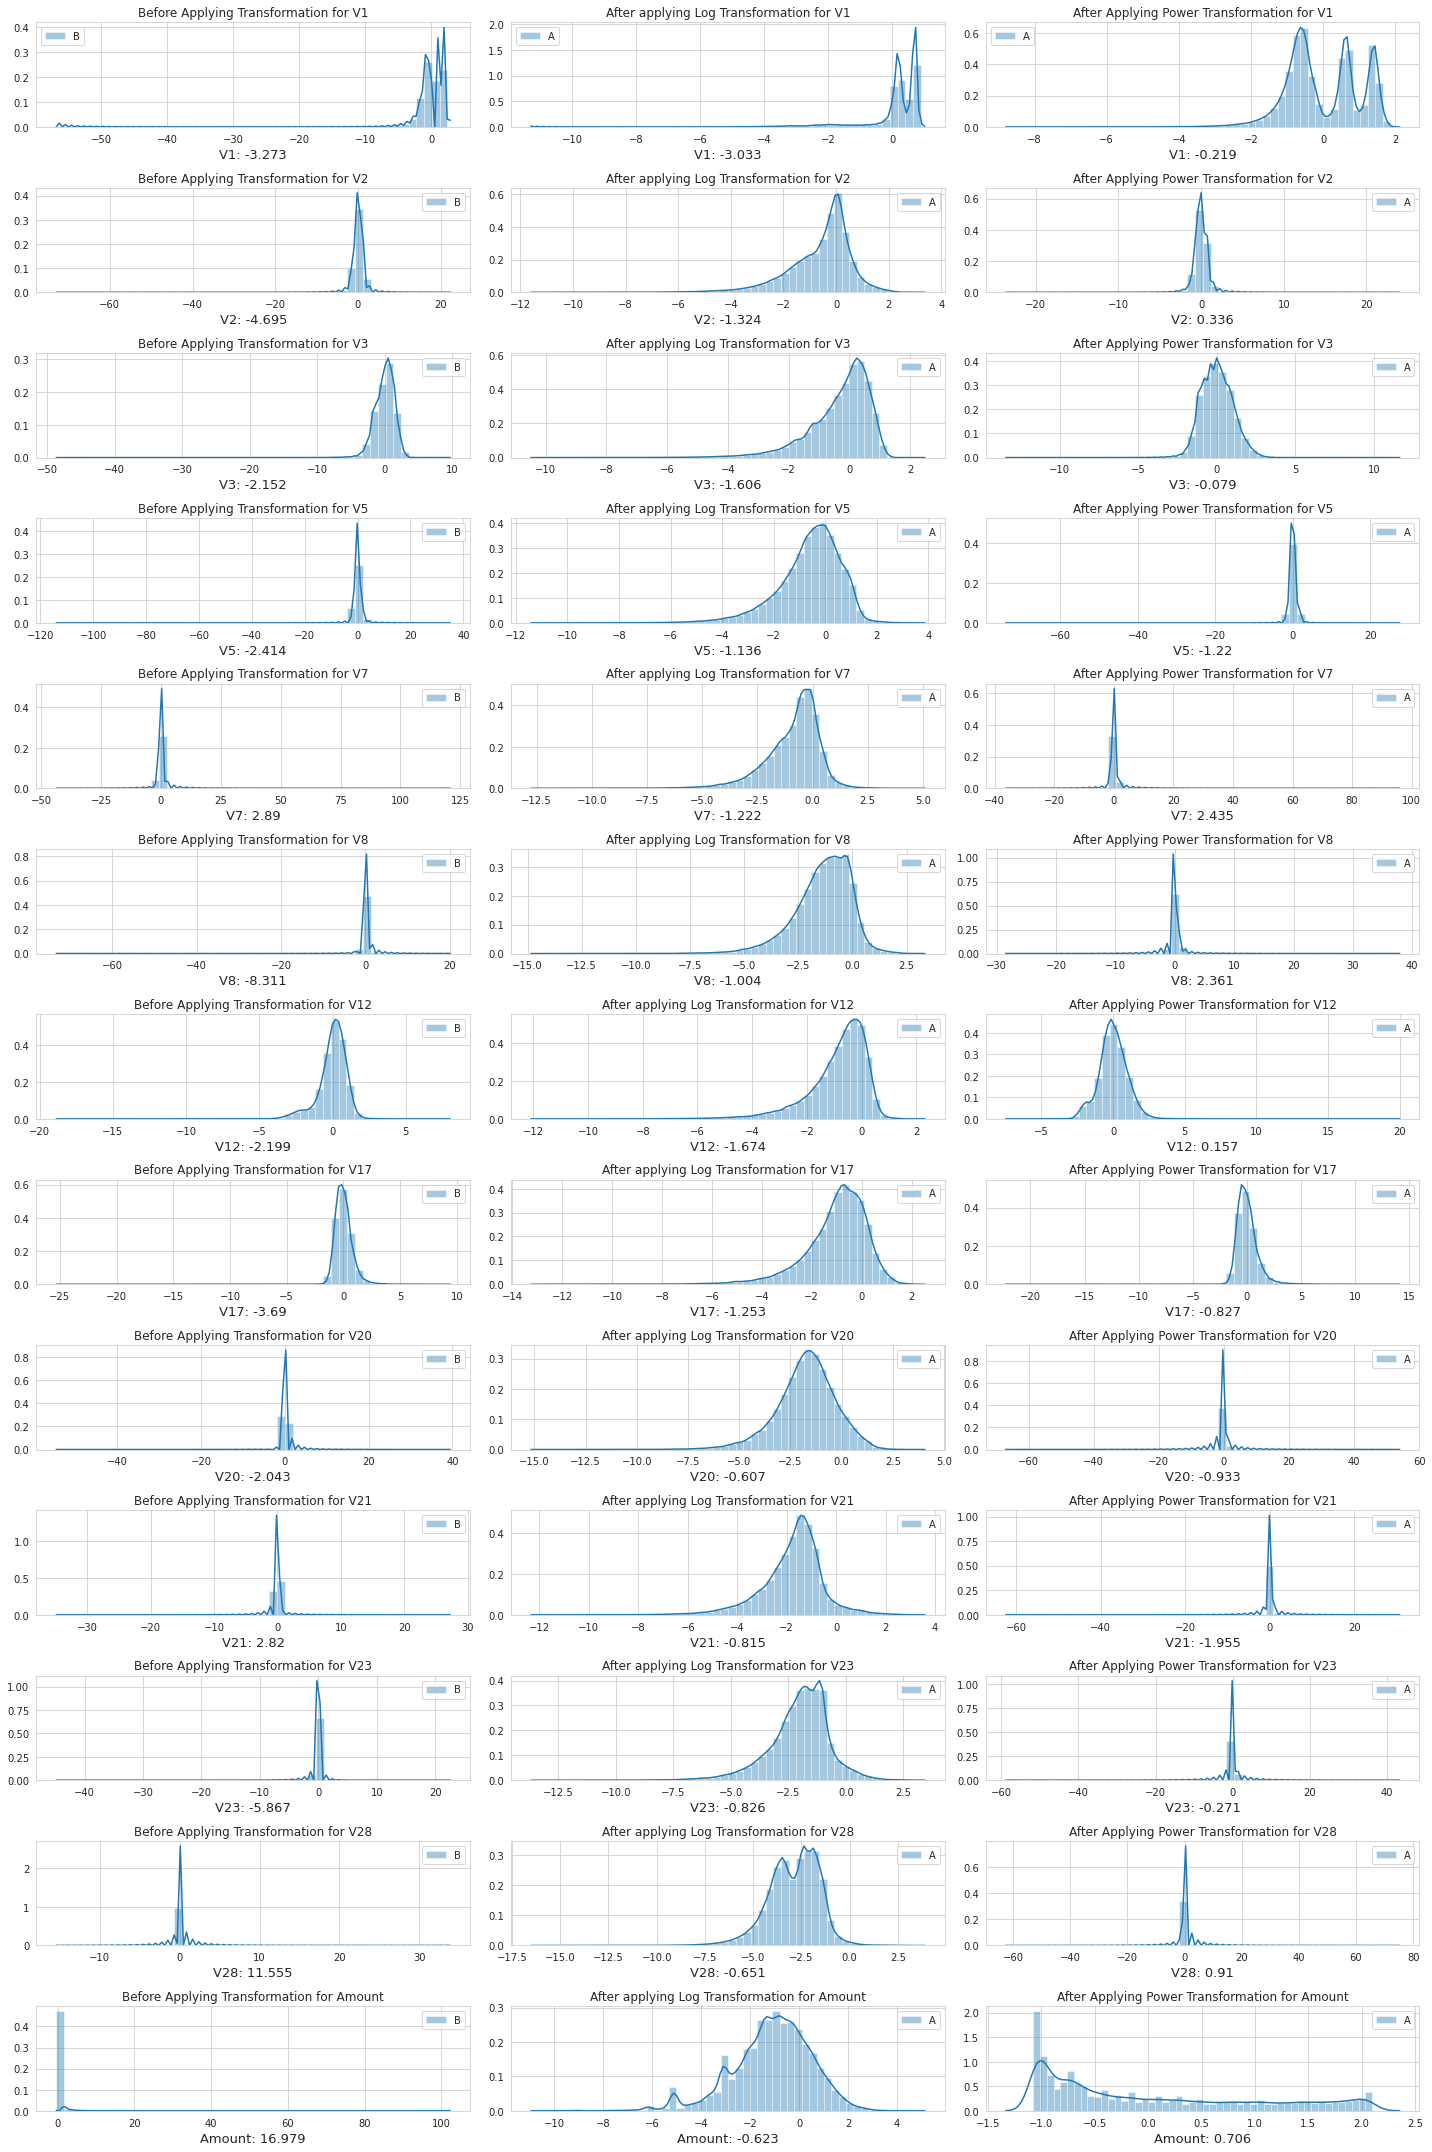

In [ ]:
# Lets also try to apply the Power Transformer and check which method is performing better skewness
top_skewed_data = credit_card_copy[skewed_vars].copy()
pt = PowerTransformer(copy = False) # Choose the default ‘yeo-johnson’ works with positive and negative values
pt.fit_transform(top_skewed_data)

actual_skew = []
log_skew = []
power_transformer = []

#Checking distribution Before and After transformation after applying Power Transformer
plt.figure(figsize = (20,30))
counter = 1
for variable in skewed_vars:

  actual_skew.append(credit_card_copy[variable].skew())
  plt.subplot(13,3,counter)
  sns.distplot(credit_card_copy[variable])
  xlab = variable + ': ' + str(round(credit_card_copy[variable].skew(),3))
  plt.xlabel(xlab, fontsize=13)
  plt.legend('Before')
  plt.title('Before Applying Transformation for ' + variable)
  counter +=1

  log_skew.append(np.log(credit_card_copy[variable]).skew())
  plt.subplot(13,3,counter)
  sns.distplot(np.log(credit_card_copy[variable]))
  xlab = variable + ': ' + str(round(np.log(credit_card_copy[variable]).skew(),3))
  plt.xlabel(xlab, fontsize=13)
  plt.legend('After')
  plt.title('After applying Log Transformation for ' + variable)
  counter +=1

  power_transformer.append(top_skewed_data[variable].skew())
  plt.subplot(13,3,counter)
  sns.distplot(top_skewed_data[variable])
  xlab = variable + ': ' + str(round(top_skewed_data[variable].skew(),3))
  plt.xlabel(xlab, fontsize=13)
  plt.legend('After')
  plt.title('After Applying Power Transformation for ' + variable)
  counter +=1

plt.tight_layout()
plt.show()

In [ ]:
final_dict = { 'Actual_Skew' : actual_skew, 'Log_Skew': log_skew, 'Power_Transformer_Skew': power_transformer }
skew_data_performance = round(pd.DataFrame(final_dict),3)
skew_data_performance.sum() / len(skew_data_performance.index)

Actual_Skew              -0.030769
Log_Skew                 -1.213385
Power_Transformer_Skew    0.107769
dtype: float64

As we can see from the graph as well as from the above average count that the Power_Transformer_Skew is having least amount of skewness so as to handle the skewness Power Transformer seems to be a perfect. And for most of the feature the data is zero centered.

But as we all know so as to apply the power transformer we need to split the data in train and test and then fit the power transformer on the train data and transform it on test data


### Train Test Split

In [ ]:
# Splitting the data in train and test split
credit_X = credit_card.drop(['Class'], axis = 1)
credit_y = credit_card.Class
x_train, x_test, y_train, y_test = train_test_split(credit_X, credit_y, train_size = 0.7, test_size = 0.3, stratify = credit_y.values, random_state = 42)

In [ ]:
print(f"Number of Fraud in Actual Dataset {np.sum(credit_y)} and % of fraud {round((np.sum(credit_y)/len(credit_y))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_train)} and % of fraud {round((np.sum(y_train)/len(y_train))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test)} and % of fraud {round((np.sum(y_test)/len(y_test))*100,4)}")

# As it can be seen below that in train and test we have the fraud splitted in this amount
# and the percentage of Fraud in each split is same

Number of Fraud in Actual Dataset 473 and % of fraud 0.1667
Number of Fraud in Train Dataset 331 and % of fraud 0.1667
Number of Fraud in Train Dataset 142 and % of fraud 0.1668


In [ ]:
# Lets do the standardization on three features
sc = StandardScaler()
x_train[['Time', 'Amount', 'Hour']] = sc.fit_transform(x_train[['Time', 'Amount', 'Hour']])
x_test[['Time', 'Amount', 'Hour']] = sc.transform(x_test[['Time', 'Amount', 'Hour']])

Checking the Skewness of all the data points


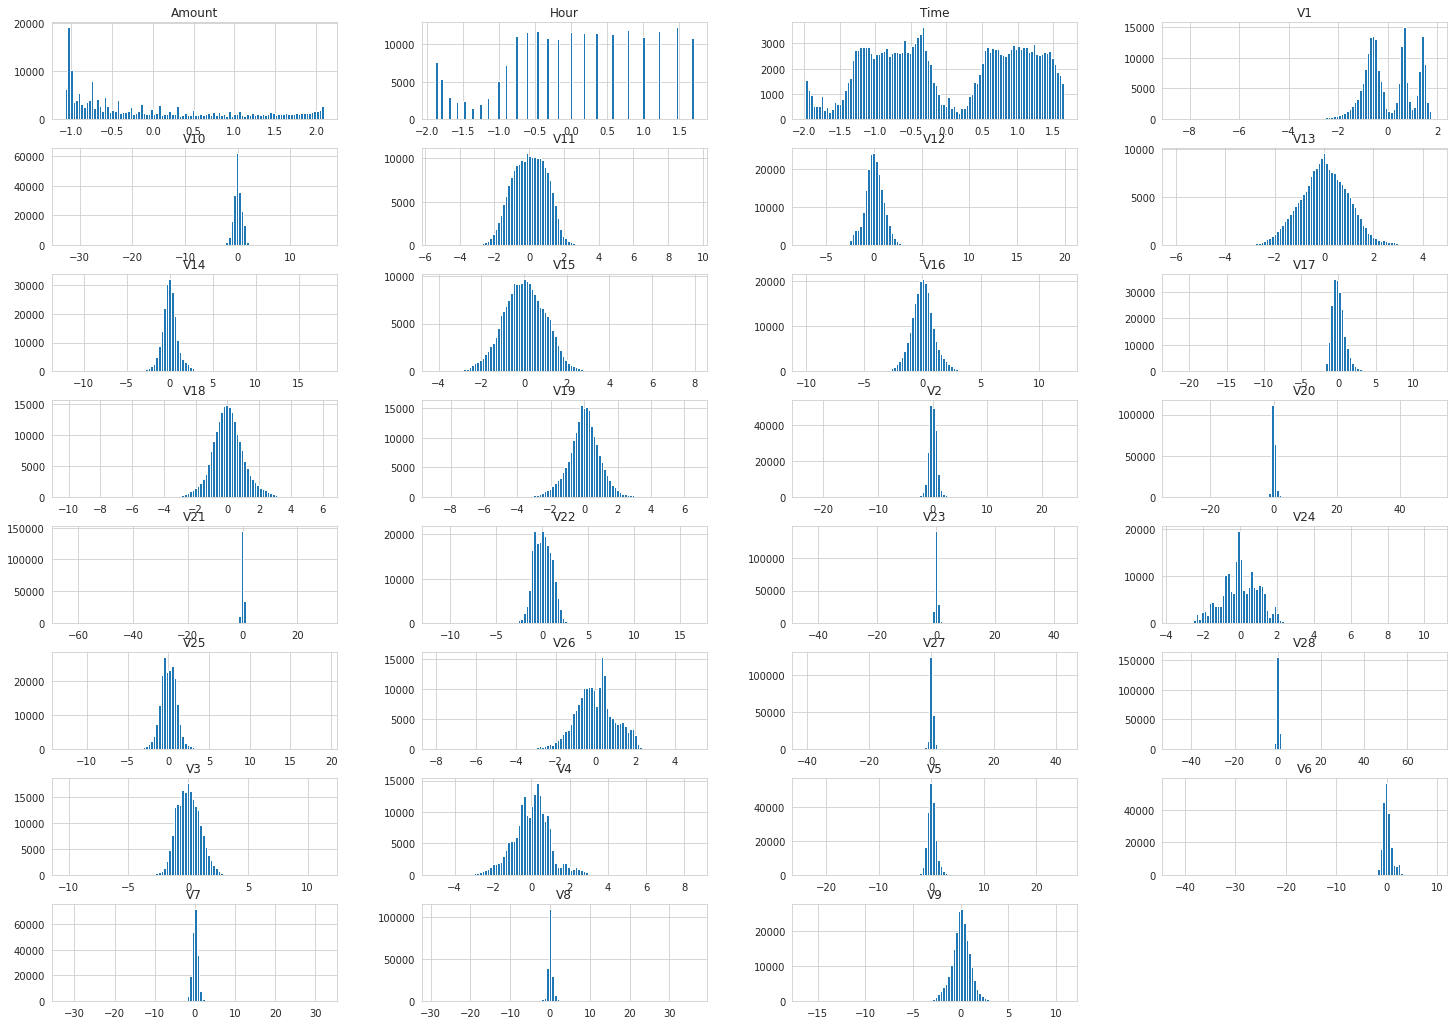

In [ ]:
# Lets handle the skewness of all the features using Power transformer
pt = PowerTransformer(copy = False)
pt.fit_transform(x_train)
pt.transform(x_test)

# Lets see the Skewness after applying the power transformer
print('Checking the Skewness of all the data points')
x_train.hist(bins=100, figsize=(25,18),layout=(8,4))
plt.show()

### Model Building with Unbalanced Data


###Logistic Regression

In [ ]:
# Method to print the confusion matrix
def visConfMat(y_true, y_pred):
  cnf_matrix = confusion_matrix(y_test, y_pred)
  class_names = [0,1]
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()
  
  confusion = confusion_matrix(y_test, y_pred)
  TP = confusion[1,1] # true positive
  TN = confusion[0,0] # true negatives
  FP = confusion[0,1] # false positives
  FN = confusion[1,0] # false negatives
  print('Misclassification Rate: {0}'.format((FP+FN)/ (FP+FN+TP+TN)))
  print("Accuracy:",accuracy_score(y_test, y_pred))
  print("Precision:",precision_score(y_test, y_pred))
  print("Recall:",recall_score(y_test, y_pred))
  print("Negative Predictive Power:", TN/(TN+FP))

In [ ]:
# To check what is the ROC curve and to also check what is the AUC
def draw_roc( actual, probs ):
   fpr, tpr, thresholds = roc_curve( actual, probs,
                                             drop_intermediate = False )
   auc_score = roc_auc_score( actual, probs )
   plt.figure(figsize=(6, 6))
   plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
   plt.plot([0, 1], [0, 1], 'k--')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.05])
   plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
   plt.ylabel('True Positive Rate')
   plt.title('Receiver operating characteristic example')
   plt.legend(loc="lower right")
   plt.show()

   return fpr, tpr, thresholds

In [ ]:
def determine_threshold(model_ref, cut_off_index = None):
  # Getting the predicted probability
  y_pred_prob = model_ref.predict_proba(x_test)[:,1:].reshape(-1)

  # Forming up of datafram that would hold the probablity/different thereshhold data 
  modeldf = pd.DataFrame({'Actual':y_test})
  modeldf['Probability'] = y_pred_prob
  modeldf['Predicted'] = modeldf['Probability'].map(lambda x : 1 if x > 0.5 else 0)
  print("Using the default Threshold Cutoff as 0.5")
  print(modeldf.head())
  print('\n'*3)
  # Forming up of Probablibity for different cutoffs
  numbers = [float(x)/10 for x in range(10)]
  for i in numbers:
      modeldf[i]=  modeldf.Probability.map(lambda x: 1 if x > i else 0)
  print("Probability at Different Thereshold")
  print(modeldf.head())
  print('\n'*3)

  # let's calculate accuracy sensitivity and specificity for various probability cutoffs.
  cutoff_df = pd.DataFrame( columns = ['cutoff','accuracy','sensi','speci'])

  # TP = confusion[1,1] # true positive
  # TN = confusion[0,0] # true negatives
  # FP = confusion[0,1] # false positives
  # FN = confusion[1,0] # false negatives

  num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  for i in num:
    cm1 = confusion_matrix(modeldf.Actual, modeldf[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
  print("Checking the Accuracy, Sensitivity and Specificity for different Threshold")
  print(cutoff_df)
  print('\n'*3)

  #Checking the Optimal Cut-off for the above model
  plt.figure(figsize=(10,8))
  cutoff_df.plot.line(x='cutoff', y=['accuracy','sensi','speci'])
  plt.ylabel('Probability', fontsize = 10)
  plt.title('Checking the Accuracy, Sensitivity Specificity Curve')
  plt.show()

  print('\n'*3)
  if cut_off_index == None:
    cut_off_index = float(input('Enter the Ideal Cutoff Index: '))

  plt.figure(figsize=(10,8))
  cutoff_df.plot.line(x='cutoff', y=['accuracy','sensi','speci'])
  plt.vlines(cut_off_index, ymax=1, ymin=0, colors='r', linestyles='--')
  plt.ylabel('Probability', fontsize = 10)
  plt.title('Optimal Cut-off as :' + str(cut_off_index))
  plt.show()

  print('\n'*3)
  # Lets apply the final cutoff
  modeldf['Opt Cutoff'] = modeldf['Probability'].map(lambda x : 1 if x > cut_off_index else 0)
  print('Lets the ideal Cutoff')
  print(modeldf.head())

  print('\n'*3)
  visConfMat(y_test, modeldf['Opt Cutoff'])

  print('\n'*3)
  print("Some more Metric")
  print(classification_report(y_test, modeldf['Opt Cutoff']))

  print('\n'*3)
  draw_roc(y_test, modeldf['Opt Cutoff'])


In [ ]:
# Logistic Regression model 1
lr = LogisticRegression(random_state=42, warm_start = True, verbose = 1, class_weight = {0:1,1:5} )
lr.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


LogisticRegression(C=1.0, class_weight={0: 1, 1: 5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=True)

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.000219          0
86361        0     0.000353          0
94117        0     0.000217          0
123803       0     0.000854          0
126884       0     0.003710          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.000219          0    1    0  ...    0    0    0    0    0
86361        0     0.000353          0    1    0  ...    0    0    0    0    0
94117        0     0.000217          0    1    0  ...    0    0    0    0    0
123803       0     0.000854          0    1    0  ...    0    0    0    0    0
126884       0     0.003710          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.998802  0

<Figure size 720x576 with 0 Axes>

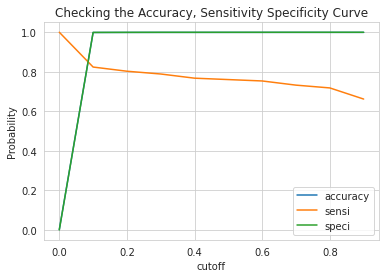

<Figure size 720x576 with 0 Axes>

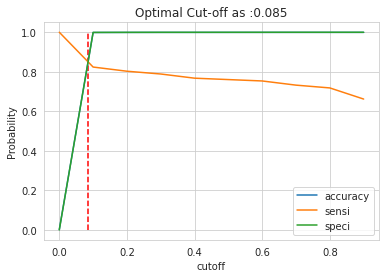





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.000219          0    1  ...    0    0    0           0
86361        0     0.000353          0    1  ...    0    0    0           0
94117        0     0.000217          0    1  ...    0    0    0           0
123803       0     0.000854          0    1  ...    0    0    0           0
126884       0     0.003710          0    1  ...    0    0    0           0

[5 rows x 14 columns]






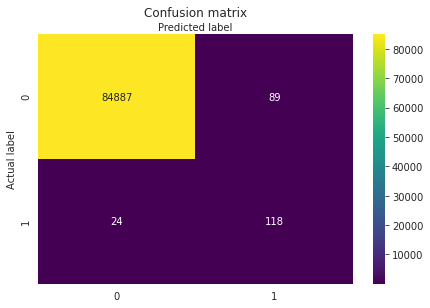

Misclassification Rate: 0.0013275687868605935
Accuracy: 0.9986724312131394
Precision: 0.5700483091787439
Recall: 0.8309859154929577
Negative Predictive Power: 0.9989526454528337




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.57      0.83      0.68       142

    accuracy                           1.00     85118
   macro avg       0.78      0.91      0.84     85118
weighted avg       1.00      1.00      1.00     85118







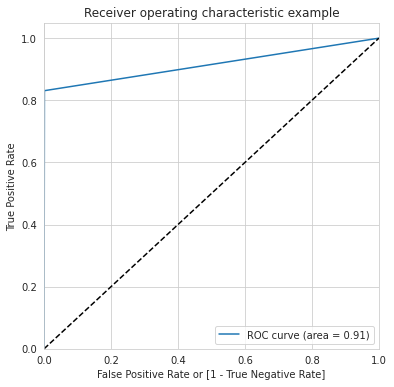

In [ ]:
determine_threshold(lr, 0.085)

**Conclusion**
**Logistic Regression Model 1:**
Here the model is build on unbalanced dataset
*   While looking into the Accuracy, Specificity and Sensitivity Curver it can be seen above that the ideal cutoff was taken as *0.085* 
*   Metrics we have choosen Recall, as Recall will specificy how many actually fraud has happen and using F1 score we will ensure that the Precision and Recall is balanced and also we can see that recall is around ~84% so we would use different Cross Validation Techniques to identify right set of learning Parameters



#### Logistic Regression Cross Validation and Hyperparameter Tuning



In [ ]:
#Finding the best hyperparameter
# Here the main objective is to find the best possible Hyperparameter

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{
                     'C': [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000],
                     'penalty': ["l1","l2"],
                     'class_weight': [None, 'balanced', {0:1,1:5} ]
                }]

# specifying model
model = LogisticRegression(random_state =  42, warm_start=True)
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=True),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced', {0: 1, 1: 5}],
                          'penalty': ['l1', 'l2']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
     

In [ ]:
# Check the cross validation Results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        0.030846      0.007336  ...               NaN              NaN
1        0.616021      0.022761  ...          0.198634         0.030011
2        0.025561      0.001126  ...               NaN              NaN
3        0.766953      0.043951  ...          0.894265         0.007846
4        0.025140      0.000257  ...               NaN              NaN
5        0.623568      0.031156  ...          0.448642         0.019473
6        0.027324      0.000687  ...               NaN              NaN
7        0.686974      0.040296  ...          0.446378         0.020509
8        0.025104      0.000848  ...               NaN              NaN
9        1.013862      0.050851  ...          0.920695         0.004775
10       0.029290      0.000438  ...               NaN              NaN
11       0.722268      0.041289  ...          0.732630         0.014946
12       0.027079      0.000820  ...               NaN              NaN
13       1.008942      0.054594  ...          0.600460         0.027458
14       0.029481      0.001907  ...               NaN              NaN
15       1.388586      0.073426  ...          0.933531         0.005176
16       0.027185      0.000822  ...               NaN              NaN
17       1.172800      0.024898  ...          0.802870         0.014591
18       0.027261      0.002802  ...               NaN              NaN
19       1.605295      0.074675  ...          0.646529         0.022400
20       0.026752      0.001005  ...               NaN              NaN
21       1.553576      0.226877  ...          0.935040         0.004485
22       0.027904      0.000617  ...               NaN              NaN
23       1.499151      0.079708  ...          0.816464         0.015954
24       0.027614      0.000682  ...               NaN              NaN
25       1.684386      0.116602  ...          0.657101         0.019561
26       0.027520      0.001463  ...               NaN              NaN
27       1.540627      0.197135  ...          0.935040         0.004485
28       0.025112      0.000693  ...               NaN              NaN
29       1.606988      0.056427  ...          0.817218         0.015416
30       0.026834      0.000358  ...               NaN              NaN
31       1.826031      0.103806  ...          0.657101         0.019561
32       0.028368      0.004095  ...               NaN              NaN
33       1.578925      0.204153  ...          0.935040         0.004485
34       0.026356      0.000876  ...               NaN              NaN
35       1.590888      0.119553  ...          0.817218         0.015416
36       0.025164      0.000809  ...               NaN              NaN
37       1.758296      0.106272  ...          0.657101         0.019561
38       0.026048      0.000386  ...               NaN              NaN
39       1.513120      0.213626  ...          0.935040         0.004485
40       0.025502      0.000422  ...               NaN              NaN
41       1.615146      0.080165  ...          0.816464         0.016307
42       0.028225      0.001034  ...               NaN              NaN
43       1.718504      0.083000  ...          0.657101         0.019561
44       0.025684      0.001016  ...               NaN              NaN
45       1.470860      0.194327  ...          0.935040         0.004485
46       0.026027      0.000978  ...               NaN              NaN
47       1.463360      0.146200  ...          0.816464         0.016307

[48 rows x 23 columns]

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.912 corresponding to hyperparameters {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}


In [ ]:
# Lets try to use this parameter and build the model
# Logistic Regression model 2
lr_final = LogisticRegression(random_state=42, warm_start = True, verbose = 1, C =  0.1, class_weight = 'balanced', penalty = 'l2' )
lr_final.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=True)

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.005061          0
86361        0     0.017502          0
94117        0     0.017346          0
123803       0     0.020010          0
126884       0     0.115765          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.005061          0    1    0  ...    0    0    0    0    0
86361        0     0.017502          0    1    0  ...    0    0    0    0    0
94117        0     0.017346          0    1    0  ...    0    0    0    0    0
123803       0     0.020010          0    1    0  ...    0    0    0    0    0
126884       0     0.115765          0    1    1  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.827451  0

<Figure size 720x576 with 0 Axes>

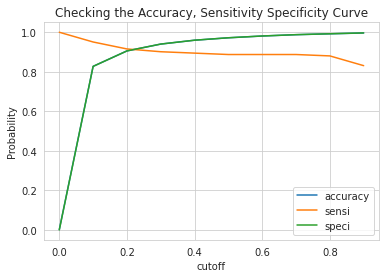

<Figure size 720x576 with 0 Axes>

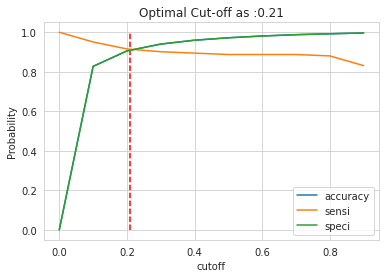





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.005061          0    1  ...    0    0    0           0
86361        0     0.017502          0    1  ...    0    0    0           0
94117        0     0.017346          0    1  ...    0    0    0           0
123803       0     0.020010          0    1  ...    0    0    0           0
126884       0     0.115765          0    1  ...    0    0    0           0

[5 rows x 14 columns]






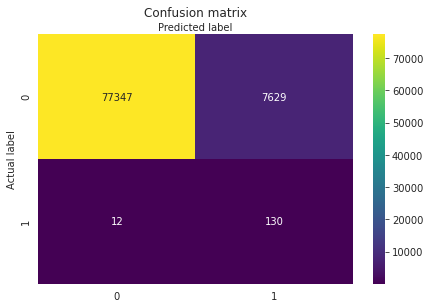

Misclassification Rate: 0.0897694964637327
Accuracy: 0.9102305035362673
Precision: 0.016754736435107616
Recall: 0.9154929577464789
Negative Predictive Power: 0.9102217096591979




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     84976
           1       0.02      0.92      0.03       142

    accuracy                           0.91     85118
   macro avg       0.51      0.91      0.49     85118
weighted avg       1.00      0.91      0.95     85118







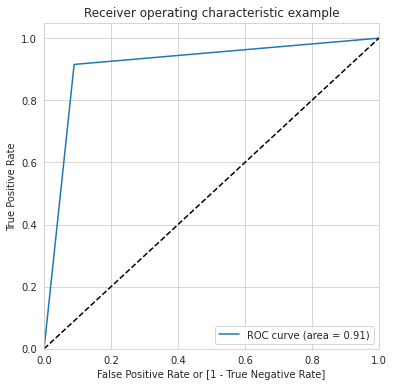

In [ ]:
determine_threshold(lr_final,0.21)

**Conclusion**
1. As we can see after applying the best parameters identified by GridSearch CV, the model Recall increased a lot to ~92%
2. We have choosen Recall as we wanted to make sure there are very less number of Fraud cases which should not be misclassified, but there can be increase in False Negative ( Transaction flagged as Fraud, but actually there is no fraud happened at all ) as it can be later verified from the customer by reaching out to there whether there were some transaction which are not not known to customer
3. RUC also increased to 0.91 ( hence there is an increase in the More number of Fraud cases )

### KNN

In [ ]:
# As KNN is quite Time consuming, if we try to fit the KNN on the whole dataset.
# Lets try to get the first 15k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 21.5k, then then the 70% of that is around 15k and 6.5k for the test set
x_train_temp = x_train[0:15000]
y_train_temp = y_train[0:15000]
x_test_temp  = x_test[-6500:-1]
y_test_temp  = y_test[-6500:-1]

In [ ]:
print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

Number of Fraud in Train Dataset 19 and % of fraud 0.1267
Number of Fraud in Train Dataset 9 and % of fraud 0.1385


In [ ]:
# KNN model 1
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(x_train_temp, y_train_temp)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[6490    0]
 [   0    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6490
           1       1.00      1.00      1.00         9

    accuracy                           1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499



**Conclusion**
1. As we can see the Recall is 1 , so we would need see how this needs to be looked into, but the only small problem is our current dataset is very less as well as the proportion of the Fraud dataset is quite less, so lets try to get the ideal neighbors value

In [ ]:
# Identifying the ideal K Values
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    print(f'Trying for the K Neighbors: { i }')
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(x_train_temp, y_train_temp)
    pred_i = knn.predict(x_test_temp)
    error.append(np.mean(pred_i != y_test_temp))
    done = time.time()
    elapsed = done - start
    print(f'Total Time Taken to Train: { round(elapsed,2)} seconds')
    print('========================================================\n')

Trying for the K Neighbors: 1
Total Time Taken to Train: 8.91 seconds

Trying for the K Neighbors: 2
Total Time Taken to Train: 10.0 seconds

Trying for the K Neighbors: 3
Total Time Taken to Train: 10.31 seconds

Trying for the K Neighbors: 4
Total Time Taken to Train: 10.8 seconds

Trying for the K Neighbors: 5
Total Time Taken to Train: 6.94 seconds

Trying for the K Neighbors: 6
Total Time Taken to Train: 5.39 seconds

Trying for the K Neighbors: 7
Total Time Taken to Train: 5.49 seconds

Trying for the K Neighbors: 8
Total Time Taken to Train: 5.51 seconds

Trying for the K Neighbors: 9
Total Time Taken to Train: 5.6 seconds

Trying for the K Neighbors: 10
Total Time Taken to Train: 5.6 seconds

Trying for the K Neighbors: 11
Total Time Taken to Train: 5.6 seconds

Trying for the K Neighbors: 12
Total Time Taken to Train: 5.59 seconds

Trying for the K Neighbors: 13
Total Time Taken to Train: 5.71 seconds

Trying for the K Neighbors: 14
Total Time Taken to Train: 5.72 seconds

Try

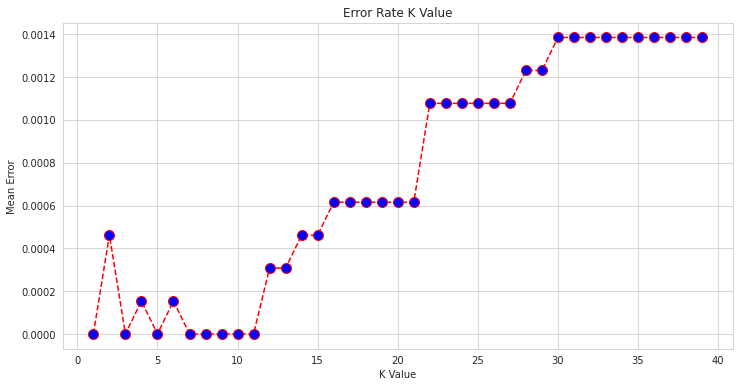

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

**Conclusion**
From the output we can see that the mean error is zero when the value of the K is between 7 and 12, so lets try to fit using that and lets increase the dataset % and lets try again, but lets try with a bigger dataset and lets validate the above theory

In [ ]:
# As KNN is quite Time consuming, if we try to fit the KNN on the whole dataset.
# Lets try to get the first 70k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 1lkh, then then the 70% of that is around 70k and 30k for the test set
x_train_temp = x_train[0:70000]
y_train_temp = y_train[0:70000]
x_test_temp  = x_test[-30000:-1]
y_test_temp  = y_test[-30000:-1]

In [ ]:
print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

Number of Fraud in Train Dataset 99 and % of fraud 0.1414
Number of Fraud in Train Dataset 46 and % of fraud 0.1533


In [ ]:
# KNN model 2
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[29950     3]
 [   15    31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.91      0.67      0.78        46

    accuracy                           1.00     29999
   macro avg       0.96      0.84      0.89     29999
weighted avg       1.00      1.00      1.00     29999



**Conclusion**
1. As we can see above the recall fall down to 0.67 and Precision is 0.91 so lets try to improve the same

In [ ]:
# Identifying the ideal K Values
# Lets try to get the ideal values for neighbors on 1lkh recordss
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    print(f'Trying for the K Neighbors: { i }')
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(x_train_temp, y_train_temp)
    pred_i = knn.predict(x_test_temp)
    error.append(np.mean(pred_i != y_test_temp))
    done = time.time()
    elapsed = done - start
    print(f'Total Time Taken to Train: { round(elapsed,2)} seconds')
    print('========================================================\n')

Trying for the K Neighbors: 1
Total Time Taken to Train: 53.82 seconds

Trying for the K Neighbors: 2
Total Time Taken to Train: 66.29 seconds

Trying for the K Neighbors: 3
Total Time Taken to Train: 72.46 seconds

Trying for the K Neighbors: 4
Total Time Taken to Train: 77.11 seconds

Trying for the K Neighbors: 5
Total Time Taken to Train: 80.89 seconds

Trying for the K Neighbors: 6
Total Time Taken to Train: 84.0 seconds

Trying for the K Neighbors: 7
Total Time Taken to Train: 86.31 seconds

Trying for the K Neighbors: 8
Total Time Taken to Train: 88.02 seconds

Trying for the K Neighbors: 9
Total Time Taken to Train: 90.03 seconds

Trying for the K Neighbors: 10
Total Time Taken to Train: 91.9 seconds

Trying for the K Neighbors: 11
Total Time Taken to Train: 92.87 seconds

Trying for the K Neighbors: 12
Total Time Taken to Train: 92.26 seconds

Trying for the K Neighbors: 13
Total Time Taken to Train: 92.81 seconds

Trying for the K Neighbors: 14
Total Time Taken to Train: 93.8

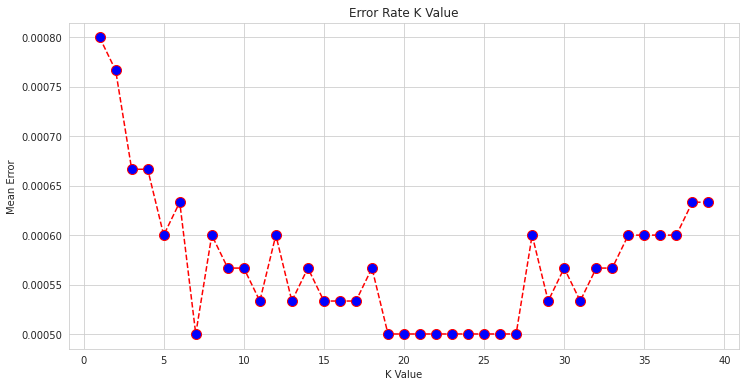

In [ ]:
# lets decide whats the ideal k Value
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

**Conclusion**
From the output we can see that the mean error is zero when the value of the K is between 19 and 27, so lets try some other parameters also and also lets check whether the recall rate increased or not

In [ ]:
# KNN model 3
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[29949     4]
 [   11    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.90      0.76      0.82        46

    accuracy                           1.00     29999
   macro avg       0.95      0.88      0.91     29999
weighted avg       1.00      1.00      1.00     29999



**Conclusion**
- So when we choose 25 as neighbors as we can see on the same dataset of 1lkh the recall rate increased 0.67 to 0.76 so lets try to push a little bit further

In [ ]:
# KNN model 4
# Lets to see if using different algorithm leads to increase in the recall rate or not
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, algorithm = 'kd_tree')
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))


print('\n\n')
print('====================================================================')
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, algorithm = 'ball_tree')
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, algorithm = 'brute')
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[29949     4]
 [   11    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.90      0.76      0.82        46

    accuracy                           1.00     29999
   macro avg       0.95      0.88      0.91     29999
weighted avg       1.00      1.00      1.00     29999




[[29949     4]
 [   11    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.90      0.76      0.82        46

    accuracy                           1.00     29999
   macro avg       0.95      0.88      0.91     29999
weighted avg       1.00      1.00      1.00     29999




[[29949     4]
 [   11    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.90      0.76      0.82        46

    accuracy                           1.00     29999
   macro avg       0.95      

**Conclusion**
- As it can be seen above there is no significant increase in the recall. Its the same for all the algorithm

In [ ]:
# KNN model 5
# Lets to see if using different distance metrics leads to increase in the recall rate or not
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, metric = 'euclidean')
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')

knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, metric = 'manhattan')
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')

knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, metric = 'chebyshev')
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')

knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, metric = 'minkowski')
knn.fit(x_train_temp, y_train_temp)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[29949     4]
 [   11    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.90      0.76      0.82        46

    accuracy                           1.00     29999
   macro avg       0.95      0.88      0.91     29999
weighted avg       1.00      1.00      1.00     29999




[[29949     4]
 [   12    34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.89      0.74      0.81        46

    accuracy                           1.00     29999
   macro avg       0.95      0.87      0.90     29999
weighted avg       1.00      1.00      1.00     29999




[[29950     3]
 [   17    29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.91      0.63      0.74        46

    accuracy                           1.00     29999
   macro avg       0.95      

**Conclusion**
- As it can be seen that the recall rate is indeed changing for different distance algorithm and euclidean and minkowski its same as the minkowaski with p = 2 is equivalent to eucludean, lets try with higher p

In [ ]:
p = range(3,10,5)

for elem in p:
  print(f'p = { elem }')
  knn = KNeighborsClassifier(n_neighbors=25, p = elem, n_jobs=-1, metric = 'minkowski')
  knn.fit(x_train_temp, y_train_temp)

  y_pred = knn.predict(x_test_temp)
  print(confusion_matrix(y_test_temp, y_pred))
  print(classification_report(y_test_temp, y_pred))

  print('\n\n')
  print('====================================================================')

p = 3
[[29949     4]
 [   12    34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.89      0.74      0.81        46

    accuracy                           1.00     29999
   macro avg       0.95      0.87      0.90     29999
weighted avg       1.00      1.00      1.00     29999




p = 8
[[29950     3]
 [   15    31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.91      0.67      0.78        46

    accuracy                           1.00     29999
   macro avg       0.96      0.84      0.89     29999
weighted avg       1.00      1.00      1.00     29999




p = 13


**Conclusion**
With the increase in p, the time taken to execute the query is lot more and also the recall percentage is decreasing. Hence we would consider the p=2 (default) and now lets do the validation testing with our derived parameters

#### KNN Cross Validation


In [ ]:
# Here the objective is to check whether the model is behaving fine or not for the taken sample
# check whether the validation accuracy is fluctuating or not a lot

# Using the Fold as 5
folds = StratifiedKFold(n_splits=15, random_state=42)

# specifying model
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, metric = 'euclidean')

# cross_val_score
scores = cross_val_score(model, x_train_temp, y_train_temp, cv = folds, n_jobs = -1 , verbose = 1, scoring= 'recall')
print(*scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.5 0.8571428571428571 0.7142857142857143 0.5714285714285714 0.8571428571428571 0.7142857142857143 0.5714285714285714 0.7142857142857143 0.8571428571428571 0.7142857142857143 0.3333333333333333 0.5 0.5 0.8333333333333334 1.0


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.3min finished


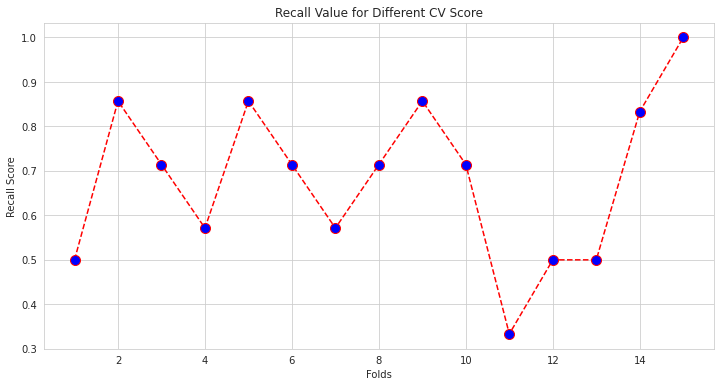

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,16), scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Recall Value for Different CV Score')
plt.xlabel('Folds')
plt.ylabel('Recall Score')
plt.show()

**Conclusion**
- As we can see from the cross val score output the recall is staying between 0.6-0.8 so we would conclude that this is not flucting a lot and we would consider this and we would move ahead with the fitting with the actual data

In [ ]:
# KNN model final model
knn_final = KNeighborsClassifier(n_neighbors=25, n_jobs=-1, metric = 'euclidean')
knn_final.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='uniform')

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0          0.0          0
86361        0          0.0          0
94117        0          0.0          0
123803       0          0.0          0
126884       0          0.0          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0          0.0          0    0    0  ...    0    0    0    0    0
86361        0          0.0          0    0    0  ...    0    0    0    0    0
94117        0          0.0          0    0    0  ...    0    0    0    0    0
123803       0          0.0          0    0    0  ...    0    0    0    0    0
126884       0          0.0          0    0    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.995077  0.830986  0.995352
0.1     0.1  0.999319  0

<Figure size 720x576 with 0 Axes>

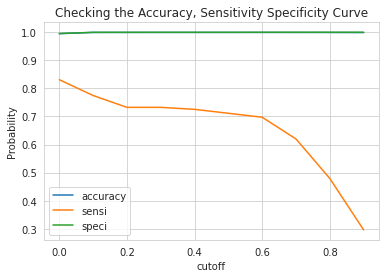





Enter the Ideal Cutoff Index: 0.2


<Figure size 720x576 with 0 Axes>

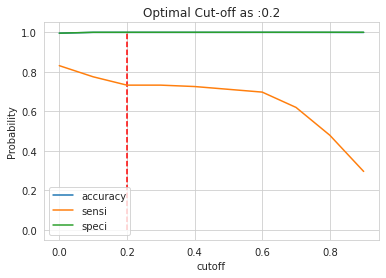





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0          0.0          0    0  ...    0    0    0           0
86361        0          0.0          0    0  ...    0    0    0           0
94117        0          0.0          0    0  ...    0    0    0           0
123803       0          0.0          0    0  ...    0    0    0           0
126884       0          0.0          0    0  ...    0    0    0           0

[5 rows x 14 columns]






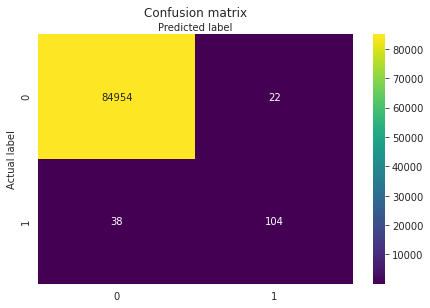

Misclassification Rate: 0.0007049037806339434
Accuracy: 0.9992950962193661
Precision: 0.8253968253968254
Recall: 0.7323943661971831
Negative Predictive Power: 0.9997411033703634




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.83      0.73      0.78       142

    accuracy                           1.00     85118
   macro avg       0.91      0.87      0.89     85118
weighted avg       1.00      1.00      1.00     85118







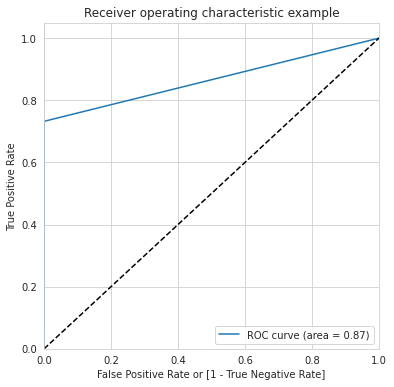

In [ ]:
determine_threshold(knn_final, 0.2)

**Conclusion**
- As it can be seen that the AUC-ROC Score has dropped and the recall is also less as compared to the logistic Regression

### SVM
- Lets try the similar experiment as we did for KNN and lets see how the model behaves

In [ ]:
# Lets try to get the first 70k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 1lkh, then then the 70% of that is around 70k and 30k for the test set
x_train_temp = x_train[0:70000]
y_train_temp = y_train[0:70000]
x_test_temp  = x_test[-30000:-1]
y_test_temp  = y_test[-30000:-1]

print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

Number of Fraud in Train Dataset 99 and % of fraud 0.1414
Number of Fraud in Train Dataset 46 and % of fraud 0.1533


In [ ]:
# SVM Model 1
svm_model = svm.SVC(kernel='linear', random_state=42) # Lets try with Linear Kernal
svm_model.fit(x_train_temp, y_train_temp)

y_pred = svm_model.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')

print('Checking for the original df')
y_pred = svm_model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[29950     3]
 [   11    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.92      0.76      0.83        46

    accuracy                           1.00     29999
   macro avg       0.96      0.88      0.92     29999
weighted avg       1.00      1.00      1.00     29999




Checking for the original df
[[84964    12]
 [   44    98]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.89      0.69      0.78       142

    accuracy                           1.00     85118
   macro avg       0.95      0.84      0.89     85118
weighted avg       1.00      1.00      1.00     85118



#### SVM Cross Validation and Hyperparameter Tuning


In [ ]:
# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation
hyper_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


model = svm.SVC(random_state=42)
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(x_train_temp, y_train_temp)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 115.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=1)

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.777 corresponding to hyperparameters {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
# SVM Model 2, lets the check the recall value now
svm_model = svm.SVC(random_state=42, C= 1, gamma = 0.001, kernel = 'rbf')
svm_model.fit(x_train_temp, y_train_temp)

y_pred = svm_model.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')

print('Checking for the original df')
y_pred = svm_model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[29948     5]
 [    9    37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.88      0.80      0.84        46

    accuracy                           1.00     29999
   macro avg       0.94      0.90      0.92     29999
weighted avg       1.00      1.00      1.00     29999




Checking for the original df
[[84957    19]
 [   32   110]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.85      0.77      0.81       142

    accuracy                           1.00     85118
   macro avg       0.93      0.89      0.91     85118
weighted avg       1.00      1.00      1.00     85118



Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.000267          0
86361        0     0.000419          0
94117        0     0.000429          0
123803       0     0.000457          0
126884       0     0.000428          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.000267          0    1    0  ...    0    0    0    0    0
86361        0     0.000419          0    1    0  ...    0    0    0    0    0
94117        0     0.000429          0    1    0  ...    0    0    0    0    0
123803       0     0.000457          0    1    0  ...    0    0    0    0    0
126884       0     0.000428          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.999389  0

<Figure size 720x576 with 0 Axes>

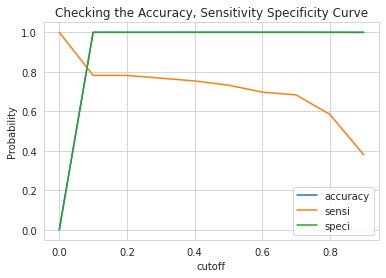

<Figure size 720x576 with 0 Axes>

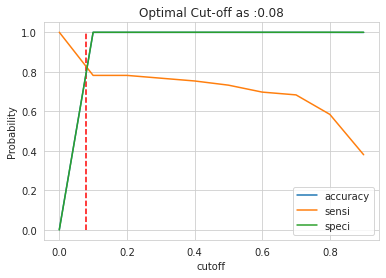





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.000267          0    1  ...    0    0    0           0
86361        0     0.000419          0    1  ...    0    0    0           0
94117        0     0.000429          0    1  ...    0    0    0           0
123803       0     0.000457          0    1  ...    0    0    0           0
126884       0     0.000428          0    1  ...    0    0    0           0

[5 rows x 14 columns]






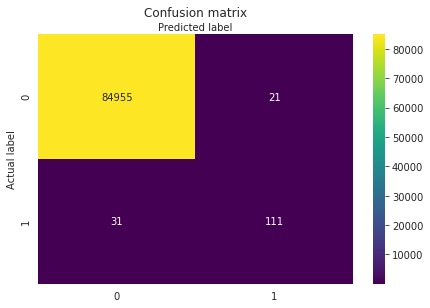

Misclassification Rate: 0.000610916609882751
Accuracy: 0.9993890833901172
Precision: 0.8409090909090909
Recall: 0.7816901408450704
Negative Predictive Power: 0.9997528713989833




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.84      0.78      0.81       142

    accuracy                           1.00     85118
   macro avg       0.92      0.89      0.90     85118
weighted avg       1.00      1.00      1.00     85118







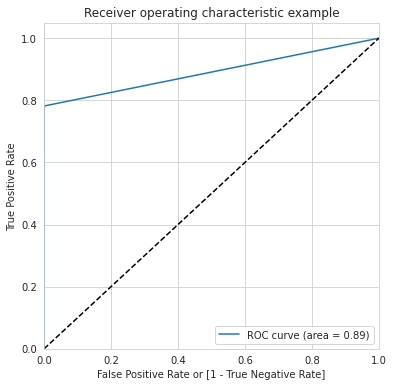

In [ ]:
svm_model = svm.SVC(random_state=42, C= 1, gamma = 0.001, kernel = 'rbf', probability=True)
svm_model.fit(x_train, y_train)

determine_threshold(svm_model,0.08)

### Random Forest

In [ ]:
#Random Forest Classifier Model 1
rfc = RandomForestClassifier(random_state=42)

In [ ]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0         0.00          0
86361        0         0.00          0
94117        0         0.00          0
123803       0         0.01          0
126884       0         0.00          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0         0.00          0    0    0  ...    0    0    0    0    0
86361        0         0.00          0    0    0  ...    0    0    0    0    0
94117        0         0.00          0    0    0  ...    0    0    0    0    0
123803       0         0.01          0    1    0  ...    0    0    0    0    0
126884       0         0.00          0    0    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.976303  0.866197  0.976487
0.1     0.1  0.999354  0

<Figure size 720x576 with 0 Axes>

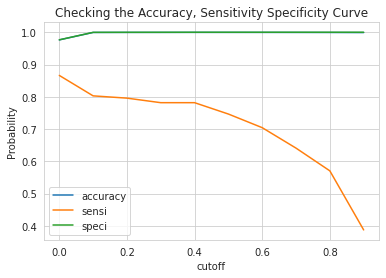





Enter the Ideal Cutoff Index: 0.1


<Figure size 720x576 with 0 Axes>

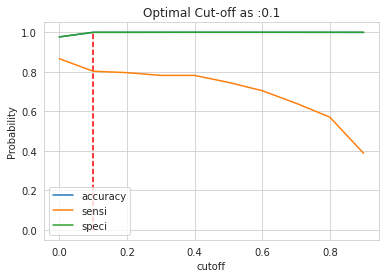





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0         0.00          0    0  ...    0    0    0           0
86361        0         0.00          0    0  ...    0    0    0           0
94117        0         0.00          0    0  ...    0    0    0           0
123803       0         0.01          0    1  ...    0    0    0           0
126884       0         0.00          0    0  ...    0    0    0           0

[5 rows x 14 columns]






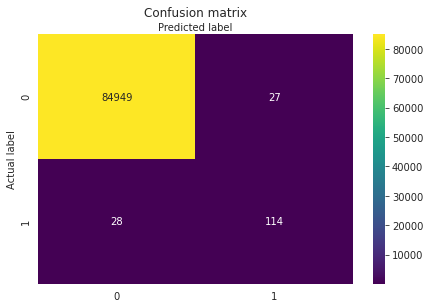

Misclassification Rate: 0.0006461617989144482
Accuracy: 0.9993538382010856
Precision: 0.8085106382978723
Recall: 0.8028169014084507
Negative Predictive Power: 0.9996822632272642




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.81      0.80      0.81       142

    accuracy                           1.00     85118
   macro avg       0.90      0.90      0.90     85118
weighted avg       1.00      1.00      1.00     85118







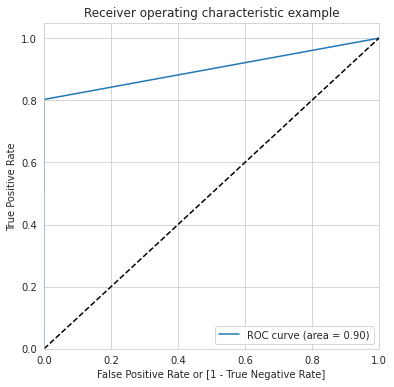

In [ ]:
determine_threshold(rfc, 0.1)

#### Random Forest Cross Validation and Hyperparameter Tuning


#### 1. Tuning 'max_depth' and 'n_estimators' 

In [ ]:
#Finding the best hyperparameter
# Here the main objective is to find the best possible Hyperparameter

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{
                     'max_depth': range(2, 23, 5),
                     'n_estimators': range(10, 200, 40)
                }]

# specifying model
model = RandomForestClassifier(random_state=42)
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 104.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                           

In [ ]:
# Check the cross validation Results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        2.349437      0.028321  ...          0.558911         0.018727
1       11.568343      0.090146  ...          0.573270         0.028018
2       20.973758      0.099710  ...          0.572516         0.028050
3       30.724829      0.124975  ...          0.560429         0.028404
4       40.521774      0.125598  ...          0.563451         0.031078
5        7.758137      0.067252  ...          0.796830         0.013763
6       38.755673      0.196978  ...          0.805898         0.015126
7       70.676172      0.314922  ...          0.805137         0.014615
8      104.715016      1.775910  ...          0.808165         0.019227
9      138.235424      0.345866  ...          0.808165         0.018317
10      13.202185      0.175986  ...          0.863299         0.014736
11      65.695546      0.545965  ...          0.857253         0.012469
12     117.389233      0.390883  ...          0.856495         0.012171
13     169.948941      0.811861  ...          0.855740         0.011035
14     213.380196      7.039811  ...          0.855740         0.013369
15      14.251630      0.425600  ...          0.919191         0.007707
16      72.722970      0.666136  ...          0.919191         0.011048
17     135.668162      1.811929  ...          0.920695         0.009244
18     199.960159      1.048562  ...          0.919940         0.007692
19     259.422730      3.465195  ...          0.920695         0.010404
20      14.852101      0.631516  ...          0.941844         0.003832
21      77.219209      0.724885  ...          0.993962         0.003848
22     141.921218      1.259090  ...          0.994714         0.005118
23     209.495488      2.635688  ...          0.999245         0.001509
24     264.220748     24.537418  ...          0.999245         0.001509

[25 rows x 22 columns]

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.773 corresponding to hyperparameters {'max_depth': 17, 'n_estimators': 50}


#### 2. Tuning max_features, min_sample_leaf, min_samples_split

In [ ]:
#Finding the best hyperparameter
# Here the main objective is to find the best possible Hyperparameter

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{
                    #  'max_features': [2, 5, 12, 20, 28, 24, 35],
                    #  'min_samples_leaf': range(10, 1000, 200),
                    # 'min_samples_split': range(10, 1000, 200)

                     'max_features': range(2,31,10),
                     'min_samples_leaf': range(10, 1000, 500),
                    'min_samples_split': range(10, 1000, 500)
                 
                }]

# specifying model
model = RandomForestClassifier(n_estimators = 50, max_depth = 17, random_state=42)
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 70.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=17,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              

In [ ]:
# Check the cross validation Results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       30.166389      0.605595  ...          0.699403         0.032098
1       29.452430      0.915885  ...          0.558162         0.038127
2       21.537229      0.632017  ...          0.000000         0.000000
3       21.569103      0.634626  ...          0.000000         0.000000
4      172.491604      2.463407  ...          0.803622         0.016400
5      169.762401      3.463609  ...          0.706941         0.015163
6      111.601126      2.130046  ...          0.000000         0.000000
7      111.780004      1.857961  ...          0.000000         0.000000
8      305.095424      5.600745  ...          0.819488         0.016409
9      302.553564      7.557622  ...          0.745480         0.027376
10     196.826258      4.707711  ...          0.000000         0.000000
11     195.508269      6.356803  ...          0.000000         0.000000

[12 rows x 23 columns]

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.791 corresponding to hyperparameters {'max_features': 22, 'min_samples_leaf': 10, 'min_samples_split': 10}


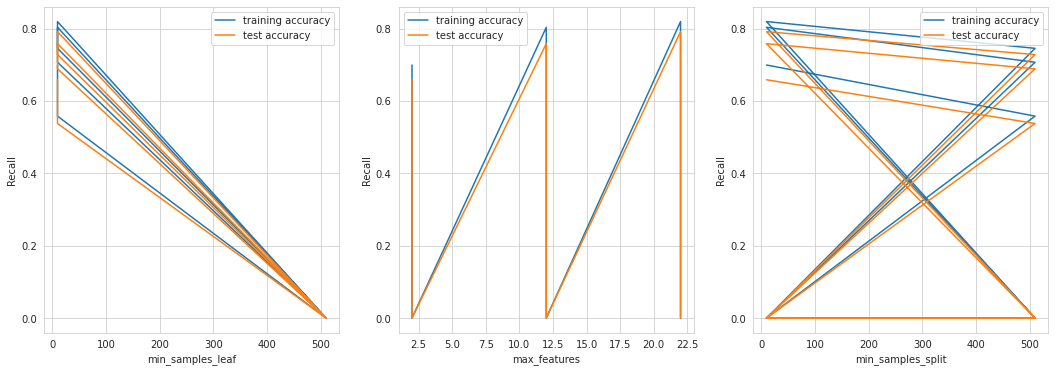

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(cv_results["param_min_samples_leaf"], 
         cv_results["mean_train_score"], 
         label="training accuracy")
plt.plot(cv_results["param_min_samples_leaf"], 
         cv_results["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,3,2)
# plotting accuracies with max_features
plt.plot(cv_results["param_max_features"], 
         cv_results["mean_train_score"], 
         label="training accuracy")
plt.plot(cv_results["param_max_features"], 
         cv_results["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,3,3)
# plotting accuracies with min_samples_split
plt.plot(cv_results["param_min_samples_split"], 
         cv_results["mean_train_score"], 
         label="training accuracy")
plt.plot(cv_results["param_min_samples_split"], 
         cv_results["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()

plt.show()

#### Fitting the model with obtained hyperparameters

In [ ]:
#Random Forest Classifier Final Model
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 17, min_samples_leaf=10, min_samples_split=10, max_features=22 ,random_state=42, 
                             oob_score=True, n_jobs=-1, class_weight = {0:1, 1:5}, verbose = 1, warm_start = True)

In [ ]:
rfc.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 5},
                       criterion='gini', max_depth=17, max_features=22,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=1,
                       warm_start=True)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.3s finished


Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.000006          0
86361        0     0.000003          0
94117        0     0.000006          0
123803       0     0.000003          0
126884       0     0.000112          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.000006          0    1    0  ...    0    0    0    0    0
86361        0     0.000003          0    1    0  ...    0    0    0    0    0
94117        0     0.000006          0    1    0  ...    0    0    0    0    0
123803       0     0.000003          0    1    0  ...    0    0    0    0    0
126884       0     0.000112          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.005674  1.000000  0.004013
0.1     0.1  0.998402  0

<Figure size 720x576 with 0 Axes>

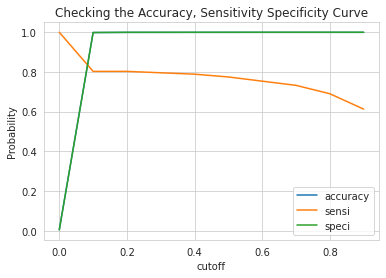





Enter the Ideal Cutoff Index: 0.09


<Figure size 720x576 with 0 Axes>

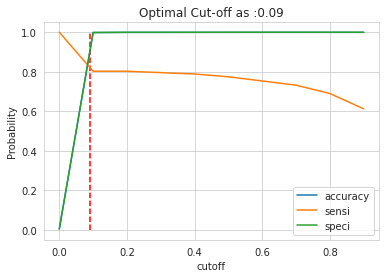





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.000006          0    1  ...    0    0    0           0
86361        0     0.000003          0    1  ...    0    0    0           0
94117        0     0.000006          0    1  ...    0    0    0           0
123803       0     0.000003          0    1  ...    0    0    0           0
126884       0     0.000112          0    1  ...    0    0    0           0

[5 rows x 14 columns]






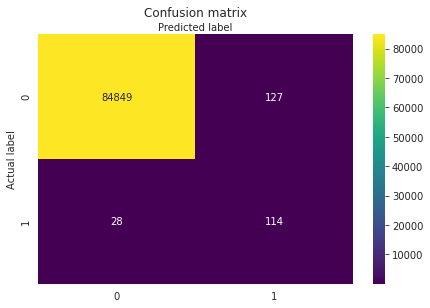

Misclassification Rate: 0.001821001433304354
Accuracy: 0.9981789985666957
Precision: 0.4730290456431535
Recall: 0.8028169014084507
Negative Predictive Power: 0.9985054603652797




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.47      0.80      0.60       142

    accuracy                           1.00     85118
   macro avg       0.74      0.90      0.80     85118
weighted avg       1.00      1.00      1.00     85118







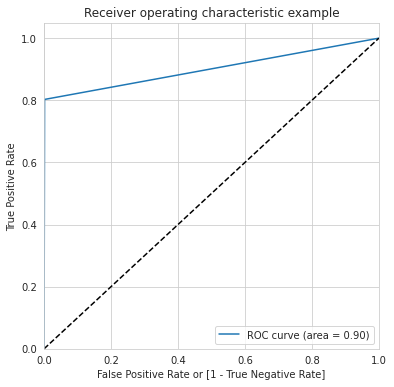

In [ ]:
determine_threshold(rfc, 0.09)

### XGBoost

In [ ]:
# Lets try fitting the model with default parameter
xgboost = XGBClassifier(random_state= 101, tree_method = "gpu_hist")
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.000085          0
86361        0     0.000067          0
94117        0     0.000067          0
123803       0     0.000116          0
126884       0     0.000874          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.000085          0    1    0  ...    0    0    0    0    0
86361        0     0.000067          0    1    0  ...    0    0    0    0    0
94117        0     0.000067          0    1    0  ...    0    0    0    0    0
123803       0     0.000116          0    1    0  ...    0    0    0    0    0
126884       0     0.000874          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.999236  0

<Figure size 720x576 with 0 Axes>

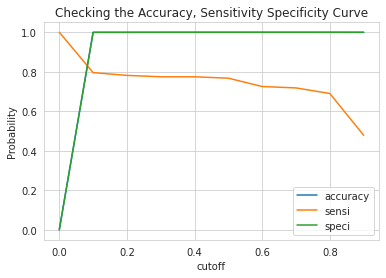





Enter the Ideal Cutoff Index: 0.09


<Figure size 720x576 with 0 Axes>

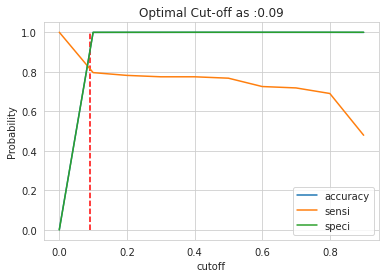





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.000085          0    1  ...    0    0    0           0
86361        0     0.000067          0    1  ...    0    0    0           0
94117        0     0.000067          0    1  ...    0    0    0           0
123803       0     0.000116          0    1  ...    0    0    0           0
126884       0     0.000874          0    1  ...    0    0    0           0

[5 rows x 14 columns]






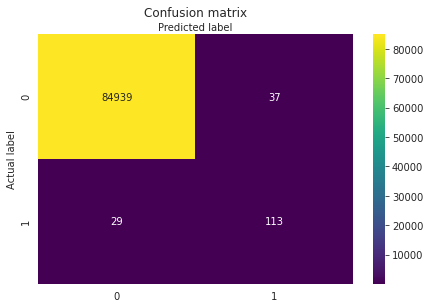

Misclassification Rate: 0.0007753941586973378
Accuracy: 0.9992246058413027
Precision: 0.7533333333333333
Recall: 0.795774647887324
Negative Predictive Power: 0.9995645829410658




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.75      0.80      0.77       142

    accuracy                           1.00     85118
   macro avg       0.88      0.90      0.89     85118
weighted avg       1.00      1.00      1.00     85118







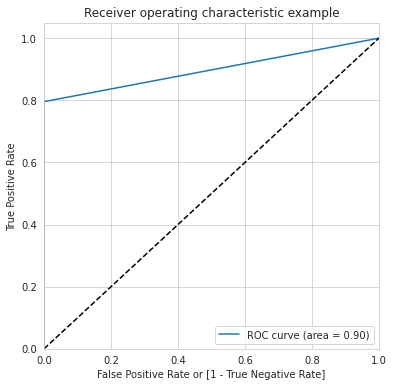

In [ ]:
determine_threshold(xgboost, 0.08)

#### Tuning Hyperparamters for XGBoost

In [ ]:
#Finding the best hyperparameter
# Here the main objective is to find the best possible Hyperparameter

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{'learning_rate': [0.2, 0.4, 0.6, 0.8], 
             'subsample': [0.3, 0.6, 0.9],
             'n_estimators': range(10,400,50)}
                ]

# specifying model
model = XGBClassifier(random_state=42, tree_method = 'gpu_hist')
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 31.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:lo...
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.

In [ ]:
# Check the cross validation Results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        0.792536      0.253992  ...          0.756046         0.021644
1        0.573571      0.009342  ...          0.774931         0.019689
2        0.593787      0.025957  ...          0.794568         0.018198
3        1.987892      0.051323  ...          0.828553         0.014195
4        2.109762      0.044976  ...          0.845169         0.016852
..            ...           ...  ...               ...              ...
91      12.037559      0.153074  ...          1.000000         0.000000
92      12.588708      0.106633  ...          1.000000         0.000000
93      13.314987      0.131964  ...          0.998491         0.001849
94      13.883165      0.094974  ...          1.000000         0.000000
95      14.023052      0.922861  ...          1.000000         0.000000

[96 rows x 23 columns]

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.813 corresponding to hyperparameters {'learning_rate': 0.6, 'n_estimators': 160, 'subsample': 0.9}


Using the default Threshold Cutoff as 0.5
        Actual   Probability  Predicted
139330       0  3.079071e-08          0
86361        0  1.629858e-08          0
94117        0  5.186266e-07          0
123803       0  6.585970e-07          0
126884       0  8.482972e-07          0




Probability at Different Thereshold
        Actual   Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0  3.079071e-08          0    1    0  ...    0    0    0    0    0
86361        0  1.629858e-08          0    1    0  ...    0    0    0    0    0
94117        0  5.186266e-07          0    1    0  ...    0    0    0    0    0
123803       0  6.585970e-07          0    1    0  ...    0    0    0    0    0
126884       0  8.482972e-07          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1 

<Figure size 720x576 with 0 Axes>

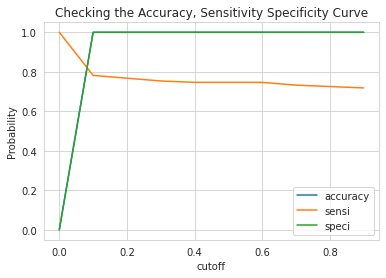

<Figure size 720x576 with 0 Axes>

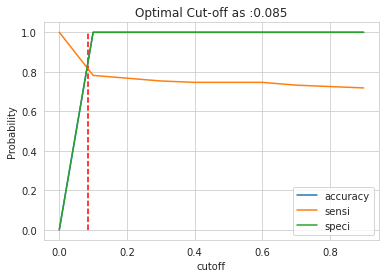





Lets the ideal Cutoff
        Actual   Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0  3.079071e-08          0    1  ...    0    0    0           0
86361        0  1.629858e-08          0    1  ...    0    0    0           0
94117        0  5.186266e-07          0    1  ...    0    0    0           0
123803       0  6.585970e-07          0    1  ...    0    0    0           0
126884       0  8.482972e-07          0    1  ...    0    0    0           0

[5 rows x 14 columns]






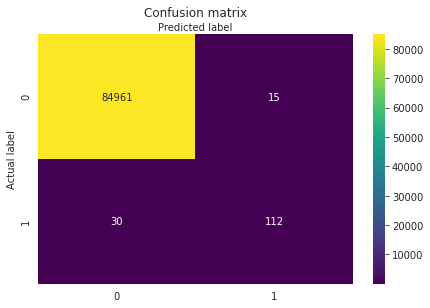

Misclassification Rate: 0.0005286778354754576
Accuracy: 0.9994713221645245
Precision: 0.8818897637795275
Recall: 0.7887323943661971
Negative Predictive Power: 0.9998234795707023




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.88      0.79      0.83       142

    accuracy                           1.00     85118
   macro avg       0.94      0.89      0.92     85118
weighted avg       1.00      1.00      1.00     85118







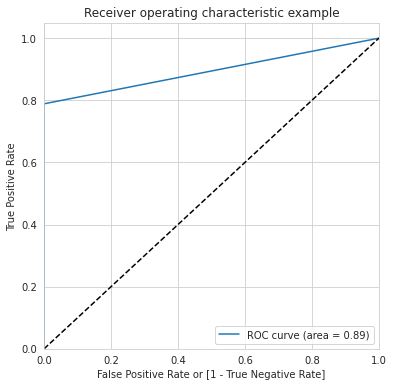

In [ ]:
# Running the Final Model for XGB Classifier
xgboost = XGBClassifier(random_state= 101, tree_method = "gpu_hist", learning_rate = 0.6, n_estimators = 160, subsample = 0.9)
xgboost.fit(x_train, y_train)

determine_threshold(xgboost, 0.085)

#### Concluding models without sampling
Recall Values:
1. Logistic Regression: 0.91
2. KNN: 0.73
3. SVM: 0.78
4. Random Forest: 0.80
5. XGBoost: 0.79

AUC:
1. Logistic Regression: 0.91
2. KNN: 0.87
3. SVM: 0.89
4. Random Forest: 0.90
5. XGBoost: 0.89

Model with best **recall** value was **Logistic Regression** whereas the best **AUC** was given by **Logistic Regression** and **Random Forest**.

As KNN and SVM takes high computation, instead of taking complete data, we took sample of data i.e., initial 70k rows and tried to fit the model. It saved computation time significantly thereby giving the reliable result.

Least Recall value was obtained from KNN followed by SVM, XGBoost and Random Forest. Similarly, same order was followed for AUC.

In the next step, we'll try to upsample the data and compare results.

### Getting best features from the best model i.e., Logistic Regression

In [ ]:
coefficients = lr_final.coef_.tolist()[0]
column_names = x_train.columns.tolist()
coefficients_df = pd.DataFrame([column_names, coefficients], index = ['variables','coefficients']).T
coefficients_df.sort_values(by = 'coefficients', ascending= False).head(3)

variables coefficients
4         V4      1.68048
11       V11      0.65745
22       V22     0.504901

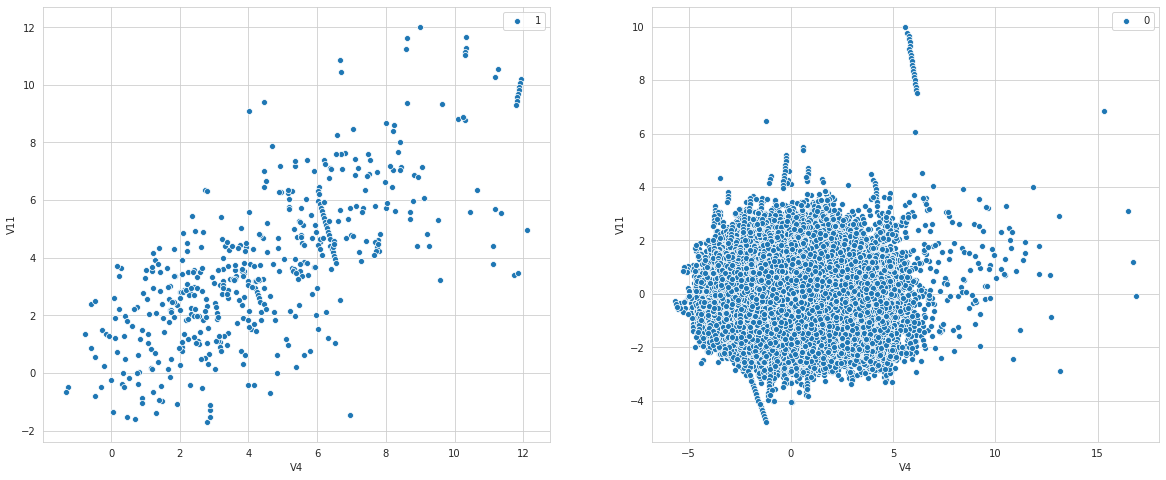

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.scatterplot(x = credit_card[credit_card['Class'] == 1]['V4'], y = credit_card[credit_card['Class'] == 1]['V11'], legend='full')
plt.legend('1')

plt.subplot(1,2,2)
sns.scatterplot(x = credit_card[credit_card['Class'] ==0]['V4'], y = credit_card[credit_card['Class'] == 0]['V11'], legend='full')
plt.legend('0')

plt.show()

**Conclusion:** Top 3 features obtained from the best model yet were V4, V11 and V2. 

Scatterplot have been plotted amongst top two variables obtained.

### Modelling with Balancing Class : SMOTE

In [ ]:
# Checking the effect of Upsampling
print("Before Upsampling, Number of Authenticated Transactions {0}".format(sum(y_train == 0)))
print("Before Upsampling, Number of Fraud Transactions {0}".format(sum(y_train == 1)))

smote = SMOTE(random_state = 42) 
X_train_samp, y_train_samp = smote.fit_sample(x_train, y_train) 

print("After Upsampling, Number of Authenticated Transactions {0}".format(sum(y_train_samp == 0)))
print("After Upsampling, Number of Fraud Transactions {0}".format(sum(y_train_samp == 1)))

Before Upsampling, Number of Authenticated Transactions 198277
Before Upsampling, Number of Fraud Transactions 331
After Upsampling, Number of Authenticated Transactions 198277
After Upsampling, Number of Fraud Transactions 198277


### Logistic Regression

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.005001          0
86361        0     0.017611          0
94117        0     0.023051          0
123803       0     0.011170          0
126884       0     0.065570          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.005001          0    1    0  ...    0    0    0    0    0
86361        0     0.017611          0    1    0  ...    0    0    0    0    0
94117        0     0.023051          0    1    0  ...    0    0    0    0    0
123803       0     0.011170          0    1    0  ...    0    0    0    0    0
126884       0     0.065570          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.824961  0

<Figure size 720x576 with 0 Axes>

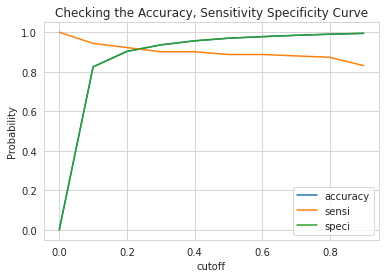

<Figure size 720x576 with 0 Axes>

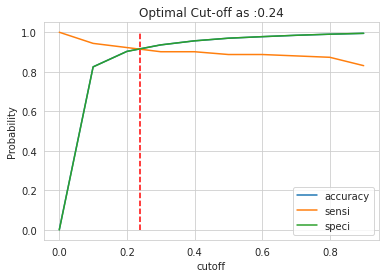





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.005001          0    1  ...    0    0    0           0
86361        0     0.017611          0    1  ...    0    0    0           0
94117        0     0.023051          0    1  ...    0    0    0           0
123803       0     0.011170          0    1  ...    0    0    0           0
126884       0     0.065570          0    1  ...    0    0    0           0

[5 rows x 14 columns]






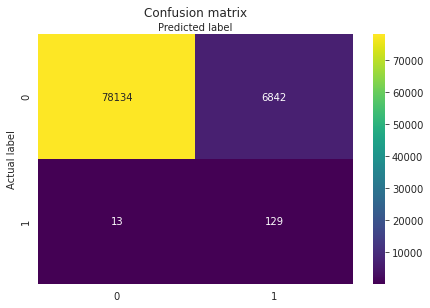

Misclassification Rate: 0.08053525693742804
Accuracy: 0.919464743062572
Precision: 0.018505235977621576
Recall: 0.9084507042253521
Negative Predictive Power: 0.9194831481830164




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84976
           1       0.02      0.91      0.04       142

    accuracy                           0.92     85118
   macro avg       0.51      0.91      0.50     85118
weighted avg       1.00      0.92      0.96     85118







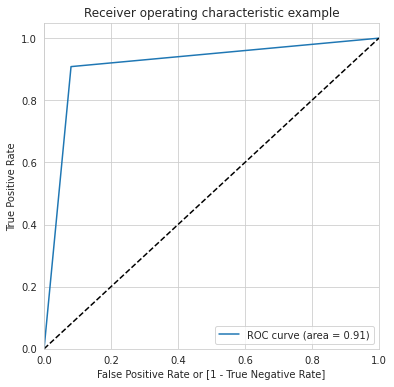

In [ ]:
# Logistic Regression Basic Model
log_reg = LogisticRegression(random_state=42)
smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('log_reg',log_reg)])
pipe.fit(x_train, y_train)
determine_threshold(pipe, 0.24)

**Conclusion**
- Recall Rate increased a lot compared to the unbalanced dataset
- AUC-ROC Increased a lot compared to previous model where we have build the models using the unbalanced dataset

#### Tuning Hyperparamters for Logistic Regression + Upsampling using SMOTE

In [ ]:
# Lets try to find some ideal parameters that would help in boosting te models Recall rate
# Hyperparameter Tuning
log_reg = LogisticRegression(random_state=42)
smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('log_reg',log_reg)])
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
params = {
          'log_reg__C': [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000],
          'log_reg__penalty': ["l1","l2"],
          'log_reg__class_weight': [None, 'balanced' , {0:1,1:5}]
        }

model_log_reg = GridSearchCV(pipe , cv = folds, param_grid = params, scoring  = 'recall', verbose = 1, n_jobs= -1, return_train_score=True)
# fitting the model
model_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=42, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           cla...
                                                           penalty='l2',
                                                           random_state=42,
              

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_log_reg.best_score_
best_hyperparams = model_log_reg.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.949 corresponding to hyperparameters {'log_reg__C': 0.0001, 'log_reg__class_weight': {0: 1, 1: 5}, 'log_reg__penalty': 'l2'}


#### Fitting the model with obtained hyperparameters

In [ ]:
# Logistic Regression Final Model after applying SMOTE
log_reg = LogisticRegression(random_state=42, C = 0.0001, class_weight =  {0: 1, 1: 5} , penalty = 'l2')
smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('log_reg',log_reg)])
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('log_reg',
                 LogisticRegression(C=0.0001, class_weight={0: 1, 1: 5},
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.170276          0
86361        0     0.091247          0
94117        0     0.140992          0
123803       0     0.108879          0
126884       0     0.223775          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.170276          0    1    1  ...    0    0    0    0    0
86361        0     0.091247          0    1    0  ...    0    0    0    0    0
94117        0     0.140992          0    1    1  ...    0    0    0    0    0
123803       0     0.108879          0    1    1  ...    0    0    0    0    0
126884       0     0.223775          0    1    1  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.415940  0

<Figure size 720x576 with 0 Axes>

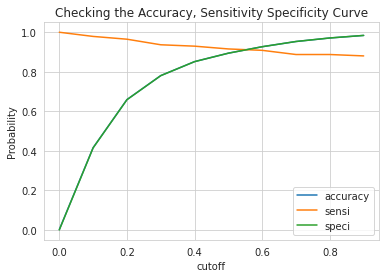

<Figure size 720x576 with 0 Axes>

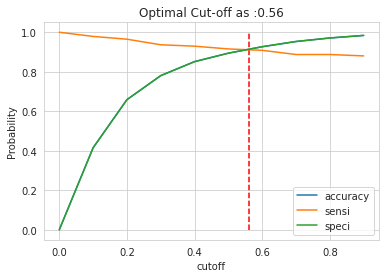





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.170276          0    1  ...    0    0    0           0
86361        0     0.091247          0    1  ...    0    0    0           0
94117        0     0.140992          0    1  ...    0    0    0           0
123803       0     0.108879          0    1  ...    0    0    0           0
126884       0     0.223775          0    1  ...    0    0    0           0

[5 rows x 14 columns]






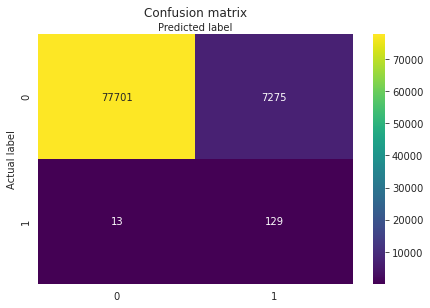

Misclassification Rate: 0.08562231255433633
Accuracy: 0.9143776874456636
Precision: 0.017423014586709886
Recall: 0.9084507042253521
Negative Predictive Power: 0.9143875917906232




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.91      0.96     84976
           1       0.02      0.91      0.03       142

    accuracy                           0.91     85118
   macro avg       0.51      0.91      0.49     85118
weighted avg       1.00      0.91      0.95     85118







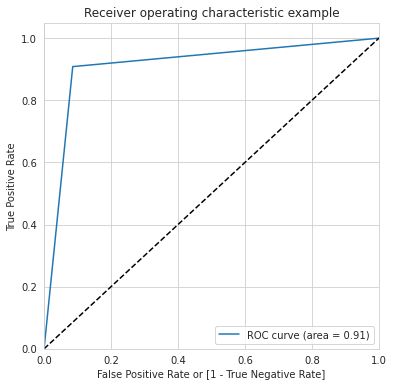

In [ ]:
determine_threshold(pipe, 0.56)

**Conclusion**
- After applying upsampling, the AUC-ROC increased
- Recall also increased

### KNN

In [ ]:
# As KNN is quite Time consuming, if we try to fit the KNN on the whole dataset.
# Lets try to get the first 15k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 21.5k, then then the 70% of that is around 15k and 6.5k for the test set
x_train_temp = x_train[0:15000]
y_train_temp = y_train[0:15000]
x_test_temp  = x_test[-6500:-1]
y_test_temp  = y_test[-6500:-1]

print('Before Applying Upsampling')

print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train_temp, y_train_temp)

print('After Applying Upsampling')
print(f"Number of Fraud in Train Dataset {np.sum(y_res)} and % of fraud {round((np.sum(y_res)/len(y_res))*100,4)}")

Before Applying Upsampling
Number of Fraud in Train Dataset 19 and % of fraud 0.1267
Number of Fraud in Train Dataset 9 and % of fraud 0.1385
After Applying Upsampling
Number of Fraud in Train Dataset 14981 and % of fraud 50.0


In [ ]:
# KNN model 1
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[6484    6]
 [   0    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6490
           1       0.60      1.00      0.75         9

    accuracy                           1.00      6499
   macro avg       0.80      1.00      0.87      6499
weighted avg       1.00      1.00      1.00      6499



**Conclusion**
- As it can be seen above we are getting a Recall rate of perfect 1 but we need to cross verify whether the model is learning properly or not and it not overfitting, so lets try to fetch the ideal learning parameters for the KNN Model

#### Lets try to fetch some ideal parameters for KNN which will help in achieving a better model

In [ ]:
# Identifying the ideal K Values
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    print(f'Trying for the K Neighbors: { i }')
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_res, y_res)
    pred_i = knn.predict(x_test_temp)
    error.append(np.mean(pred_i != y_test_temp))
    done = time.time()
    elapsed = done - start
    print(f'Total Time Taken to Train: { round(elapsed,2)} seconds')
    print('========================================================\n')

Trying for the K Neighbors: 1
Total Time Taken to Train: 5.06 seconds

Trying for the K Neighbors: 2
Total Time Taken to Train: 5.55 seconds

Trying for the K Neighbors: 3
Total Time Taken to Train: 5.95 seconds

Trying for the K Neighbors: 4
Total Time Taken to Train: 6.17 seconds

Trying for the K Neighbors: 5
Total Time Taken to Train: 6.27 seconds

Trying for the K Neighbors: 6
Total Time Taken to Train: 6.47 seconds

Trying for the K Neighbors: 7
Total Time Taken to Train: 6.57 seconds

Trying for the K Neighbors: 8
Total Time Taken to Train: 6.55 seconds

Trying for the K Neighbors: 9
Total Time Taken to Train: 6.67 seconds

Trying for the K Neighbors: 10
Total Time Taken to Train: 6.56 seconds

Trying for the K Neighbors: 11
Total Time Taken to Train: 6.66 seconds

Trying for the K Neighbors: 12
Total Time Taken to Train: 6.75 seconds

Trying for the K Neighbors: 13
Total Time Taken to Train: 6.86 seconds

Trying for the K Neighbors: 14
Total Time Taken to Train: 6.77 seconds

T

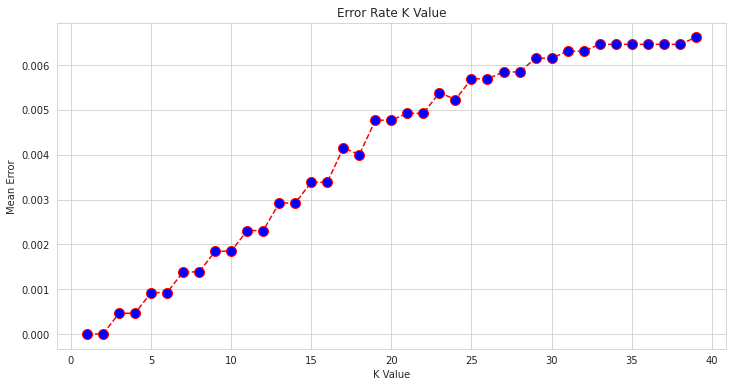

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

**Conclusion**
- As it can be seen above the mean error is gradually increasing and also for the very low K Values, we got the mean error as 0, so lets try to validate the same with some higher number of data

In [ ]:
# As KNN is quite Time consuming, if we try to fit the KNN on the whole dataset.
# Lets try to get the first 70k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 1lkh, then then the 70% of that is around 70k and 30k for the test set
x_train_temp = x_train[0:70000]
y_train_temp = y_train[0:70000]
x_test_temp  = x_test[-30000:-1]
y_test_temp  = y_test[-30000:-1]

print('Before Applying Upsampling')

print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train_temp, y_train_temp)

print('After Applying Upsampling')
print(f"Number of Fraud in Train Dataset {np.sum(y_res)} and % of fraud {round((np.sum(y_res)/len(y_res))*100,4)}")

Before Applying Upsampling
Number of Fraud in Train Dataset 99 and % of fraud 0.1414
Number of Fraud in Train Dataset 46 and % of fraud 0.1533
After Applying Upsampling
Number of Fraud in Train Dataset 69901 and % of fraud 50.0


In [ ]:
# KNN model 2, lets try with 5 number of neighbors first
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[29900    53]
 [    8    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.42      0.83      0.55        46

    accuracy                           1.00     29999
   macro avg       0.71      0.91      0.78     29999
weighted avg       1.00      1.00      1.00     29999



In [ ]:
# Identifying the ideal K Values
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    print(f'Trying for the K Neighbors: { i }')
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_res, y_res)
    pred_i = knn.predict(x_test_temp)
    error.append(np.mean(pred_i != y_test_temp))
    done = time.time()
    elapsed = done - start
    print(f'Total Time Taken to Train: { round(elapsed,2)} seconds')
    print('========================================================\n')

Trying for the K Neighbors: 1
Total Time Taken to Train: 68.49 seconds

Trying for the K Neighbors: 2
Total Time Taken to Train: 81.51 seconds

Trying for the K Neighbors: 3
Total Time Taken to Train: 71.87 seconds

Trying for the K Neighbors: 4
Total Time Taken to Train: 80.06 seconds

Trying for the K Neighbors: 5
Total Time Taken to Train: 82.31 seconds

Trying for the K Neighbors: 6
Total Time Taken to Train: 82.97 seconds

Trying for the K Neighbors: 7
Total Time Taken to Train: 85.62 seconds

Trying for the K Neighbors: 8
Total Time Taken to Train: 88.2 seconds

Trying for the K Neighbors: 9
Total Time Taken to Train: 92.74 seconds

Trying for the K Neighbors: 10
Total Time Taken to Train: 94.6 seconds

Trying for the K Neighbors: 11
Total Time Taken to Train: 96.07 seconds

Trying for the K Neighbors: 12
Total Time Taken to Train: 97.79 seconds

Trying for the K Neighbors: 13
Total Time Taken to Train: 98.81 seconds

Trying for the K Neighbors: 14
Total Time Taken to Train: 99.7

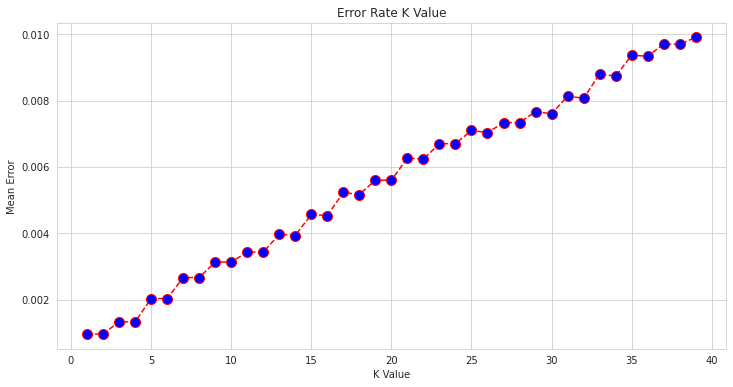

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

**Conclusion**
- As it can be seen here when we keep the value as low as possible we were able to get a zero mean error. So we would choose n_neighbors as 5 and lets see whether there is some improvement or not in recall rate

In [ ]:
# KNN model 5, lets try with 5 number of neighbors first
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n------------------------------------------------------')
print('Lets try on the actual test dataset')

y_pred = knn.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[29900    53]
 [    8    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.42      0.83      0.55        46

    accuracy                           1.00     29999
   macro avg       0.71      0.91      0.78     29999
weighted avg       1.00      1.00      1.00     29999


------------------------------------------------------
Lets try on the actual test dataset
[[84820   156]
 [   28   114]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.42      0.80      0.55       142

    accuracy                           1.00     85118
   macro avg       0.71      0.90      0.78     85118
weighted avg       1.00      1.00      1.00     85118



In [ ]:
# KNN model 6
# Lets to see if using different algorithm leads to increase in the recall rate or not
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm = 'kd_tree')
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))


print('\n\n')
print('====================================================================')
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm = 'ball_tree')
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm = 'brute')
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[29900    53]
 [    8    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.42      0.83      0.55        46

    accuracy                           1.00     29999
   macro avg       0.71      0.91      0.78     29999
weighted avg       1.00      1.00      1.00     29999




[[29900    53]
 [    8    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.42      0.83      0.55        46

    accuracy                           1.00     29999
   macro avg       0.71      0.91      0.78     29999
weighted avg       1.00      1.00      1.00     29999




[[29900    53]
 [    8    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.42      0.83      0.55        46

    accuracy                           1.00     29999
   macro avg       0.71      

**Conclusion**
- Different algorithm doesn't affect the recall here. So lets try to run a Gridsearch CV and lets see

#### KNN Cross Validation & Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning
model = KNeighborsClassifier(n_jobs=-1)

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{ 'n_neighbors': range(2,6,1),
                  'algorithm'  : ['kd_tree', 'ball_tree', 'brute' ],
                  'metric'     : ['euclidean', 'manhattan', 'chebyshev']
             }]
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(X_res, y_res)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 72.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 640.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid=[{'algorithm': ['kd_tree', 'ball_tree', 'brute'],
                          'metric': ['euclidean', 'manhattan', 'chebyshev'],
                          'n_neighbors': range(2, 6)}],
             return_train_score=True, scoring='recall', verbose=1)

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 1.0 corresponding to hyperparameters {'algorithm': 'kd_tree', 'metric': 'euclidean', 'n_neighbors': 2}


#### Fitting the model with obtained hyperparameters

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0          0.0          0
86361        0          0.0          0
94117        0          0.0          0
123803       0          0.0          0
126884       0          0.0          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0          0.0          0    0    0  ...    0    0    0    0    0
86361        0          0.0          0    0    0  ...    0    0    0    0    0
94117        0          0.0          0    0    0  ...    0    0    0    0    0
123803       0          0.0          0    0    0  ...    0    0    0    0    0
126884       0          0.0          0    0    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.998473  0.774648  0.998847
0.1     0.1  0.998473  0

<Figure size 720x576 with 0 Axes>

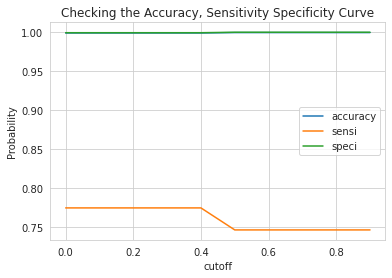





Enter the Ideal Cutoff Index: 0.4


<Figure size 720x576 with 0 Axes>

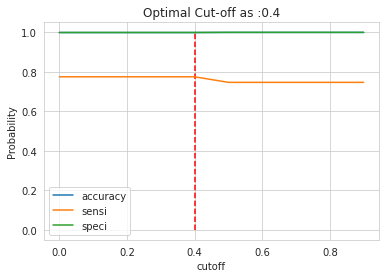





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0          0.0          0    0  ...    0    0    0           0
86361        0          0.0          0    0  ...    0    0    0           0
94117        0          0.0          0    0  ...    0    0    0           0
123803       0          0.0          0    0  ...    0    0    0           0
126884       0          0.0          0    0  ...    0    0    0           0

[5 rows x 14 columns]






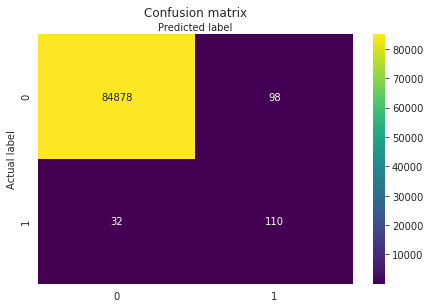

Misclassification Rate: 0.0015272915247068774
Accuracy: 0.9984727084752931
Precision: 0.5288461538461539
Recall: 0.7746478873239436
Negative Predictive Power: 0.9988467331952551




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.53      0.77      0.63       142

    accuracy                           1.00     85118
   macro avg       0.76      0.89      0.81     85118
weighted avg       1.00      1.00      1.00     85118







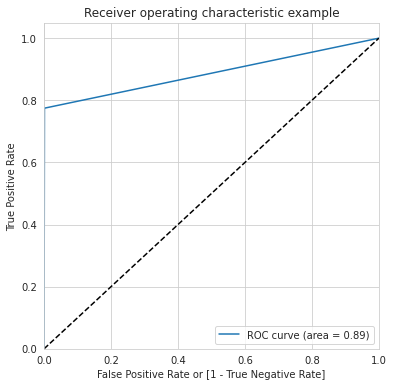

In [ ]:
# Lets build the final model
# KNN model final model
knn_final = KNeighborsClassifier(n_jobs=-1, algorithm = 'kd_tree', metric = 'euclidean', n_neighbors = 2)

smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('knn_final',knn_final)])
pipe.fit(x_train, y_train)

determine_threshold(pipe, 0.4)

**Conclusion**
- As we can see the AUC-ROC Increased by 2% 
- And also the recall also increased by 4% after the upsampling
- But KNN is not the best model, as after Logistic Regression we got less AUC-ROC

### SVM


In [ ]:
# As SVM is quite Time consuming, if we try to fit the SVM on the whole dataset.
# Lets try to get the first 70k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 1lkh, then then the 70% of that is around 70k and 30k for the test set
x_train_temp = x_train[0:70000]
y_train_temp = y_train[0:70000]
x_test_temp  = x_test[-30000:-1]
y_test_temp  = y_test[-30000:-1]

print('Before Applying Upsampling')

print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train_temp, y_train_temp)

print('After Applying Upsampling')
print(f"Number of Fraud in Train Dataset {np.sum(y_res)} and % of fraud {round((np.sum(y_res)/len(y_res))*100,4)}")

Before Applying Upsampling
Number of Fraud in Train Dataset 99 and % of fraud 0.1414
Number of Fraud in Train Dataset 46 and % of fraud 0.1533
After Applying Upsampling
Number of Fraud in Train Dataset 69901 and % of fraud 50.0


In [ ]:
# SVM Model 1
svm_model = svm.SVC(kernel='linear', random_state=42) # Lets try with Linear Kernal
svm_model.fit(X_res, y_res)

y_pred = svm_model.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')

print('Checking for the original df')
y_pred = svm_model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[29132   821]
 [    4    42]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     29953
           1       0.05      0.91      0.09        46

    accuracy                           0.97     29999
   macro avg       0.52      0.94      0.54     29999
weighted avg       1.00      0.97      0.98     29999




Checking for the original df
[[82618  2358]
 [   16   126]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



#### SVM Cross Validation & Hyperparameter Tuning

In [ ]:
# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation
hyper_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10]},
                    {'kernel': ['linear'], 'C': [1, 10]}]


model = svm.SVC(random_state=42)
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(X_res, y_res)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 94.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [1, 10], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10], 'kernel': ['linear']}],
             return_train_score=True, scoring='recall', verbose=1)

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.999 corresponding to hyperparameters {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


#### Fitting the model with obtained hyperparameters

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.000034          0
86361        0     0.001089          0
94117        0     0.004440          0
123803       0     0.000248          0
126884       0     0.000122          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0     0.000034          0    1    0    0    0    0    0    0   
86361        0     0.001089          0    1    0    0    0    0    0    0   
94117        0     0.004440          0    1    0    0    0    0    0    0   
123803       0     0.000248          0    1    0    0    0    0    0    0   
126884       0     0.000122          0    1    0    0    0    0    0    0   

        0.7  0.8  0.9  
139330    0    0    0  
86361     0    0    0  
94117     0    0    0  
123803    0    0    0  
126884    0    0    0  




Checking the Accuracy, Sensitivity and Specificity for different Threshol

<Figure size 720x576 with 0 Axes>

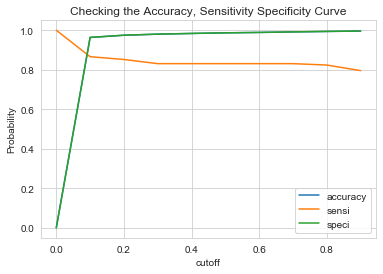





Enter the Ideal Cutoff Index: 0.1


<Figure size 720x576 with 0 Axes>

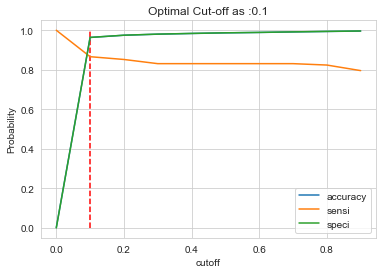





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0     0.000034          0    1    0    0    0    0    0    0   
86361        0     0.001089          0    1    0    0    0    0    0    0   
94117        0     0.004440          0    1    0    0    0    0    0    0   
123803       0     0.000248          0    1    0    0    0    0    0    0   
126884       0     0.000122          0    1    0    0    0    0    0    0   

        0.7  0.8  0.9  Opt Cutoff  
139330    0    0    0           0  
86361     0    0    0           0  
94117     0    0    0           0  
123803    0    0    0           0  
126884    0    0    0           0  






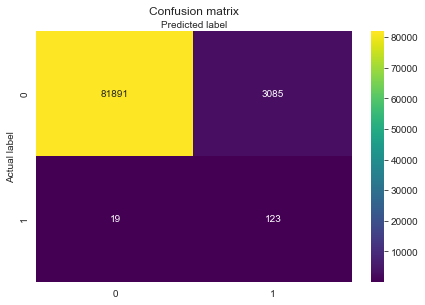

Misclassification Rate: 0.03646702225146268
Accuracy: 0.9635329777485373
Precision: 0.03834164588528678
Recall: 0.8661971830985915
Negative Predictive Power: 0.9636956317077763




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     84976
           1       0.04      0.87      0.07       142

    accuracy                           0.96     85118
   macro avg       0.52      0.91      0.53     85118
weighted avg       1.00      0.96      0.98     85118







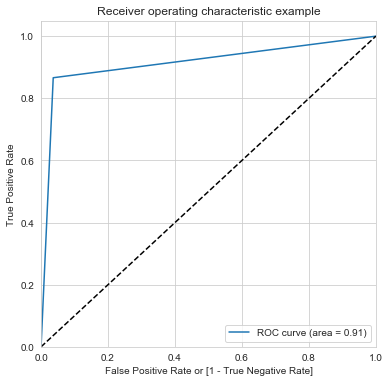

In [ ]:
# SVM Final Model
svm_model = svm.SVC(random_state=42, C = 10, gamma =  0.001, kernel = 'rbf', probability=True)
smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('svm',svm_model)])
pipe.fit(x_train, y_train)
determine_threshold(pipe, 0.1)

### Random Forest

In [ ]:
# Random Forest Classifier + Upsampling 1
rfc = RandomForestClassifier(random_state = 42)
smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('rfc',rfc)])

pipe.fit(x_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0          0.0          0
86361        0          0.0          0
94117        0          0.0          0
123803       0          0.0          0
126884       0          0.0          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0          0.0          0    0    0    0    0    0    0    0   
86361        0          0.0          0    0    0    0    0    0    0    0   
94117        0          0.0          0    0    0    0    0    0    0    0   
123803       0          0.0          0    0    0    0    0    0    0    0   
126884       0          0.0          0    0    0    0    0    0    0    0   

        0.7  0.8  0.9  
139330    0    0    0  
86361     0    0    0  
94117     0    0    0  
123803    0    0    0  
126884    0    0    0  




Checking the Accuracy, Sensitivity and Specificity for different Threshol

<Figure size 720x576 with 0 Axes>

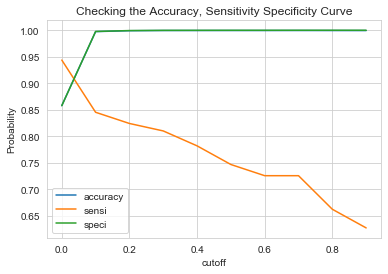

<Figure size 720x576 with 0 Axes>

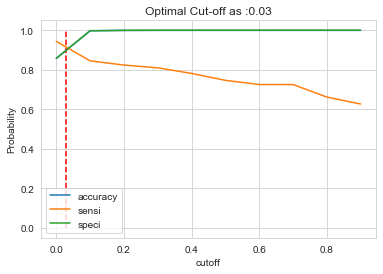





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0          0.0          0    0    0    0    0    0    0    0   
86361        0          0.0          0    0    0    0    0    0    0    0   
94117        0          0.0          0    0    0    0    0    0    0    0   
123803       0          0.0          0    0    0    0    0    0    0    0   
126884       0          0.0          0    0    0    0    0    0    0    0   

        0.7  0.8  0.9  Opt Cutoff  
139330    0    0    0           0  
86361     0    0    0           0  
94117     0    0    0           0  
123803    0    0    0           0  
126884    0    0    0           0  






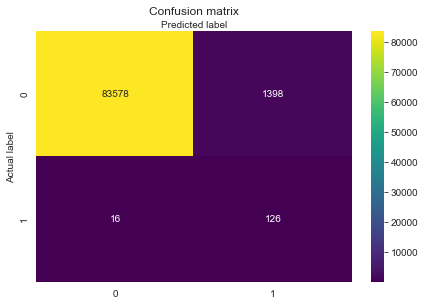

Misclassification Rate: 0.016612232430273266
Accuracy: 0.9833877675697267
Precision: 0.08267716535433071
Recall: 0.8873239436619719
Negative Predictive Power: 0.9835482959894558




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.08      0.89      0.15       142

    accuracy                           0.98     85118
   macro avg       0.54      0.94      0.57     85118
weighted avg       1.00      0.98      0.99     85118







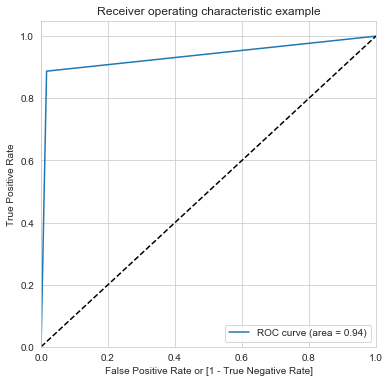

In [ ]:
determine_threshold(pipe, 0.03)

**Conclusion**
- We got a pretty good recall rate compared to previous model
- And also the AUC-ROC is 0.94 which is also the best till now
- Lets try to do Hyperparameter tuning and lets see what are the ideal model parameters

#### Random Forest Cross Validation & Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning
rfc = RandomForestClassifier(random_state=42, n_jobs = -1, warm_start = True)
smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('rfc',rfc)])
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
params = {
          'rfc__max_depth': range(2, 23, 10),
          'rfc__n_estimators': range(10, 310, 100),
          'rfc__max_features': range(12,32,10),
          'rfc__min_samples_leaf': range(10, 1000, 500),
          'rfc__min_samples_split': range(10, 1000, 500),
          'rfc__class_weight': ['balanced', {0:1, 1:5}]
        }

model_log_reg = GridSearchCV(pipe , cv = folds, param_grid = params, scoring  = 'recall', verbose = 5, n_jobs= -1, return_train_score=True)
# fitting the model
model_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 62.9min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 234.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 412.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 618.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 779.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('rfc',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42,
                                                               warm_start=True))]),
             n_jobs=-1,
             param_grid={'rfc__class_weight': ['balanced', {0: 1, 1: 5}],
                         'rfc__max_depth': range(2, 23, 10),
                         'rfc__max_features': range(12, 32, 10),
                         'rfc__min_samples_leaf': range(10, 1000, 500),
                         'rfc__min_samples_split': range(10, 1000, 500),
                         'rfc__n_estimators': range(10, 310, 100)},
             return_train_score=True, scoring='recall', verbose=5)

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_log_reg.best_score_
best_hyperparams = model_log_reg.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.952 corresponding to hyperparameters {'rfc__class_weight': {0: 1, 1: 5}, 'rfc__max_depth': 2, 'rfc__max_features': 12, 'rfc__min_samples_leaf': 10, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 210}


#### Fitting the model with obtained hyperparameters

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.239007          0
86361        0     0.236820          0
94117        0     0.232755          0
123803       0     0.233694          0
126884       0     0.584048          1




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.239007          0    1    1  ...    0    0    0    0    0
86361        0     0.236820          0    1    1  ...    0    0    0    0    0
94117        0     0.232755          0    1    1  ...    0    0    0    0    0
123803       0     0.233694          0    1    1  ...    0    0    0    0    0
126884       0     0.584048          1    1    1  ...    1    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.001668  1

<Figure size 720x576 with 0 Axes>

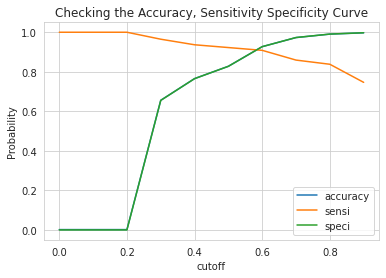

<Figure size 720x576 with 0 Axes>

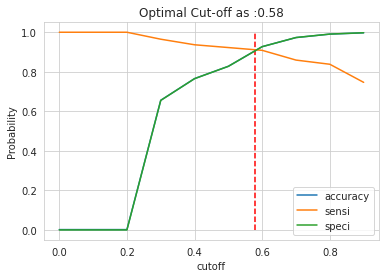





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.239007          0    1  ...    0    0    0           0
86361        0     0.236820          0    1  ...    0    0    0           0
94117        0     0.232755          0    1  ...    0    0    0           0
123803       0     0.233694          0    1  ...    0    0    0           0
126884       0     0.584048          1    1  ...    0    0    0           1

[5 rows x 14 columns]






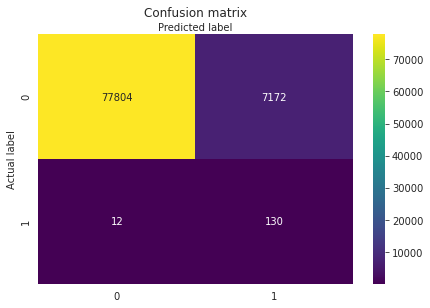

Misclassification Rate: 0.08440047933457083
Accuracy: 0.9155995206654292
Precision: 0.017803341550260202
Recall: 0.9154929577464789
Negative Predictive Power: 0.9155996987384674




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84976
           1       0.02      0.92      0.03       142

    accuracy                           0.92     85118
   macro avg       0.51      0.92      0.50     85118
weighted avg       1.00      0.92      0.95     85118







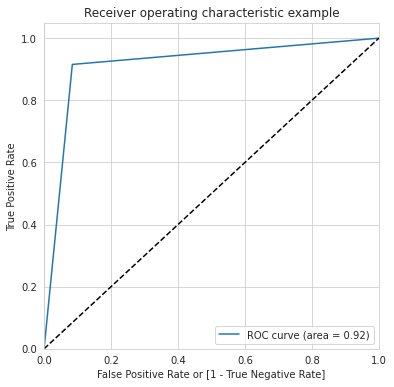

In [ ]:
# Random Forest Classifier + Upsampling 1 + with the ideal hyperparameters
rfc = RandomForestClassifier(random_state = 42, 
                             class_weight = {0: 1, 1: 5}, 
                             max_depth = 2, 
                             max_features = 12, 
                             min_samples_leaf =  10, 
                             min_samples_split = 10, 
                             n_estimators = 210 )
smote = SMOTE(random_state=42)
pipe = Pipeline([('smote',smote),
                 ('rfc',rfc)])

pipe.fit(x_train, y_train)

determine_threshold(pipe, 0.58)

**Conclusion**
- As it can be seen recall increased a lot by 10%
- And also AUC-RUC increased by 2% compared to previous model

### XGBoost

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.048260          0
86361        0     0.003982          0
94117        0     0.012340          0
123803       0     0.007146          0
126884       0     0.053668          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.048260          0    1    0  ...    0    0    0    0    0
86361        0     0.003982          0    1    0  ...    0    0    0    0    0
94117        0     0.012340          0    1    0  ...    0    0    0    0    0
123803       0     0.007146          0    1    0  ...    0    0    0    0    0
126884       0     0.053668          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.897742  0

<Figure size 720x576 with 0 Axes>

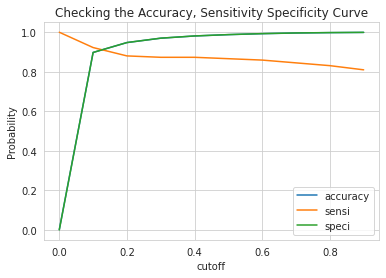

<Figure size 720x576 with 0 Axes>

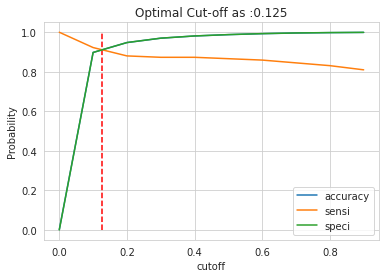





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.048260          0    1  ...    0    0    0           0
86361        0     0.003982          0    1  ...    0    0    0           0
94117        0     0.012340          0    1  ...    0    0    0           0
123803       0     0.007146          0    1  ...    0    0    0           0
126884       0     0.053668          0    1  ...    0    0    0           0

[5 rows x 14 columns]






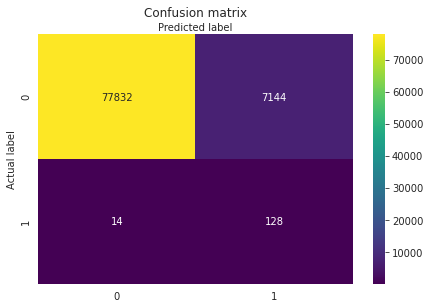

Misclassification Rate: 0.08409502102962946
Accuracy: 0.9159049789703706
Precision: 0.0176017601760176
Recall: 0.9014084507042254
Negative Predictive Power: 0.915929203539823




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84976
           1       0.02      0.90      0.03       142

    accuracy                           0.92     85118
   macro avg       0.51      0.91      0.50     85118
weighted avg       1.00      0.92      0.95     85118







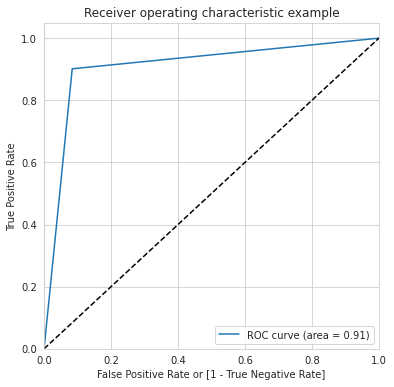

In [ ]:
# Lets try fitting the model with default parameter
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train, y_train)

x_train_over_samp = pd.DataFrame(X_res, columns=x_train.columns.to_list())
y_train_over_samp = pd.DataFrame(y_res, columns=[y_train.name])

xgboost = XGBClassifier(random_state= 101, tree_method = "gpu_hist")
xgboost.fit(x_train_over_samp, y_train_over_samp)

determine_threshold(xgboost, 0.125)

**Conclusion**
- Recall has increased a lot compared to previous time
- And also the AUC has increased by 2 %
- Lets try to see if we can find some ideal parameter which will give an ideal hyperparameter that can help us in getting a ideal recall value

#### XGBoost Cross Validation & Hyperparameter Tuning

In [ ]:
#Finding the best hyperparameter
# Here the main objective is to find the best possible Hyperparameter

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{'learning_rate': [0.2, 0.4, 0.6, 0.8], 
             'subsample': [0.3, 0.6, 0.9],
             'n_estimators': range(10,400,50)}
                ]

# specifying model
model = XGBClassifier(random_state=42, tree_method = 'gpu_hist')
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(x_train_over_samp, y_train_over_samp)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 53.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:lo...
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.

In [ ]:
# Check the cross validation Results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        1.196783      0.211079  ...          0.892424         0.003872
1        1.030349      0.023414  ...          0.900461         0.005783
2        1.121369      0.036663  ...          0.909075         0.001961
3        3.669929      0.057461  ...          0.988158         0.000285
4        3.871919      0.081911  ...          0.988454         0.000561
..            ...           ...  ...               ...              ...
91      22.208273      0.195522  ...          1.000000         0.000000
92      23.562673      0.143811  ...          1.000000         0.000000
93      24.411561      0.179461  ...          1.000000         0.000000
94      25.702296      0.231355  ...          1.000000         0.000000
95      25.865155      3.261183  ...          1.000000         0.000000

[96 rows x 23 columns]

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 1.0 corresponding to hyperparameters {'learning_rate': 0.2, 'n_estimators': 210, 'subsample': 0.3}


#### Fitting the model with obtained hyperparameters

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.003608          0
86361        0     0.000217          0
94117        0     0.000682          0
123803       0     0.000111          0
126884       0     0.000573          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.003608          0    1    0  ...    0    0    0    0    0
86361        0     0.000217          0    1    0  ...    0    0    0    0    0
94117        0     0.000682          0    1    0  ...    0    0    0    0    0
123803       0     0.000111          0    1    0  ...    0    0    0    0    0
126884       0     0.000573          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.986290  0

<Figure size 720x576 with 0 Axes>

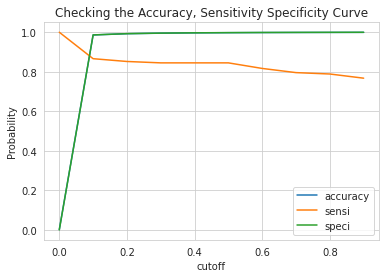

<Figure size 720x576 with 0 Axes>

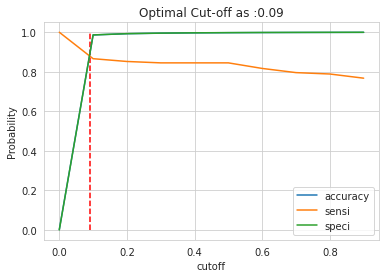





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.003608          0    1  ...    0    0    0           0
86361        0     0.000217          0    1  ...    0    0    0           0
94117        0     0.000682          0    1  ...    0    0    0           0
123803       0     0.000111          0    1  ...    0    0    0           0
126884       0     0.000573          0    1  ...    0    0    0           0

[5 rows x 14 columns]






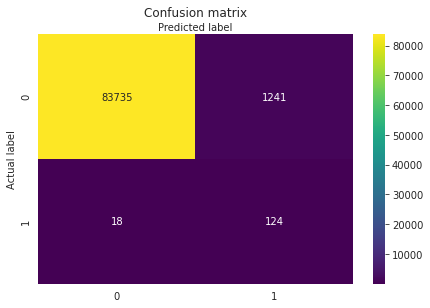

Misclassification Rate: 0.014791230996968914
Accuracy: 0.9852087690030311
Precision: 0.09084249084249084
Recall: 0.8732394366197183
Negative Predictive Power: 0.9853958764827716




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     84976
           1       0.09      0.87      0.16       142

    accuracy                           0.99     85118
   macro avg       0.55      0.93      0.58     85118
weighted avg       1.00      0.99      0.99     85118







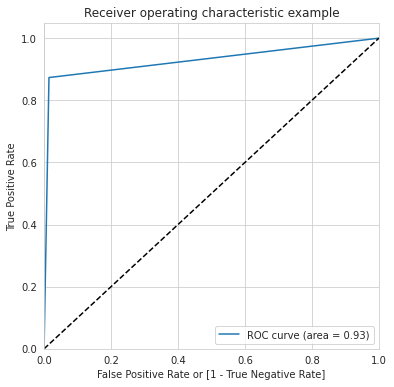

In [ ]:
# XGBoost Classifier + Upsampling 1 + with the ideal hyperparameters
xgboost = XGBClassifier(random_state= 101, tree_method = "gpu_hist", learning_rate = 0.2, n_estimators = 210, subsample = 0.3)
xgboost.fit(x_train_over_samp, y_train_over_samp)

determine_threshold(xgboost, 0.09)

### Concluding models with Upsampling (SMOTE)
Recall Values:
1. Logistic Regression: 0.90
2. KNN: 0.77
3. SVM: 0.86
4. Random Forest: 0.91
5. XGBoost: 0.90

AUC:
1. Logistic Regression: 0.91
2. KNN: 0.89
3. SVM: 0.91
4. Random Forest: 0.92
5. XGBoost: 0.91

Model with best **recall** value was **Random Forest** whereas the best **AUC** was given by **Random Forest** and **XGBoost**.

As KNN and SVM takes high computation, instead of taking complete data, we took sample of data i.e., initial 70k rows and tried to fit the model. It saved computation time significantly thereby giving the reliable result.

Least Recall and AUC was obtained from KNN.

In the next step, we'll try to upsample the data using ADASYN and compare results.

#### Getting best features from the best model i.e., Random Forest

In [ ]:
coefficients = rfc.feature_importances_.tolist()
column_names = x_train.columns.tolist()
coefficients_df = pd.DataFrame([column_names, coefficients], index = ['variables','coefficients']).T
coefficients_df.sort_values(by = 'coefficients', ascending= False).head(3)

variables coefficients
14       V14     0.419922
10       V10     0.211399
4         V4      0.17311

#### Checking Dristribution of the top two variables with Class Before and after Upsampling (SMOTE)

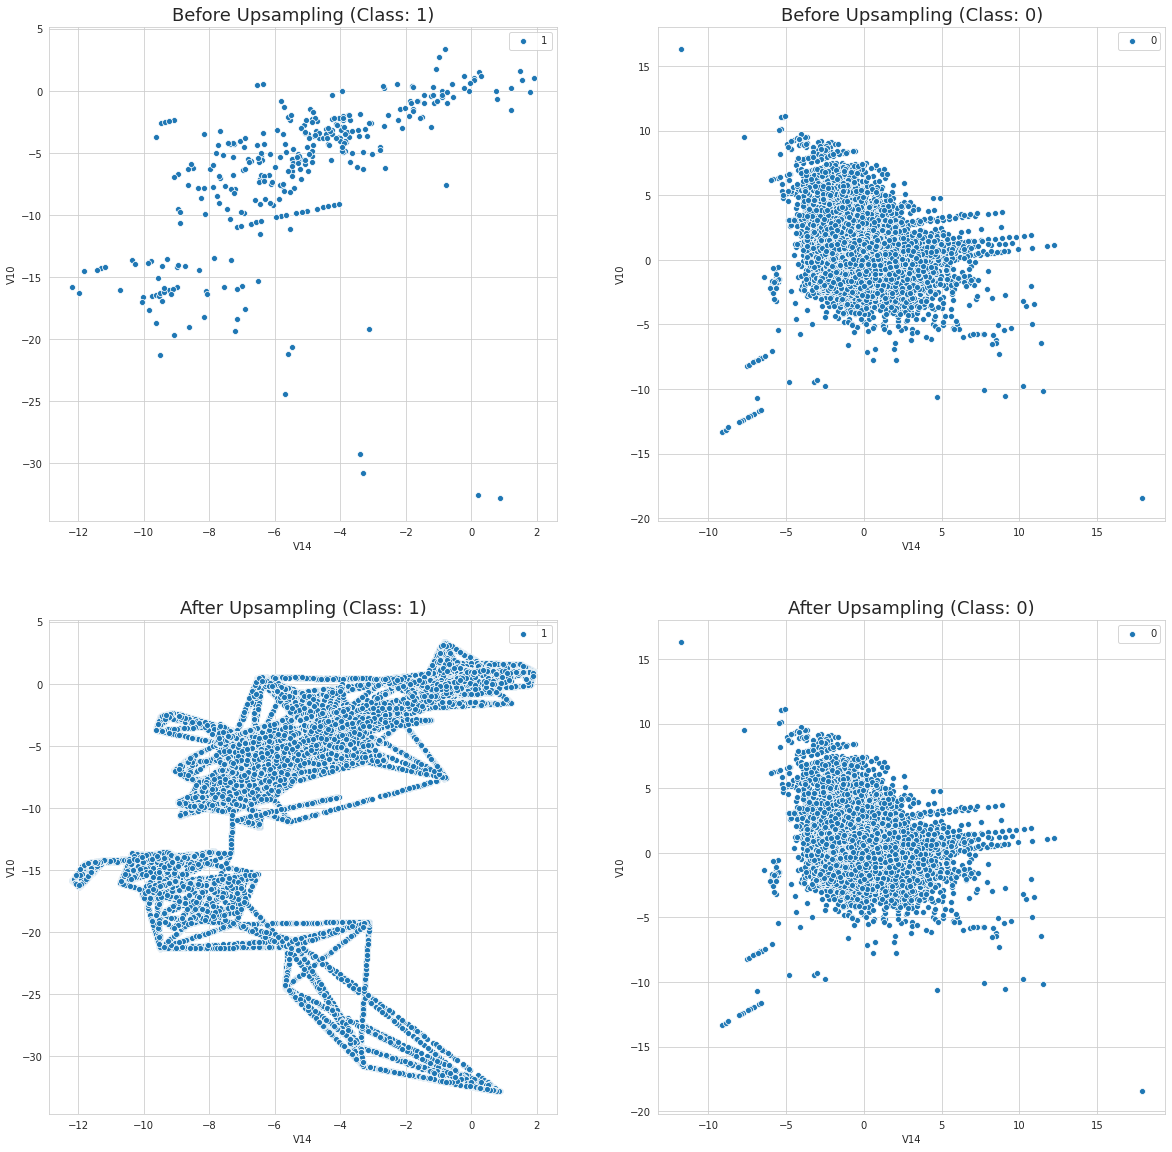

In [ ]:
smote = SMOTE(random_state = 42) 
X_train_samp, y_train_samp = smote.fit_sample(x_train, y_train)
X_train_samp_df = pd.DataFrame(X_train_samp, columns=x_train.columns.tolist())
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title('Before Upsampling (Class: 1)', fontsize = 18)
sns.scatterplot(x = x_train[y_train == 1]['V14'], y = x_train[y_train == 1]['V10'], legend='full')
plt.legend('1')

plt.subplot(2,2,2)
plt.title('Before Upsampling (Class: 0)', fontsize = 18)
sns.scatterplot(x = x_train[y_train ==0]['V14'], y = x_train[y_train == 0]['V10'], legend='full')
plt.legend('0')

plt.subplot(2,2,3)
plt.title('After Upsampling (Class: 1)', fontsize = 18)
sns.scatterplot(x = X_train_samp_df[y_train_samp == 1]['V14'], y = X_train_samp_df[y_train_samp == 1]['V10'], legend='full')
plt.legend('1')

plt.subplot(2,2,4)
plt.title('After Upsampling (Class: 0)', fontsize = 18)
sns.scatterplot(x = X_train_samp_df[y_train_samp ==0]['V14'], y = X_train_samp_df[y_train_samp == 0]['V10'], legend='full')
plt.legend('0')

plt.show()

### Model Building with balanced Data ( ADASYN )

### Logistic Regression

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.007580          0
86361        0     0.039177          0
94117        0     0.079600          0
123803       0     0.041792          0
126884       0     0.123826          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.007580          0    1    0  ...    0    0    0    0    0
86361        0     0.039177          0    1    0  ...    0    0    0    0    0
94117        0     0.079600          0    1    0  ...    0    0    0    0    0
123803       0     0.041792          0    1    0  ...    0    0    0    0    0
126884       0     0.123826          0    1    1  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.672278  0

<Figure size 720x576 with 0 Axes>

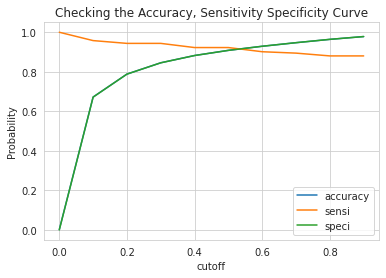

<Figure size 720x576 with 0 Axes>

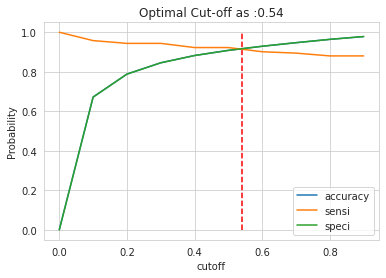





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.007580          0    1  ...    0    0    0           0
86361        0     0.039177          0    1  ...    0    0    0           0
94117        0     0.079600          0    1  ...    0    0    0           0
123803       0     0.041792          0    1  ...    0    0    0           0
126884       0     0.123826          0    1  ...    0    0    0           0

[5 rows x 14 columns]






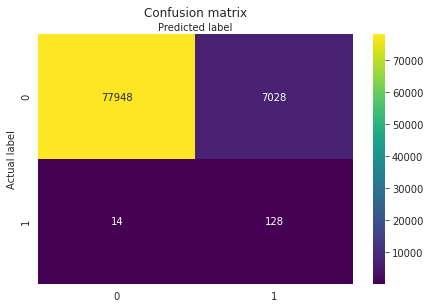

Misclassification Rate: 0.08273220705373717
Accuracy: 0.9172677929462628
Precision: 0.017887087758524316
Recall: 0.9014084507042254
Negative Predictive Power: 0.9172942948597251




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84976
           1       0.02      0.90      0.04       142

    accuracy                           0.92     85118
   macro avg       0.51      0.91      0.50     85118
weighted avg       1.00      0.92      0.96     85118







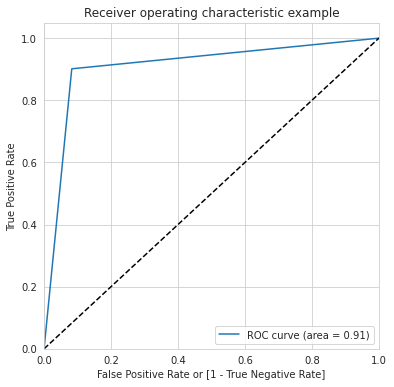

In [ ]:
# Logistic Regression Basic Model
log_reg = LogisticRegression(random_state=42)
adasyn = ADASYN(sampling_strategy= 'minority', random_state= 42)
pipe = Pipeline([('adasyn',adasyn),
                 ('log_reg',log_reg)])
pipe.fit(x_train, y_train)
determine_threshold(pipe, 0.54)

**Conclusion**
- Recall Rate increased again as compared to the unbalanced data
- AUC-ROC has increased again compared to the Unbalanced dataset but it is not better than SMOTE yet, so lets try to find some ideal parameters

#### Tuning Hyperparamters for Logistic Regression + Upsampling using ADASYN

In [ ]:
# Lets try to find some ideal parameters that would help in boosting te models Recall rate
# Hyperparameter Tuning
log_reg = LogisticRegression(random_state=42)
adasyn = ADASYN(sampling_strategy= 'minority', random_state= 42)
pipe = Pipeline([('adasyn',adasyn),
                 ('log_reg',log_reg)])

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
params = {
          'log_reg__C': [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000],
          'log_reg__penalty': ["l1","l2"],
          'log_reg__class_weight': [None, 'balanced' , {0:1,1:5}]
        }

model_log_reg = GridSearchCV(pipe , cv = folds, param_grid = params, scoring  = 'recall', verbose = 1, n_jobs= -1, return_train_score=True)
# fitting the model
model_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 10.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('adasyn',
                                        ADASYN(n_jobs=1, n_neighbors=5,
                                               random_state=42, ratio=None,
                                               sampling_strategy='minority')),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_ite...
   

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_log_reg.best_score_
best_hyperparams = model_log_reg.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.967 corresponding to hyperparameters {'log_reg__C': 0.0001, 'log_reg__class_weight': {0: 1, 1: 5}, 'log_reg__penalty': 'l2'}


#### Fitting the model with obtained hyperparameters

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.272924          0
86361        0     0.182672          0
94117        0     0.291284          0
123803       0     0.272558          0
126884       0     0.429715          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.272924          0    1    1  ...    0    0    0    0    0
86361        0     0.182672          0    1    1  ...    0    0    0    0    0
94117        0     0.291284          0    1    1  ...    0    0    0    0    0
123803       0     0.272558          0    1    1  ...    0    0    0    0    0
126884       0     0.429715          0    1    1  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.256879  0

<Figure size 720x576 with 0 Axes>

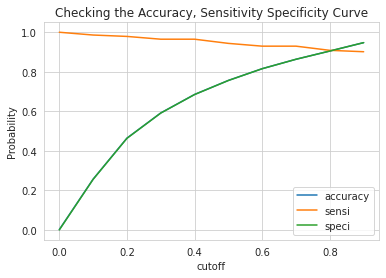

<Figure size 720x576 with 0 Axes>

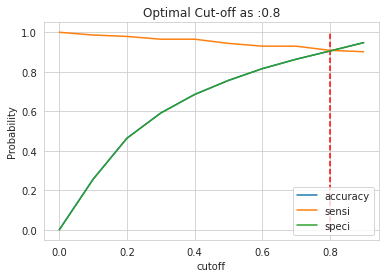





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.272924          0    1  ...    0    0    0           0
86361        0     0.182672          0    1  ...    0    0    0           0
94117        0     0.291284          0    1  ...    0    0    0           0
123803       0     0.272558          0    1  ...    0    0    0           0
126884       0     0.429715          0    1  ...    0    0    0           0

[5 rows x 14 columns]






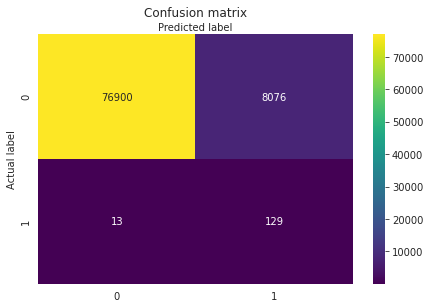

Misclassification Rate: 0.09503277802579947
Accuracy: 0.9049672219742005
Precision: 0.015722120658135285
Recall: 0.9084507042253521
Negative Predictive Power: 0.9049614008661269




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     84976
           1       0.02      0.91      0.03       142

    accuracy                           0.90     85118
   macro avg       0.51      0.91      0.49     85118
weighted avg       1.00      0.90      0.95     85118







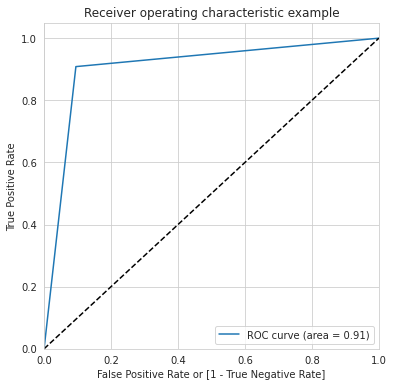

In [ ]:
log_reg = LogisticRegression(random_state=42, C = 0.0001, class_weight = {0: 1, 1: 5}, penalty = 'l2')
adasyn = ADASYN(sampling_strategy= 'minority', random_state= 42)
pipe = Pipeline([('adasyn',adasyn),
                 ('log_reg',log_reg)])
pipe.fit(x_train, y_train)
determine_threshold(pipe, 0.8)

**Conclusion**
- If we look closely wrt to output from the previous logistic regression o/p which we got 
  - On Unbalanced Dataset      : Recall rate is best among all three models, 0.92 and also AUC-ROC is same , and the key difference wrt to confusion matrix is more number of points were rightly classified wrt to TP. But the same number of points are being classified as TN.
  - Upsampling Using **SMOTE** : Recall Rate was higher, and also the Negative predictive power decreased. But the AUC Remained same. 

### KNN

In [ ]:
# As KNN is quite Time consuming, if we try to fit the KNN on the whole dataset.
# Lets try to get the first 15k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 21.5k, then then the 70% of that is around 15k and 6.5k for the test set
x_train_temp = x_train[0:15000]
y_train_temp = y_train[0:15000]
x_test_temp  = x_test[-6500:-1]
y_test_temp  = y_test[-6500:-1]

print('Before Applying Upsampling')

print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

adasyn = ADASYN(sampling_strategy= 'minority', random_state= 42)
X_res, y_res = adasyn.fit_resample(x_train_temp, y_train_temp)

print('After Applying Upsampling')
print(f"Number of Fraud in Train Dataset {np.sum(y_res)} and % of fraud {round((np.sum(y_res)/len(y_res))*100,4)}")

Before Applying Upsampling
Number of Fraud in Train Dataset 19 and % of fraud 0.1267
Number of Fraud in Train Dataset 9 and % of fraud 0.1385
After Applying Upsampling
Number of Fraud in Train Dataset 14976 and % of fraud 49.9917


In [ ]:
# KNN model 1
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[6484    6]
 [   0    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6490
           1       0.60      1.00      0.75         9

    accuracy                           1.00      6499
   macro avg       0.80      1.00      0.87      6499
weighted avg       1.00      1.00      1.00      6499



**Conclusion**
- As it can be seen above we are getting a Recall rate of perfect 1 but we need to cross verify whether the model is learning properly or not and it not overfitting, so lets try to fetch the ideal learning parameters for the KNN Model

#### Lets try to fetch some ideal parameters for KNN which will help in achieving a better model

In [ ]:
# Identifying the ideal K Values
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    print(f'Trying for the K Neighbors: { i }')
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_res, y_res)
    pred_i = knn.predict(x_test_temp)
    error.append(np.mean(pred_i != y_test_temp))
    done = time.time()
    elapsed = done - start
    print(f'Total Time Taken to Train: { round(elapsed,2)} seconds')
    print('========================================================\n')

Trying for the K Neighbors: 1
Total Time Taken to Train: 4.37 seconds

Trying for the K Neighbors: 2
Total Time Taken to Train: 4.94 seconds

Trying for the K Neighbors: 3
Total Time Taken to Train: 5.13 seconds

Trying for the K Neighbors: 4
Total Time Taken to Train: 5.37 seconds

Trying for the K Neighbors: 5
Total Time Taken to Train: 5.54 seconds

Trying for the K Neighbors: 6
Total Time Taken to Train: 5.65 seconds

Trying for the K Neighbors: 7
Total Time Taken to Train: 5.75 seconds

Trying for the K Neighbors: 8
Total Time Taken to Train: 5.84 seconds

Trying for the K Neighbors: 9
Total Time Taken to Train: 5.84 seconds

Trying for the K Neighbors: 10
Total Time Taken to Train: 5.86 seconds

Trying for the K Neighbors: 11
Total Time Taken to Train: 5.88 seconds

Trying for the K Neighbors: 12
Total Time Taken to Train: 5.97 seconds

Trying for the K Neighbors: 13
Total Time Taken to Train: 5.97 seconds

Trying for the K Neighbors: 14
Total Time Taken to Train: 5.94 seconds

T

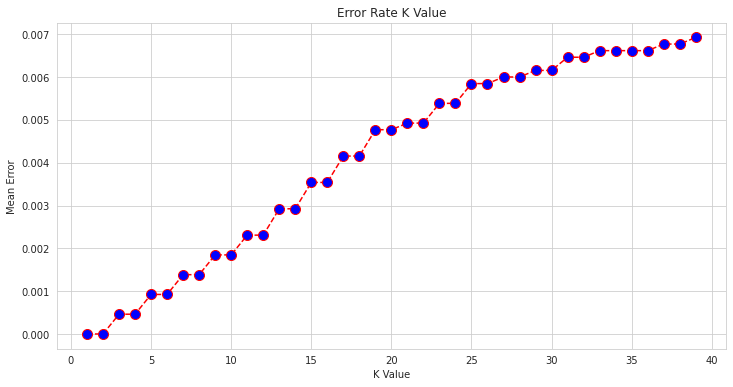

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

**Conclusion**
- As it can be seen above the mean error is gradually increasing and also for the very low K Values, we got the mean error as 0, so lets try to validate the same with some higher number of data

In [ ]:
# As KNN is quite Time consuming, if we try to fit the KNN on the whole dataset.
# Lets try to get the first 70k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 1lkh, then then the 70% of that is around 70k and 30k for the test set
x_train_temp = x_train[0:70000]
y_train_temp = y_train[0:70000]
x_test_temp  = x_test[-30000:-1]
y_test_temp  = y_test[-30000:-1]

print('Before Applying Upsampling')

print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

adasyn = ADASYN(sampling_strategy= 'minority', random_state= 42)
X_res, y_res = adasyn.fit_resample(x_train_temp, y_train_temp)

print('After Applying Upsampling')
print(f"Number of Fraud in Train Dataset {np.sum(y_res)} and % of fraud {round((np.sum(y_res)/len(y_res))*100,4)}")

Before Applying Upsampling
Number of Fraud in Train Dataset 99 and % of fraud 0.1414
Number of Fraud in Train Dataset 46 and % of fraud 0.1533
After Applying Upsampling
Number of Fraud in Train Dataset 69906 and % of fraud 50.0018


In [ ]:
# KNN model 2, lets try with 5 number of neighbors first
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

[[29900    53]
 [    8    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.42      0.83      0.55        46

    accuracy                           1.00     29999
   macro avg       0.71      0.91      0.78     29999
weighted avg       1.00      1.00      1.00     29999



In [ ]:
# Identifying the ideal K Values
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    print(f'Trying for the K Neighbors: { i }')
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_res, y_res)
    pred_i = knn.predict(x_test_temp)
    error.append(np.mean(pred_i != y_test_temp))
    done = time.time()
    elapsed = done - start
    print(f'Total Time Taken to Train: { round(elapsed,2)} seconds')
    print('========================================================\n')

Trying for the K Neighbors: 1
Total Time Taken to Train: 60.16 seconds

Trying for the K Neighbors: 2
Total Time Taken to Train: 78.58 seconds

Trying for the K Neighbors: 3
Total Time Taken to Train: 87.2 seconds

Trying for the K Neighbors: 4
Total Time Taken to Train: 94.07 seconds

Trying for the K Neighbors: 5
Total Time Taken to Train: 96.28 seconds

Trying for the K Neighbors: 6
Total Time Taken to Train: 98.12 seconds

Trying for the K Neighbors: 7
Total Time Taken to Train: 100.85 seconds

Trying for the K Neighbors: 8
Total Time Taken to Train: 101.06 seconds

Trying for the K Neighbors: 9
Total Time Taken to Train: 101.46 seconds

Trying for the K Neighbors: 10
Total Time Taken to Train: 101.02 seconds

Trying for the K Neighbors: 11
Total Time Taken to Train: 103.16 seconds

Trying for the K Neighbors: 12
Total Time Taken to Train: 105.0 seconds

Trying for the K Neighbors: 13
Total Time Taken to Train: 107.09 seconds

Trying for the K Neighbors: 14
Total Time Taken to Trai

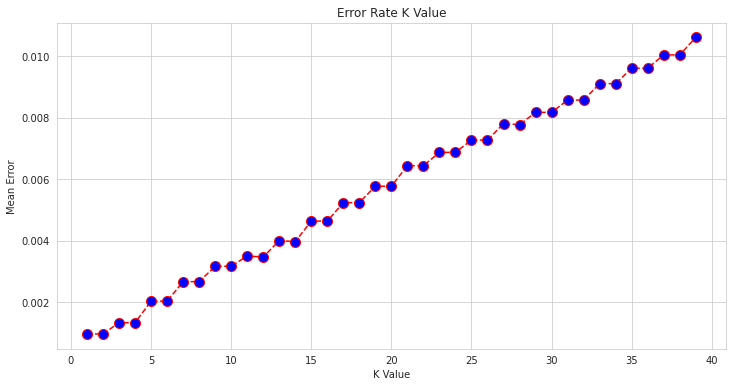

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

**Conclusion**
- As it can be seen here when we keep the value as low as possible we were able to get a zero mean error. So we would choose n_neighbors as 5 and lets see whether there is some improvement or not in recall rate

In [ ]:
# KNN model 5, lets try with 5 number of neighbors first
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_res, y_res)

y_pred = knn.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n------------------------------------------------------')
print('Lets try on the actual test dataset')

y_pred = knn.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[29900    53]
 [    8    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.42      0.83      0.55        46

    accuracy                           1.00     29999
   macro avg       0.71      0.91      0.78     29999
weighted avg       1.00      1.00      1.00     29999


------------------------------------------------------
Lets try on the actual test dataset
[[84819   157]
 [   28   114]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.42      0.80      0.55       142

    accuracy                           1.00     85118
   macro avg       0.71      0.90      0.78     85118
weighted avg       1.00      1.00      1.00     85118



#### KNN Cross Validation & Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning
model = KNeighborsClassifier(n_jobs=-1)

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{ 'n_neighbors': range(2,4,1),
                  'algorithm'  : ['kd_tree', 'ball_tree', 'brute' ],
                  'metric'     : ['euclidean', 'manhattan', 'chebyshev']
             }]
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(X_res, y_res)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 79.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 382.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid=[{'algorithm': ['kd_tree', 'ball_tree', 'brute'],
                          'metric': ['euclidean', 'manhattan', 'chebyshev'],
                          'n_neighbors': range(2, 4)}],
             return_train_score=True, scoring='recall', verbose=1)

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.948 corresponding to hyperparameters {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 3}


#### Fitting the model with obtained hyperparameters

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0          0.0          0
86361        0          0.0          0
94117        0          0.0          0
123803       0          0.0          0
126884       0          0.0          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0          0.0          0    0    0    0    0    0    0    0   
86361        0          0.0          0    0    0    0    0    0    0    0   
94117        0          0.0          0    0    0    0    0    0    0    0   
123803       0          0.0          0    0    0    0    0    0    0    0   
126884       0          0.0          0    0    0    0    0    0    0    0   

        0.7  0.8  0.9  
139330    0    0    0  
86361     0    0    0  
94117     0    0    0  
123803    0    0    0  
126884    0    0    0  




Checking the Accuracy, Sensitivity and Specificity for different Threshol

<Figure size 720x576 with 0 Axes>

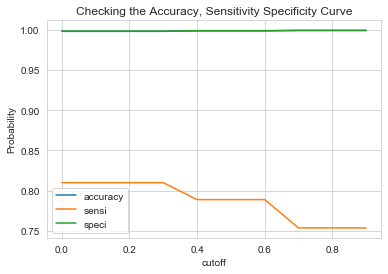

<Figure size 720x576 with 0 Axes>

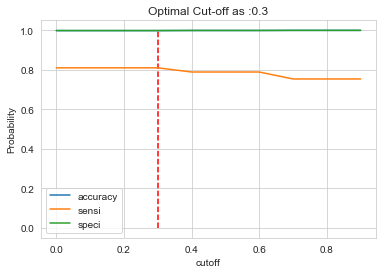





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0          0.0          0    0    0    0    0    0    0    0   
86361        0          0.0          0    0    0    0    0    0    0    0   
94117        0          0.0          0    0    0    0    0    0    0    0   
123803       0          0.0          0    0    0    0    0    0    0    0   
126884       0          0.0          0    0    0    0    0    0    0    0   

        0.7  0.8  0.9  Opt Cutoff  
139330    0    0    0           0  
86361     0    0    0           0  
94117     0    0    0           0  
123803    0    0    0           0  
126884    0    0    0           0  






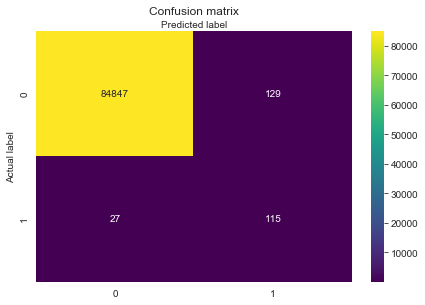

Misclassification Rate: 0.001832749829648253
Accuracy: 0.9981672501703518
Precision: 0.4713114754098361
Recall: 0.8098591549295775
Negative Predictive Power: 0.99848192430804




Some more Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.47      0.81      0.60       142

    accuracy                           1.00     85118
   macro avg       0.74      0.90      0.80     85118
weighted avg       1.00      1.00      1.00     85118







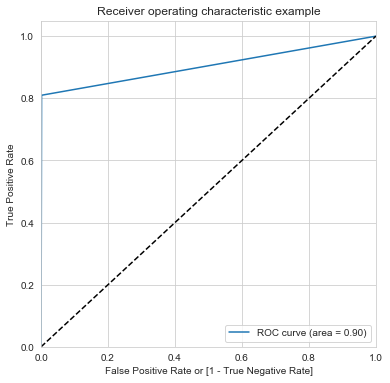

In [ ]:
# Lets build the final model
# KNN model final model
knn_final = KNeighborsClassifier(n_jobs=-1, algorithm = 'kd_tree', metric = 'manhattan', n_neighbors = 3)
adasyn = ADASYN(sampling_strategy= 'minority', random_state= 42)
pipe = Pipeline([('adasyn',adasyn),
                 ('knn_final',knn_final)])
pipe.fit(x_train, y_train)

determine_threshold(pipe, 0.3)

**Conclusion**
- Performance for KNN with ADASYN turns out to be better than the model built with SMOTE. Recall is better by 3 % and also AUC-ROC increased by 1 %
- Performace wrt to the model built with unbalanced data, AUC-ROC is way better and also the recall has increased by 7%

### SVM

In [ ]:
# As KNN is quite Time consuming, if we try to fit the KNN on the whole dataset.
# Lets try to get the first 70k records and fit the model and lets see what should be the parameter and based on that we would determine the hyperparameter
# If the total dataset size is 1lkh, then then the 70% of that is around 70k and 30k for the test set
x_train_temp = x_train[0:70000]
y_train_temp = y_train[0:70000]
x_test_temp  = x_test[-30000:-1]
y_test_temp  = y_test[-30000:-1]

print('Before Applying Upsampling')

print(f"Number of Fraud in Train Dataset {np.sum(y_train_temp)} and % of fraud {round((np.sum(y_train_temp)/len(y_train_temp))*100,4)}")
print(f"Number of Fraud in Train Dataset {np.sum(y_test_temp)} and % of fraud {round((np.sum(y_test_temp)/len(y_test_temp))*100,4)}")

adasyn = ADASYN(sampling_strategy= 'minority', random_state=42)
X_res, y_res = adasyn.fit_resample(x_train_temp, y_train_temp)

print('After Applying Upsampling')
print(f"Number of Fraud in Train Dataset {np.sum(y_res)} and % of fraud {round((np.sum(y_res)/len(y_res))*100,4)}")

Before Applying Upsampling
Number of Fraud in Train Dataset 99 and % of fraud 0.1414
Number of Fraud in Train Dataset 46 and % of fraud 0.1533
After Applying Upsampling
Number of Fraud in Train Dataset 69906 and % of fraud 50.0018


In [ ]:
# SVM Model 1
svm_model = svm.SVC(kernel='linear', random_state=42) # Lets try with Linear Kernal
svm_model.fit(X_res, y_res)

y_pred = svm_model.predict(x_test_temp)
print(confusion_matrix(y_test_temp, y_pred))
print(classification_report(y_test_temp, y_pred))

print('\n\n')
print('====================================================================')

print('Checking for the original df')
y_pred = svm_model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[28051  1902]
 [    4    42]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     29953
           1       0.02      0.91      0.04        46

    accuracy                           0.94     29999
   macro avg       0.51      0.92      0.50     29999
weighted avg       1.00      0.94      0.97     29999




Checking for the original df
[[79554  5422]
 [   16   126]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     84976
           1       0.02      0.89      0.04       142

    accuracy                           0.94     85118
   macro avg       0.51      0.91      0.51     85118
weighted avg       1.00      0.94      0.97     85118



#### SVM Cross Validation & Hyperparameter Tuning

In [ ]:
# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation
hyper_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10]},
                    {'kernel': ['linear'], 'C': [1, 10]}]


model = svm.SVC(random_state=42)
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(X_res, y_res)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [ ]:
# SVM Final Model as Hyperparameter tuning is taking quite some time
# So we would use the same Hyperparameter as SMOTE
svm_model = svm.SVC(random_state=42, C = 10, gamma =  0.001, kernel = 'rbf', probability=True)
adasyn = ADASYN(sampling_strategy= 'minority', random_state=42)
pipe = Pipeline([('adasyn',adasyn),
                 ('svm',svm_model)])
pipe.fit(x_train, y_train)
determine_threshold(pipe )

As svm requires high computation, we tried running for 26 hours on the local machine but it still kept on running. Hence, we stopped the execution of the same.

### Random Forest

In [ ]:
# Random Forest Classifier + Upsampling 1
rfc = RandomForestClassifier(random_state = 42, bootstrap = False, verbose = True, n_jobs = -1, warm_start= True)
adasyn = ADASYN(sampling_strategy= 'minority', random_state=42)
pipe = Pipeline([('adasyn',adasyn),
                 ('rfc',rfc)])

pipe.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.1s finished


Pipeline(steps=[('adasyn',
                 ADASYN(random_state=42, sampling_strategy='minority')),
                ('rfc',
                 RandomForestClassifier(bootstrap=False, n_jobs=-1,
                                        random_state=42, verbose=True,
                                        warm_start=True))])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0          0.0          0
86361        0          0.0          0
94117        0          0.0          0
123803       0          0.0          0
126884       0          0.0          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0          0.0          0    0    0    0    0    0    0    0   
86361        0          0.0          0    0    0    0    0    0    0    0   
94117        0          0.0          0    0    0    0    0    0    0    0   
123803       0          0.0          0    0    0    0    0    0    0    0   
126884       0          0.0          0    0    0    0    0    0    0    0   

        0.7  0.8  0.9  
139330    0    0    0  
86361     0    0    0  
94117     0    0    0  
123803    0    0    0  
126884    0    0    0  




Checking the Accuracy, Sensitivity and Specificity for different Threshol

<Figure size 720x576 with 0 Axes>

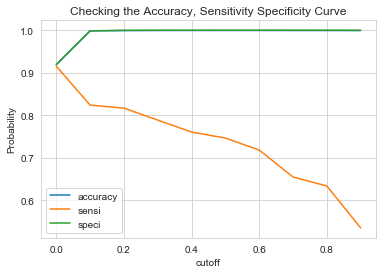

<Figure size 720x576 with 0 Axes>

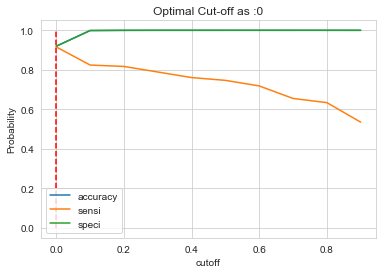





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0          0.0          0    0    0    0    0    0    0    0   
86361        0          0.0          0    0    0    0    0    0    0    0   
94117        0          0.0          0    0    0    0    0    0    0    0   
123803       0          0.0          0    0    0    0    0    0    0    0   
126884       0          0.0          0    0    0    0    0    0    0    0   

        0.7  0.8  0.9  Opt Cutoff  
139330    0    0    0           0  
86361     0    0    0           0  
94117     0    0    0           0  
123803    0    0    0           0  
126884    0    0    0           0  






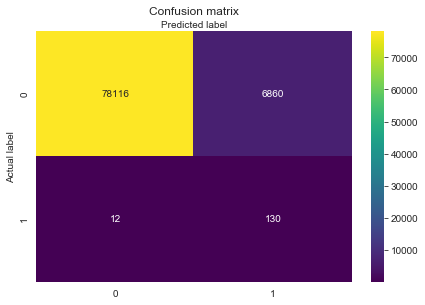

Misclassification Rate: 0.08073497967527432
Accuracy: 0.9192650203247257
Precision: 0.01859799713876967
Recall: 0.9154929577464789
Negative Predictive Power: 0.9192713236678591




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84976
           1       0.02      0.92      0.04       142

    accuracy                           0.92     85118
   macro avg       0.51      0.92      0.50     85118
weighted avg       1.00      0.92      0.96     85118







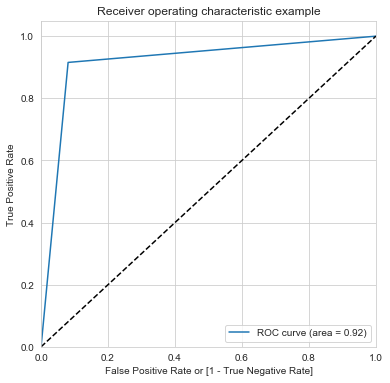

In [ ]:
determine_threshold(pipe,0)

**Conclusion**
- As it can be seen the ideal cutoff is coming as 0 so we would like to validate the same in the below steps
- Recall is also very good and AUC-ROC is 0.92, lets try to improve it a little

#### Random Forest Cross Validation & Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning
# As the training time was more than 6 hrs and also because of the computing constraints, we decided to work on 1lkh Subsample,
# and that would be considered for Hyperparameter Tunig
x_train_temp = x_train[0:70000]
y_train_temp = y_train[0:70000]

rfc = RandomForestClassifier(random_state=42, bootstrap = False, verbose = True, n_jobs = -1, warm_start= True)
adasyn = ADASYN(sampling_strategy= 'minority', random_state=42)
pipe = Pipeline([('adasyn',adasyn),
                 ('rfc',rfc)])
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
params = {
          'rfc__max_depth': range(2, 23, 10),
          'rfc__n_estimators': range(10, 210, 100),
          'rfc__max_features': range(12,32,10),
          'rfc__min_samples_leaf': range(10, 600, 500),
          'rfc__min_samples_split': range(10, 600, 500),
          'rfc__class_weight': ['balanced', {0:1, 1:5}]
        }

model_log_reg = GridSearchCV(pipe , cv = folds, param_grid = params, scoring  = 'recall', verbose = 5, n_jobs= -1, return_train_score=True)
# fitting the model
model_log_reg.fit(x_train_temp, y_train_temp)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 95.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('adasyn',
                                        ADASYN(random_state=42,
                                               sampling_strategy='minority')),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=False,
                                                               n_jobs=-1,
                                                               random_state=42,
                                                               verbose=True,
                                                               warm_start=True))]),
             n_jobs=-1,
             param_grid={'rfc__class_weight': ['balanced', {0: 1, 1: 5}],
                         'rfc__max_depth': range(2, 23, 10),
                         'rfc__max_features': range(12, 32, 10),
                         'rfc__min_samples_leaf': range(10, 600, 

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_log_reg.best_score_
best_hyperparams = model_log_reg.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.96 corresponding to hyperparameters {'rfc__class_weight': {0: 1, 1: 5}, 'rfc__max_depth': 2, 'rfc__max_features': 12, 'rfc__min_samples_leaf': 10, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 10}


#### Fitting the model with obtained hyperparameters

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.738568          1
86361        0     0.526417          1
94117        0     0.738568          1
123803       0     0.636564          1
126884       0     0.849739          1




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0     0.738568          1    1    1    1    1    1    1    1   
86361        0     0.526417          1    1    1    1    1    1    1    0   
94117        0     0.738568          1    1    1    1    1    1    1    1   
123803       0     0.636564          1    1    1    1    1    1    1    1   
126884       0     0.849739          1    1    1    1    1    1    1    1   

        0.7  0.8  0.9  
139330    1    0    0  
86361     0    0    0  
94117     1    0    0  
123803    0    0    0  
126884    1    1    0  




Checking the Accuracy, Sensitivity and Specificity for different Threshol

<Figure size 720x576 with 0 Axes>

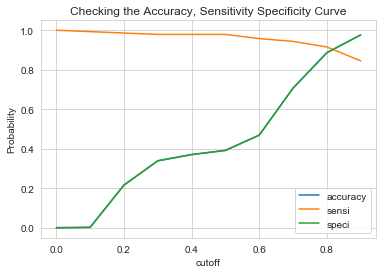





Enter the Ideal Cutoff Index: 0.82


<Figure size 720x576 with 0 Axes>

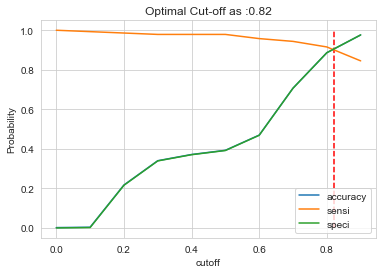





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
139330       0     0.738568          1    1    1    1    1    1    1    1   
86361        0     0.526417          1    1    1    1    1    1    1    0   
94117        0     0.738568          1    1    1    1    1    1    1    1   
123803       0     0.636564          1    1    1    1    1    1    1    1   
126884       0     0.849739          1    1    1    1    1    1    1    1   

        0.7  0.8  0.9  Opt Cutoff  
139330    1    0    0           0  
86361     0    0    0           0  
94117     1    0    0           0  
123803    0    0    0           0  
126884    1    1    0           1  






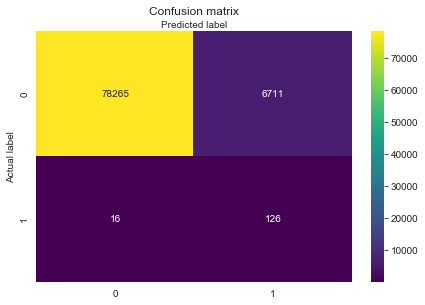

Misclassification Rate: 0.07903146220540896
Accuracy: 0.9209685377945911
Precision: 0.018429135585783237
Recall: 0.8873239436619719
Negative Predictive Power: 0.9210247599322161




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84976
           1       0.02      0.89      0.04       142

    accuracy                           0.92     85118
   macro avg       0.51      0.90      0.50     85118
weighted avg       1.00      0.92      0.96     85118







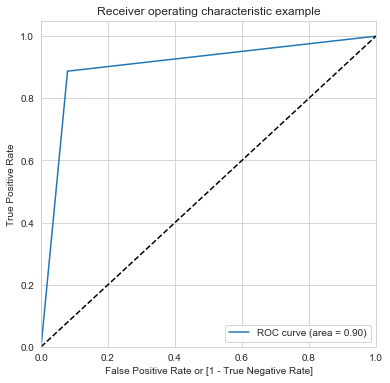

In [ ]:
rfc = RandomForestClassifier(random_state=42, bootstrap = False, verbose = True, n_jobs = -1, warm_start= True ,
                            class_weight = {0: 1, 1: 5}, max_depth = 2, max_features = 12, 
                            min_samples_leaf = 10, min_samples_split = 10, n_estimators = 10)
adasyn = ADASYN(sampling_strategy= 'minority', random_state=42)
pipe = Pipeline([('adasyn',adasyn),
                 ('rfc',rfc)])
pipe.fit(x_train, y_train)

determine_threshold(pipe)

### XGBoost

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.033126          0
86361        0     0.012429          0
94117        0     0.028760          0
123803       0     0.010780          0
126884       0     0.060691          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.033126          0    1    0  ...    0    0    0    0    0
86361        0     0.012429          0    1    0  ...    0    0    0    0    0
94117        0     0.028760          0    1    0  ...    0    0    0    0    0
123803       0     0.010780          0    1    0  ...    0    0    0    0    0
126884       0     0.060691          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.847706  0

<Figure size 720x576 with 0 Axes>

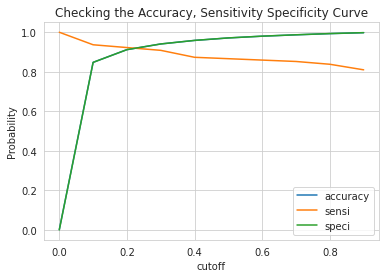

<Figure size 720x576 with 0 Axes>

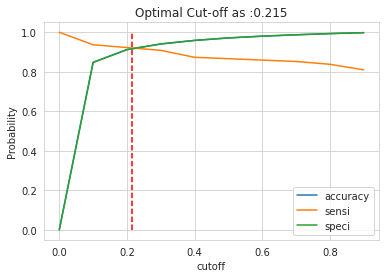





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.033126          0    1  ...    0    0    0           0
86361        0     0.012429          0    1  ...    0    0    0           0
94117        0     0.028760          0    1  ...    0    0    0           0
123803       0     0.010780          0    1  ...    0    0    0           0
126884       0     0.060691          0    1  ...    0    0    0           0

[5 rows x 14 columns]






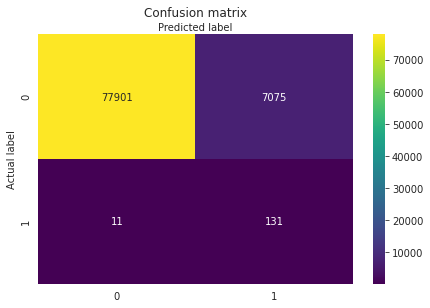

Misclassification Rate: 0.08324913649286872
Accuracy: 0.9167508635071313
Precision: 0.018179295031917845
Recall: 0.9225352112676056
Negative Predictive Power: 0.9167411975145924




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84976
           1       0.02      0.92      0.04       142

    accuracy                           0.92     85118
   macro avg       0.51      0.92      0.50     85118
weighted avg       1.00      0.92      0.95     85118







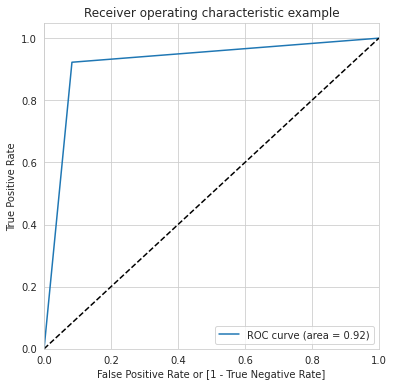

In [ ]:
# Lets try fitting the model with default parameter
adasyn = ADASYN(sampling_strategy= 'minority', random_state= 42)
X_res, y_res = adasyn.fit_resample(x_train, y_train)

x_train_over_samp = pd.DataFrame(X_res, columns=x_train.columns.to_list())
y_train_over_samp = pd.DataFrame(y_res, columns=[y_train.name])

xgboost = XGBClassifier(random_state= 101, tree_method = "gpu_hist")
xgboost.fit(x_train_over_samp, y_train_over_samp)

determine_threshold(xgboost, 0.215)

**Conclusion**
- Performance wrt to AUC is definitely better than the base model which was built with **SMOTE**
- Lets try to do some hyperparameter tuning and lets try to get the ideal parameters

#### XGBoost Cross Validation & Hyperparameter Tuning

In [ ]:
#Finding the best hyperparameter
# Here the main objective is to find the best possible Hyperparameter

# Using the Fold as 5
folds = StratifiedKFold(n_splits=5, random_state=42)

# specifying range of hyperparameters
# Setting the parameters by cross-validation

hyper_params = [{'learning_rate': [0.2, 0.4, 0.6, 0.8], 
             'subsample': [0.3, 0.6, 0.9],
             'n_estimators': range(10,400,50)}
                ]

# specifying model
model = XGBClassifier(random_state=42, tree_method = 'gpu_hist')
# setting up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1,
                        return_train_score=True,
                        )
                              
# fitting the model
model_cv.fit(x_train_over_samp, y_train_over_samp)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 11.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:lo...
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,3), best_hyperparams))

The best test score is 0.958 corresponding to hyperparameters {'learning_rate': 0.2, 'n_estimators': 110, 'subsample': 0.3}


#### Fitting the model with obtained hyperparameters

Using the default Threshold Cutoff as 0.5
        Actual  Probability  Predicted
139330       0     0.016237          0
86361        0     0.001860          0
94117        0     0.013577          0
123803       0     0.000180          0
126884       0     0.011988          0




Probability at Different Thereshold
        Actual  Probability  Predicted  0.0  0.1  ...  0.5  0.6  0.7  0.8  0.9
139330       0     0.016237          0    1    0  ...    0    0    0    0    0
86361        0     0.001860          0    1    0  ...    0    0    0    0    0
94117        0     0.013577          0    1    0  ...    0    0    0    0    0
123803       0     0.000180          0    1    0  ...    0    0    0    0    0
126884       0     0.011988          0    1    0  ...    0    0    0    0    0

[5 rows x 13 columns]




Checking the Accuracy, Sensitivity and Specificity for different Threshold
     cutoff  accuracy     sensi     speci
0.0     0.0  0.001668  1.000000  0.000000
0.1     0.1  0.933763  0

<Figure size 720x576 with 0 Axes>

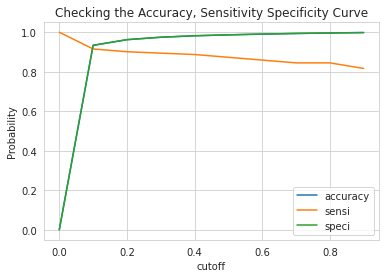

<Figure size 720x576 with 0 Axes>

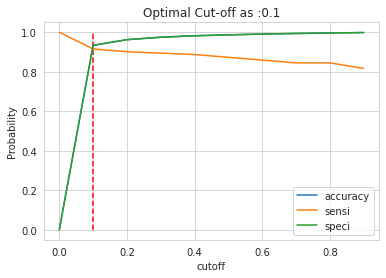





Lets the ideal Cutoff
        Actual  Probability  Predicted  0.0  ...  0.7  0.8  0.9  Opt Cutoff
139330       0     0.016237          0    1  ...    0    0    0           0
86361        0     0.001860          0    1  ...    0    0    0           0
94117        0     0.013577          0    1  ...    0    0    0           0
123803       0     0.000180          0    1  ...    0    0    0           0
126884       0     0.011988          0    1  ...    0    0    0           0

[5 rows x 14 columns]






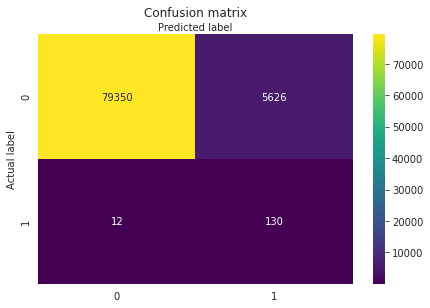

Misclassification Rate: 0.06623745858690289
Accuracy: 0.9337625414130971
Precision: 0.022585128561501043
Recall: 0.9154929577464789
Negative Predictive Power: 0.9337930709847486




Some more Metric
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     84976
           1       0.02      0.92      0.04       142

    accuracy                           0.93     85118
   macro avg       0.51      0.92      0.50     85118
weighted avg       1.00      0.93      0.96     85118







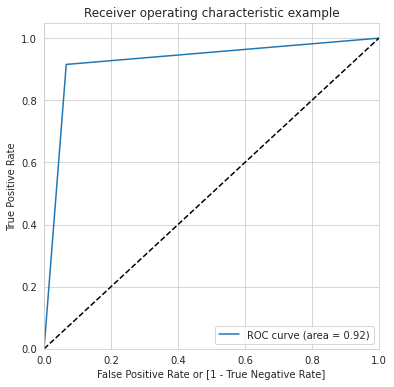

In [ ]:
# Random Forest Classifier + Upsampling 1 + with the ideal hyperparameters
xgboost = XGBClassifier(random_state= 101, tree_method = "gpu_hist", learning_rate = 0.2, n_estimators = 110, subsample = 0.3)
xgboost.fit(x_train_over_samp, y_train_over_samp)

determine_threshold(xgboost, 0.1)

**Conclusion**
- It can be seen here , the Recall rate increased a lot compared to the model o/p for the model build with SMOTE from 0.87 to 0.92 and RUC is nearly same for both the model.
- And wrt to the model which we have built wrt to unbalanced data, recall increased from 0.78 to 0.92, so there is quite a significant jump

### Concluding models with Upsampling (ADASYN)
Recall Values:
1. Logistic Regression: 0.90
2. KNN: 0.80
3. SVM: 0.86
4. Random Forest: 0.88
5. XGBoost: 0.92

AUC:
1. Logistic Regression: 0.91
2. KNN: 0.90
3. SVM: 0.91
4. Random Forest: 0.90
5. XGBoost: 0.92

Model with best **Recall** and **AUC** was **XGBoost** whereas Logistic Regression, KNN, SVM, and Random Forest gave nearly same AUC of 0.90 and 0.91.

As KNN and SVM takes high computation, instead of taking complete data, we took sample of data i.e., initial 70k rows and tried to fit the model. It saved computation time significantly thereby giving the reliable result.

#### Getting best features from the best model concluded from ADASYN

In [ ]:
coefficients = xgboost.feature_importances_.tolist()
column_names = x_train.columns.tolist()
coefficients_df = pd.DataFrame([column_names, coefficients], index = ['variables','coefficients']).T
coefficients_df.sort_values(by = 'coefficients', ascending= False).head(3)

variables coefficients
4         V4     0.163778
14       V14     0.162978
8         V8    0.0691829

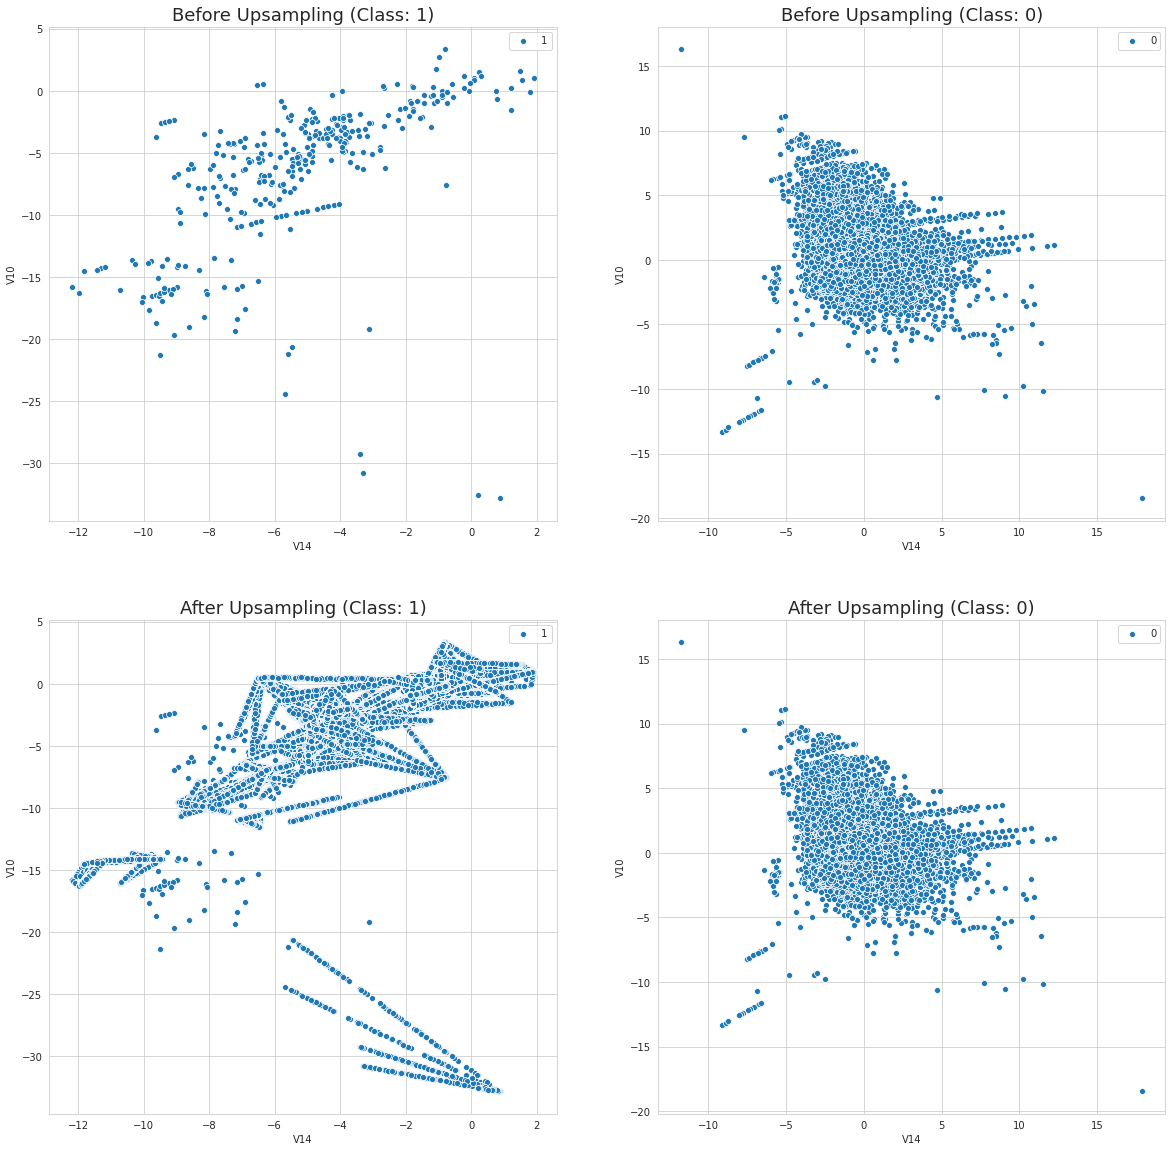

In [ ]:
adasyn = ADASYN(random_state = 42, sampling_strategy='minority') 
X_train_samp, y_train_samp = adasyn.fit_sample(x_train, y_train)
X_train_samp_df = pd.DataFrame(X_train_samp, columns=x_train.columns.tolist())
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title('Before Upsampling (Class: 1)', fontsize = 18)
sns.scatterplot(x = x_train[y_train == 1]['V14'], y = x_train[y_train == 1]['V10'], legend='full')
plt.legend('1')

plt.subplot(2,2,2)
plt.title('Before Upsampling (Class: 0)', fontsize = 18)
sns.scatterplot(x = x_train[y_train ==0]['V14'], y = x_train[y_train == 0]['V10'], legend='full')
plt.legend('0')

plt.subplot(2,2,3)
plt.title('After Upsampling (Class: 1)', fontsize = 18)
sns.scatterplot(x = X_train_samp_df[y_train_samp == 1]['V14'], y = X_train_samp_df[y_train_samp == 1]['V10'], legend='full')
plt.legend('1')

plt.subplot(2,2,4)
plt.title('After Upsampling (Class: 0)', fontsize = 18)
sns.scatterplot(x = X_train_samp_df[y_train_samp ==0]['V14'], y = X_train_samp_df[y_train_samp == 0]['V10'], legend='full')
plt.legend('0')

plt.show()